# **Police & citizen scaling**

In [ ]:
!pip -q install --upgrade pip setuptools wheel
!pip -q install osmnx geopandas shapely scipy matplotlib numpy networkx rtree pyproj
!apt-get -qq update
!apt-get -qq install -y fonts-nanum
!pip install osmnx
!pip install adjustText

In [2]:
# ===== 1) 임포트/폰트 =====
import numpy as np, geopandas as gpd, matplotlib.pyplot as plt, re
from matplotlib import font_manager, rc
import os
import osmnx as ox, networkx as nx
from shapely.geometry import Point, box
from scipy.spatial import cKDTree
from adjustText import adjust_text

plt.rcParams["axes.unicode_minus"] = False
fp="/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
if os.path.exists(fp): font_manager.fontManager.addfont(fp); rc("font", family="NanumGothic")
else: rc("font", family="DejaVu Sans")

스케일링 지수 alpha = 0.740
절편 a = -1.992
R^2 = 0.965


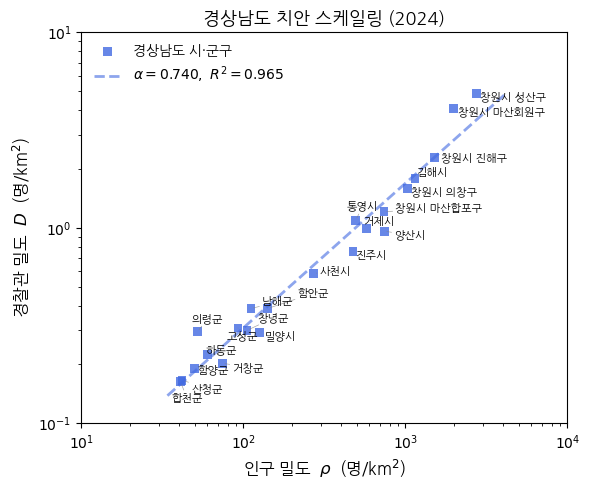

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from adjustText import adjust_text          # 라벨 겹침 조정

# === 여기 추가: 나눔고딕 설정 ===
import matplotlib as mpl
import matplotlib.font_manager as fm

# 설치된 폰트 목록에서 나눔고딕이 있는지 확인하고 설정
available = {f.name for f in fm.fontManager.ttflist}

# 한글 + 음수 부호 깨짐 방지
mpl.rcParams["axes.unicode_minus"] = False
mpl.rcParams["font.family"] = "NanumGothic"

df = pd.read_excel(
    '/Data/경상남도 인구 및 면적.xlsx'
)


# --------------------------------------------------
# 2. 분석용 열 이름 정리
#    (엑셀 열 이름이 다르면 여기만 수정하면 됨)
# --------------------------------------------------
df = df.rename(columns={
    "지자체(시군구)": "region",
    "면적(㎢)오름차순으로 정렬하기": "area_km2",
    "세대수오름차순으로 정렬하기": "households",
    "인구수오름차순으로 정렬하기": "population",
    "2023 경찰관 현황": "police_officers"
})

# 숫자형으로 강제 변환
num_cols = ["area_km2", "households", "population", "police_officers"]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# 필요한 값 없는 행 제거
df = df.dropna(subset=["area_km2", "population", "police_officers"])

# --------------------------------------------------
# 3. 밀도 계산
# --------------------------------------------------
df["pop_density"] = df["population"] / df["area_km2"]          # 명 / km^2
df["police_density"] = df["police_officers"] / df["area_km2"]  # 명 / km^2

# 로그 계산 가능하도록 0 이하 제거
df = df[(df["pop_density"] > 0) & (df["police_density"] > 0)].copy()

# --------------------------------------------------
# 4. 로그–로그 회귀 ( D ~ rho^alpha )
# --------------------------------------------------
x = np.log10(df["pop_density"].values)
y = np.log10(df["police_density"].values)

reg = linregress(x, y)
alpha = reg.slope
intercept = reg.intercept
r2 = reg.rvalue ** 2

print(f"스케일링 지수 alpha = {alpha:.3f}")
print(f"절편 a = {intercept:.3f}")
print(f"R^2 = {r2:.3f}")

# 회귀선용 x 범위
x_fit = np.linspace(x.min() * 0.95, x.max() * 1.05, 200)
y_fit = intercept + alpha * x_fit

# --------------------------------------------------
# 5. 그림 (범위·스타일 손질 버전)
# --------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 5))

# --- 1) x, y 범위를 데이터 기반으로 자동 설정 (10의 거듭제곱 단위) ---
x_min = df["pop_density"].min()
x_max = df["pop_density"].max()
y_min = df["police_density"].min()
y_max = df["police_density"].max()

x_lim = (10**np.floor(np.log10(x_min)), 10**np.ceil(np.log10(x_max)))
y_lim = (10**np.floor(np.log10(y_min)), 10**np.ceil(np.log10(y_max)))

# --- 2) 산점도: 테두리만 있는 마커, 살짝 투명 ---
ax.scatter(
    df["pop_density"], df["police_density"],
    s=40,
    facecolors="royalblue", alpha = 0.8,
    edgecolors="none",
    marker="s",
    label="경상남도 시·군구"
)

# --- 3) 회귀선: 굵은 점선 ---
ax.plot(
    10**x_fit, 10**y_fit, alpha = 0.6,
    linestyle="--",
    linewidth=2.0,
    color="royalblue",
    label=rf"$\alpha = {alpha:.3f},\ R^2 = {r2:.3f}$"   # ← r2 추가
)

# --- 4) 로그 스케일 + 범위 적용 ---
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(x_lim)
ax.set_ylim(y_lim)

# 틱 폰트 sans 계열
for ticklab in ax.get_xticklabels() + ax.get_yticklabels():
    ticklab.set_fontfamily("DejaVu Sans")

# --- 4-1) 도시 이름 라벨 + 겹침 자동 조정 ---
texts = []
for _, r in df.iterrows():
    texts.append(
        ax.text(
            r["pop_density"],
            r["police_density"],
            r["region"],
            fontsize=8,
            ha="left",
            va="center"
        )
    )

adjust_text(
    texts,
    x=df["pop_density"].values,
    y=df["police_density"].values,
    ax=ax,
    arrowprops=dict(
        arrowstyle="-",
        color="gray",
        lw=0.5,
        alpha=0.7
    )
)


# --- 5) 라벨/제목/범례 정리 ---
ax.set_xlabel("인구 밀도  $\\rho$  (명/km$^2$)", fontsize=12)
ax.set_ylabel("경찰관 밀도  $D$  (명/km$^2$)", fontsize=12)
ax.set_title("경상남도 치안 스케일링 (2024)", fontsize=13)

leg = ax.legend(
    frameon=False,
    loc="upper left",
    fontsize=10
)
leg.get_frame().set_linewidth(0.8)

plt.tight_layout()
plt.show()

# **Gyeongsangnam-do safty map**

In [ ]:
!conda activate patrol
!mamba install -c conda-forge geopandas -y

In [ ]:
!conda activate patrol
!conda install -c conda-forge mamba -y
!mamba install -c conda-forge geopandas -y

## step1) 실제 도로/지리/인구 데이터 로드 + 기본 설정

In [2]:
# ===== STEP1 (FINAL, ONE CELL): roads/geography/population load + GN hierarchy (Changwon 3-depth exception) =====
import os, re, glob, json, time, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import geopandas as gpd
import osmnx as ox
import networkx as nx

from shapely.geometry import Point
from scipy.spatial import cKDTree

# ---------------------------
# 0) USER PATHS
# ---------------------------
OUT_DIR = "result"
CACHE_DIR = os.path.join(OUT_DIR, "_cache")
BOUNDARY_DIR = os.path.join(OUT_DIR, "_boundary")  # 행정동 경계파일(shp/gpkg/geojson) 있으면 넣기

PATH_MUNI  = "/Data/경상남도 인구 및 면적.xlsx"
PATH_DONG  = "/Data/경상남도 인구데이터.xlsx"

os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(CACHE_DIR, exist_ok=True)
os.makedirs(BOUNDARY_DIR, exist_ok=True)

print("OUT_DIR:", OUT_DIR)
print("CACHE_DIR:", CACHE_DIR)
print("BOUNDARY_DIR:", BOUNDARY_DIR)

for p in [PATH_MUNI, PATH_DONG]:
    assert os.path.exists(p), f"Not found: {p}"



# ---------------------------
# 1) CRS / PARAMETERS
# ---------------------------
CRS_W = "EPSG:4326"
CRS_M = "EPSG:3857"  # meter-based
CELL = 100
SAMPLE_M = 30.0
P_DETOUR = 0.10

ARTERIAL = {'trunk','primary','secondary','trunk_link','primary_link','secondary_link'}
DEFAULT_KPH = {
    "motorway":80,"trunk":60,"primary":50,"secondary":40,"tertiary":35,
    "unclassified":30,"residential":25,"living_street":15,"service":15,
    "motorway_link":60,"trunk_link":50,"primary_link":40,"secondary_link":35,"tertiary_link":30
}

def slug(s: str) -> str:
    s = re.sub(r"[^\w가-힣\- ]+", "", str(s)).strip().replace(" ", "_")
    return s[:80]

def pick_col(cols, keys):
    for k in keys:
        for c in cols:
            if k in str(c):
                return c
    return None

def clean_ws(s: str) -> str:
    # 전각 공백/nbsp 포함 전부 제거(계층 파싱 안정화)
    s = "" if s is None else str(s)
    s = s.replace("\u3000", " ").replace("\xa0", " ")
    s = re.sub(r"\s+", "", s)
    return s

def norm_name(s: str) -> str:
    s = clean_ws(s)
    s = s.replace("경상남도","").replace("경남","")
    return s

def add_travel_time(G):
    for u,v,k,d in G.edges(keys=True, data=True):
        hw = d.get("highway")
        hw = hw[0] if isinstance(hw, list) and hw else hw
        kph = DEFAULT_KPH.get(hw, 30)
        d["travel_time"] = float(d.get("length",1.0)) / (kph*1000/9000)  # sec
    return G

def is_arterial_edge(d):
    hw = d.get("highway")
    s = set(hw) if isinstance(hw, list) else ({hw} if hw is not None else set())
    return len(s & ARTERIAL) > 0

# ---------------------------
# 2) LOAD MUNI (시군구 인구/면적) - FINAL
#    - "창원시 ○○구" 중간집계 제거
#    - 컬럼 자동 탐색 + 숫자형 변환 + 기본 정리
# ---------------------------
import numpy as np
import pandas as pd
import re

def pick_col(cols, keys):
    cols = list(cols)
    for k in keys:
        for c in cols:
            if k in str(c):
                return c
    return None

def norm_name(s):
    s = str(s)
    s = re.sub(r"\s+", "", s)
    s = s.replace("경상남도","").replace("경남","")
    return s

muni_raw = pd.read_excel(PATH_MUNI).copy()
print("muni cols:", list(muni_raw.columns))

# 1) 컬럼 찾기
C_MUNI = pick_col(muni_raw.columns, ["지자체(시군구)", "지자체", "시군구", "시·군·구"])
C_POP  = pick_col(muni_raw.columns, ["인구수", "인구"])
C_AKM2 = pick_col(muni_raw.columns, ["면적(㎢)", "면적"])
C_OFF  = pick_col(muni_raw.columns, ["경찰관", "경찰관 현황", "경찰공무원"])

if C_MUNI is None or C_POP is None:
    raise ValueError(f"[ERROR] 필수 컬럼 탐색 실패. C_MUNI={C_MUNI}, C_POP={C_POP}")

rename_map = {C_MUNI: "muni", C_POP: "pop"}
if C_AKM2 is not None: rename_map[C_AKM2] = "area_km2"
if C_OFF  is not None: rename_map[C_OFF]  = "police_officers"

# 2) 리네임 + 최소 컬럼 유지
keep_cols = list(rename_map.keys())
muni = muni_raw[keep_cols].rename(columns=rename_map).copy()

# 3) 기본 클린업
muni["muni"] = muni["muni"].astype(str).str.strip()

# 4) "창원시 ○○구" 중간집계 제거 (예: "창원시 마산합포구")
muni = muni[~muni["muni"].str.match(r"^창원시\s+.*구$")].copy()

# 5) 숫자형 변환
muni["pop"] = pd.to_numeric(muni["pop"], errors="coerce")
if "area_km2" in muni.columns:
    muni["area_km2"] = pd.to_numeric(muni["area_km2"], errors="coerce")
if "police_officers" in muni.columns:
    muni["police_officers"] = pd.to_numeric(muni["police_officers"], errors="coerce")

# 6) 결측/이상치 제거
muni = muni.dropna(subset=["muni", "pop"]).copy()
muni = muni[muni["pop"] > 0].copy()

# 7) 키 생성
muni["muni_key"] = muni["muni"].apply(norm_name)

# 8) 정리
muni = muni.reset_index(drop=True)

print("muni rows:", len(muni))
display(muni.head(10))

# ---------------------------
# 3) LOAD DONG POP (계층 파싱: 창원 3-depth 예외)
#    - 창원: prov -> 창원시 -> ~구 -> emd
#    - 기타: prov -> muni -> emd (구 없음)
#    - emd 판정: (읍|면|동|출장소|공동)$ 모두 포함
# ---------------------------
dong_raw = pd.read_excel(PATH_DONG).copy()
print("dong cols:", list(dong_raw.columns))

REGION_COL = "행정구역(동읍면)별"
ITEM_COL   = "항목"
YEAR_COL   = "2024"

def parse_gn_hierarchy_dongpop(raw_df,
                               region_col=REGION_COL, item_col=ITEM_COL, year_col=YEAR_COL,
                               pop_item_regex=r"(인구|주민등록)",
                               changwon_name="창원시",
                               prov_name="경상남도"):
    for c in [region_col, item_col, year_col]:
        if c not in raw_df.columns:
            raise ValueError(f"'{c}' 컬럼이 없음. 현재 컬럼: {list(raw_df.columns)}")

    df = raw_df[[region_col, item_col, year_col]].copy()
    df.columns = ["region_raw", "item", "value"]
    df["item"] = df["item"].astype(str)
    df = df[df["item"].str.contains(pop_item_regex, regex=True, na=False)].copy()

    df["value"] = pd.to_numeric(df["value"], errors="coerce")
    df = df[df["value"].notna()].copy()

    df["region_raw"] = df["region_raw"].astype(str)
    df["region"] = df["region_raw"].apply(clean_ws)
    df = df[df["region"].ne("")].copy()

    def is_prov(x): return x == clean_ws(prov_name) or bool(re.search(r"(도)$", x))
    def is_muni(x): return bool(re.search(r"(시|군)$", x)) and (not bool(re.search(r"(구)$", x)))
    def is_gu(x):   return bool(re.search(r"(구)$", x))
    def is_emd(x):  return bool(re.search(r"(읍|면|동|출장소|공동)$", x))

    rows = []
    cur_prov = None
    cur_muni = None
    cur_gu = ""  # 기본은 빈 문자열(구 없음)

    for _, r in df.iterrows():
        name = r["region"]
        pop  = float(r["value"])

        if is_prov(name):
            cur_prov = name
            cur_muni = None
            cur_gu = ""
            continue

        # muni(시/군)
        if is_muni(name):
            cur_muni = name
            cur_gu = ""
            continue

        # 구는 창원시에만 '활성'
        if is_gu(name):
            if cur_muni == clean_ws(changwon_name):
                cur_gu = name
            else:
                # 창원 아닌데 구가 나오면: 데이터 잡음 -> 그냥 무시(emd의 상위로 쓰면 더 망가짐)
                cur_gu = ""
            continue

        # emd
        if is_emd(name):
            if cur_muni is None:
                continue
            rows.append({
                "prov": cur_prov if cur_prov is not None else clean_ws(prov_name),
                "muni": cur_muni,
                "gu": cur_gu if (cur_muni == clean_ws(changwon_name)) else "",
                "emd": name,
                "year": int(str(year_col)),
                "pop": pop
            })

    out = pd.DataFrame(rows)
    if len(out) == 0:
        return out

    out["prov_key"] = out["prov"].apply(norm_name)
    out["muni_key"] = out["muni"].apply(norm_name)
    out["gu_key"]   = out["gu"].apply(norm_name)
    out["emd_key"]  = out["emd"].apply(norm_name)
    out = out.groupby(["prov","muni","gu","emd","prov_key","muni_key","gu_key","emd_key","year"], as_index=False)["pop"].sum()
    return out

dong_hier = parse_gn_hierarchy_dongpop(dong_raw)

print("dong_hier rows:", len(dong_hier))
print("muni n:", dong_hier["muni"].nunique(),
      " / changwon gu n:", dong_hier.loc[dong_hier["muni"].apply(clean_ws)=="창원시","gu"].replace("", np.nan).dropna().nunique())
display(dong_hier.head(15))


# ---------------------------
# 4) boundary file auto-load (optional)
# ---------------------------
def find_boundary_file(boundary_dir=BOUNDARY_DIR):
    cand = []
    cand += glob.glob(os.path.join(boundary_dir, "*.geojson"))
    cand += glob.glob(os.path.join(boundary_dir, "*.json"))
    cand += glob.glob(os.path.join(boundary_dir, "*.gpkg"))
    cand += glob.glob(os.path.join(boundary_dir, "*.shp"))
    return cand[0] if cand else None

BOUNDARY_FILE = find_boundary_file()
print("BOUNDARY_FILE:", BOUNDARY_FILE)

ADMIN_DONG_GDF = None
if BOUNDARY_FILE is not None:
    ADMIN_DONG_GDF = gpd.read_file(BOUNDARY_FILE).to_crs(CRS_M)
    print("ADMIN_DONG_GDF loaded:", ADMIN_DONG_GDF.shape)
    display(ADMIN_DONG_GDF.head(3))
else:
    print("[INFO] 행정동 경계 파일 없음. (step2에서 ZIP 경계 또는 다른 경계파일로 진행)")

# ---------------------------
# 5) OSM fetch/cache helpers (시군구 단위)
# ---------------------------
def cache_paths_muni(muni_name):
    k = slug(muni_name)
    return {
        "poly":   os.path.join(CACHE_DIR, f"{k}_poly.geojson"),
        "graph":  os.path.join(CACHE_DIR, f"{k}_graph.graphml"),
        "police": os.path.join(CACHE_DIR, f"{k}_police.geojson"),
    }

def fetch_polygon(place_name):
    gdf = ox.geocode_to_gdf(place_name)
    poly = gdf.loc[0, "geometry"]
    poly_m = gpd.GeoSeries([poly], crs=CRS_W).to_crs(CRS_M).iloc[0]
    return poly, poly_m

def fetch_graph(poly):
    cf = ('["highway"~"motorway|trunk|primary|secondary|tertiary|unclassified|'
          'residential|living_street|service|motorway_link|trunk_link|'
          'primary_link|secondary_link|tertiary_link"]')
    G = ox.graph_from_polygon(poly, custom_filter=cf, simplify=True, retain_all=True)
    G = ox.project_graph(G, to_crs=CRS_M)
    return add_travel_time(G)

def fetch_police_points(poly):
    pol_raw = ox.features_from_polygon(poly, {"amenity":"police"})
    def to_point(g):
        return g if (g is not None and g.geom_type=="Point") else (g.representative_point() if g is not None else None)
    pts, names = [], []
    for _, r in pol_raw.iterrows():
        p = to_point(r.geometry)
        if p is not None:
            pts.append(p); names.append(r.get("name",""))
    return gpd.GeoDataFrame({"name":names}, geometry=pts, crs=CRS_W).to_crs(CRS_M)

# ---------------------------
# police name fill (동/읍/면 기반 + 중복시 123 넘버링)
# ---------------------------
def _extract_emd_from_adm_nm(adm_nm: str) -> str:
    """
    ADM_NM 같은 문자열에서 마지막 행정단위(읍/면/동/출장소/공동)를 추출.
    예) "경상남도 양산시 물금읍" -> "물금읍"
        "경상남도 창원시 마산합포구 오동동" -> "오동동"
    """
    s = "" if adm_nm is None else str(adm_nm)
    s = s.replace("\u3000", " ").replace("\xa0", " ")
    s = re.sub(r"\s+", "", s)  # 공백 제거
    m = re.search(r"([가-힣0-9]+(읍|면|동|출장소|공동))$", s)
    if m:
        return m.group(1)
    # 못 뽑으면 마지막 토큰 비슷하게라도
    m2 = re.search(r"([가-힣0-9]+)$", s)
    return m2.group(1) if m2 else ""

def fill_station_name(pol_gdf, muni_name: str, boundary_gdf=None, prefix="경찰시설"):
    """
    - name이 None/빈값이면: (행정동/읍면) 기반으로 "{muni}{emd}" 형태로 채움 (공백 제거)
    - 같은 emd에서 여러 개면: "{muni}{emd}1,2,3..." 넘버링
    - boundary_gdf(ADMIN_DONG_GDF)가 없으면: "{muni}{prefix}{순번}" fallback
    """
    pol = pol_gdf.copy()

    if "name" not in pol.columns:
        pol["name"] = None

    # 1) name 결측 마스크
    s = pol["name"].fillna("").astype(str).str.strip()
    miss = (s == "") | (s.str.lower() == "nan") | (s == "None")

    if miss.sum() == 0:
        return pol

    # 2) 동/읍면(emd) 추출: boundary_gdf가 있으면 sjoin으로 ADM_NM 확보
    emd = pd.Series([""] * len(pol), index=pol.index, dtype=object)

    if boundary_gdf is not None and hasattr(boundary_gdf, "geometry") and len(boundary_gdf) > 0:
        bd = boundary_gdf.copy()
        # CRS 정리
        if bd.crs is None:
            bd = bd.set_crs(CRS_M, allow_override=True)
        bd = bd.to_crs(CRS_M)

        pol2 = pol.copy()
        if pol2.crs is None:
            pol2 = pol2.set_crs(CRS_M, allow_override=True)
        pol2 = pol2.to_crs(CRS_M)

        # join 대상 컬럼 선택
        name_col = "ADM_NM" if ("ADM_NM" in bd.columns) else (bd.columns[0] if len(bd.columns) else None)
        cols = ["geometry"]
        if name_col is not None and name_col in bd.columns:
            cols = [name_col, "geometry"]

        # within 우선, 실패분은 intersects로 보정
        j = gpd.sjoin(pol2.loc[miss], bd[cols], how="left", predicate="within").drop(columns=["index_right"], errors="ignore")
        need_fix = j[name_col].isna() if (name_col in j.columns) else pd.Series(False, index=j.index)

        if need_fix.any():
            j2 = gpd.sjoin(pol2.loc[miss].loc[need_fix.index], bd[cols], how="left", predicate="intersects").drop(columns=["index_right"], errors="ignore")
            if name_col in j.columns and name_col in j2.columns:
                j.loc[need_fix.index, name_col] = j2[name_col].values

        if name_col in j.columns:
            emd.loc[j.index] = j[name_col].apply(_extract_emd_from_adm_nm).astype(str).values

    # 3) base 이름 생성 (muni + emd). emd가 비면 fallback으로 prefix+순번
    muni_clean = re.sub(r"\s+", "", str(muni_name))

    idx_all = np.arange(1, len(pol) + 1)
    fallback = np.array([f"{muni_clean}{prefix}{i:02d}" for i in idx_all], dtype=object)

    base = emd.copy()
    base = base.fillna("").astype(str)
    base = base.apply(lambda x: re.sub(r"\s+", "", x))
    base = np.where(base != "", np.array([f"{muni_clean}{x}" for x in base], dtype=object), fallback)

    # 4) name 채우기
    pol.loc[miss, "name"] = base[miss]

    # 5) 같은 이름이 여러 개면 123 넘버링(이번에 채운 것들만 대상으로)
    s2 = pol["name"].fillna("").astype(str)
    is_filled_now = miss.values  # 이번에 만든 name만

    # 중복 여부 계산
    dup_counts = pd.Series(s2[is_filled_now]).value_counts()
    dup_names = set(dup_counts[dup_counts >= 2].index.tolist())
    if dup_names:
        filled_idx = pol.index[is_filled_now]
        # 그룹별 누적번호
        tmp = pd.DataFrame({"idx": filled_idx, "nm": s2.loc[filled_idx].values})
        tmp["k"] = tmp.groupby("nm").cumcount() + 1
        # 중복 그룹만 suffix 부여
        for _, r in tmp.iterrows():
            if r["nm"] in dup_names:
                pol.at[r["idx"], "name"] = f"{r['nm']}{int(r['k'])}"

    return pol

# ---------------------------
# load_or_build_muni_osm 수정: pol 로드 직후 이름 채우고 캐시에 저장
# ---------------------------
def load_or_build_muni_osm(muni_name):
    paths = cache_paths_muni(muni_name)
    place = f"{muni_name}, Gyeongsangnam-do, South Korea"

    if os.path.exists(paths["poly"]):
        poly_w = gpd.read_file(paths["poly"]).to_crs(CRS_W).geometry.iloc[0]
        poly_m = gpd.read_file(paths["poly"]).to_crs(CRS_M).geometry.iloc[0]
    else:
        poly_w, poly_m = fetch_polygon(place)
        gpd.GeoDataFrame({"muni":[muni_name]}, geometry=[poly_w], crs=CRS_W).to_file(paths["poly"], driver="GeoJSON")

    if os.path.exists(paths["graph"]):
        G = ox.load_graphml(paths["graph"])
    else:
        G = fetch_graph(poly_w)
        ox.save_graphml(G, paths["graph"])

    if os.path.exists(paths["police"]):
        pol = gpd.read_file(paths["police"])
        if pol.crs is None:
            pol = pol.set_crs(CRS_W, allow_override=True)
        pol = pol.to_crs(CRS_M)
    else:
        pol = fetch_police_points(poly_w)

    # ✅ 여기서 이름 보정: ADMIN_DONG_GDF 있으면 동/읍면 기반으로 채우기
    bd = globals().get("ADMIN_DONG_GDF", None)
    pol = fill_station_name(pol, muni_name=muni_name, boundary_gdf=bd, prefix="경찰시설")

    # ✅ 캐시에 보정된 이름으로 저장(다음부터 바로 로드)
    pol.to_crs(CRS_W).to_file(paths["police"], driver="GeoJSON")

    return poly_m, G, pol

# ---------------------------
# 7) Optional sanity check (NO NaN problem)
# ---------------------------
chk = dong_hier.groupby("muni", as_index=False)["pop"].sum().rename(columns={"pop":"pop_sum_emd"})
chk2 = muni[["muni","pop"]].merge(chk, on="muni", how="left")
chk2["diff"] = chk2["pop_sum_emd"] - chk2["pop"]
chk2["diff_ratio"] = chk2["diff"] / chk2["pop"]
print("[CHECK] muni pop vs sum(emd): NaN count =", int(chk2["pop_sum_emd"].isna().sum()))
display(chk2.sort_values("diff_ratio").head(10))

print("STEP1 ready.")
print("- muni:", muni.shape, "dong_hier:", dong_hier.shape, "boundary:", (None if ADMIN_DONG_GDF is None else ADMIN_DONG_GDF.shape))
print("- helper: load_or_build_muni_osm(muni_name)")

OUT_DIR: /Users/gahyoungim/Library/CloudStorage/GoogleDrive-dotchgahyoun@gmail.com/내 드라이브/2025 융복합 ICT 공모전/result
CACHE_DIR: /Users/gahyoungim/Library/CloudStorage/GoogleDrive-dotchgahyoun@gmail.com/내 드라이브/2025 융복합 ICT 공모전/result/_cache
BOUNDARY_DIR: /Users/gahyoungim/Library/CloudStorage/GoogleDrive-dotchgahyoun@gmail.com/내 드라이브/2025 융복합 ICT 공모전/result/_boundary
[WARN] PATH_STAFF not found. staff는 생략합니다: /Users/gahyoungim/Library/CloudStorage/GoogleDrive-dotchgahyoun@gmail.com/내 드라이브/2025 융복합 ICT 공모전/경상남도-경찰공무원-2018.csv
muni cols: ['연도', '지자체(시군구)', '면적(㎢)오름차순으로 정렬하기', '세대수오름차순으로 정렬하기', '인구수오름차순으로 정렬하기', 'Unnamed: 5', '2023 경찰관 현황']
muni rows: 17


,muni,pop,area_km2,police_officers,muni_key
0,거제시,232972,403.88,400,거제시
1,거창군,59588,803.96,163,거창군
2,고성군,48005,518.02,159,고성군
3,김해시,531676,463.55,829,김해시
4,남해군,39832,357.78,138,남해군
5,밀양시,100691,798.71,233,밀양시
6,사천시,108504,398.82,233,사천시
7,산청군,33259,794.73,132,산청군
8,양산시,359531,485.70,467,양산시
9,의령군,25150,482.92,142,의령군


dong cols: ['행정구역(동읍면)별', '항목', '2024']
dong_hier rows: 310
muni n: 18  / changwon gu n: 5


,prov,muni,gu,emd,prov_key,muni_key,gu_key,emd_key,year,pop
0,경상남도,거제시,,거제면,,거제시,,거제면,2024,6860.0
1,경상남도,거제시,,고현동,,거제시,,고현동,2024,36352.0
2,경상남도,거제시,,남부면,,거제시,,남부면,2024,1448.0
3,경상남도,거제시,,능포동,,거제시,,능포동,2024,8461.0
4,경상남도,거제시,,동부면,,거제시,,동부면,2024,2846.0
5,경상남도,거제시,,둔덕면,,거제시,,둔덕면,2024,2644.0
6,경상남도,거제시,,사등면,,거제시,,사등면,2024,10845.0
7,경상남도,거제시,,사등면가조출장소,,거제시,,사등면가조출장소,2024,1050.0
8,경상남도,거제시,,상문동,,거제시,,상문동,2024,34356.0
9,경상남도,거제시,,수양동,,거제시,,수양동,2024,22507.0


BOUNDARY_FILE: None
[INFO] 행정동 경계 파일 없음. (step2에서 ZIP 경계 또는 다른 경계파일로 진행)
[CHECK] muni pop vs sum(emd): NaN count = 0


,muni,pop,pop_sum_emd,diff,diff_ratio
0,거제시,232972,232972.0,0.0,0.0
14,함안군,58842,58842.0,0.0,0.0
13,하동군,40765,40765.0,0.0,0.0
12,통영시,118481,118481.0,0.0,0.0
11,창녕군,56085,56085.0,0.0,0.0
10,진주시,338785,338785.0,0.0,0.0
9,의령군,25150,25150.0,0.0,0.0
15,함양군,36131,36131.0,0.0,0.0
8,양산시,359531,359531.0,0.0,0.0
6,사천시,108504,108504.0,0.0,0.0


STEP1 ready.
- muni: (17, 5) dong_hier: (310, 10) boundary: None
- helper: load_or_build_muni_osm(muni_name)


## step2) 머신러닝: “수요(인구) 분배 모델” 학습 + 스테이션별 3대 순찰차 기반 최적 경로탐색

### STEP2-1) 행정동 경계(ZIP) + 코드테이블 + 행정동 인구 로드

In [3]:
# =============================
# STEP2-1 (BOOTSTRAP + RUN) : admin_pop_gdf None 방지 + stations_fixed 생성
# =============================
import os, re, json, hashlib, warnings, glob
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from affine import Affine
from rasterio import features

warnings.filterwarnings("ignore")

# ---- required globals (soft) ----
OUT_DIR   = globals().get("OUT_DIR", "./result")
CACHE_DIR = globals().get("CACHE_DIR", "./cache")
CELL      = float(globals().get("CELL", 100.0))
CRS_M     = globals().get("CRS_M", "EPSG:3857")
load_or_build_muni_osm = globals().get("load_or_build_muni_osm", None)

assert callable(load_or_build_muni_osm), "load_or_build_muni_osm(muni_name) 함수가 없습니다."

STEP2_DIR = os.path.join(OUT_DIR, "step2")
STATION_DIR = os.path.join(STEP2_DIR, "stations_fixed")
os.makedirs(STATION_DIR, exist_ok=True)

# -------------------------------------------------
# 0) admin_pop_gdf bootstrap (None이면 파일에서 로드)
# -------------------------------------------------
admin_pop_gdf = globals().get("admin_pop_gdf", None)

def _try_load_admin_pop(OUT_DIR):
    step2_dir = os.path.join(OUT_DIR, "step2")
    gpkg = os.path.join(step2_dir, "gn_admin_pop_density.gpkg")
    geojs = os.path.join(step2_dir, "gn_admin_pop_density.geojson")

    # 1) gpkg 우선
    if os.path.exists(gpkg):
        try:
            g = gpd.read_file(gpkg, layer="admin_pop")
            return g, gpkg
        except Exception:
            # layer명이 다를 수도 있으니 fallback
            g = gpd.read_file(gpkg)
            return g, gpkg

    # 2) geojson
    if os.path.exists(geojs):
        g = gpd.read_file(geojs)
        return g, geojs

    # 3) 혹시 다른 이름으로 저장된 경우 glob
    cand = glob.glob(os.path.join(step2_dir, "*admin*pop*density*.gpkg")) + glob.glob(os.path.join(step2_dir, "*admin*pop*density*.geojson"))
    if cand:
        p = cand[0]
        g = gpd.read_file(p)
        return g, p

    return None, None

if admin_pop_gdf is None:
    g, p = _try_load_admin_pop(OUT_DIR)
    if g is None:
        raise FileNotFoundError(
            "admin_pop_gdf가 None이고, 저장파일도 못 찾았습니다.\n"
            f"- 기대 경로: {os.path.join(OUT_DIR,'step2','gn_admin_pop_density.gpkg')}\n"
            f"- 또는: {os.path.join(OUT_DIR,'step2','gn_admin_pop_density.geojson')}\n"
            "=> STEP2-0을 다시 실행해서 위 파일을 생성하거나, admin_pop_gdf를 메모리에 올려주세요."
        )
    admin_pop_gdf = g
    globals()["admin_pop_gdf"] = admin_pop_gdf
    print("[BOOT] admin_pop_gdf loaded from:", p)

# -------------------------------------------------
# 1) STEP2-1 stations_fixed
# -------------------------------------------------
ADM = admin_pop_gdf.copy()
if ADM.crs is None:
    # 저장 파일에서 CRS가 날아간 케이스 방어
    ADM = ADM.set_crs(CRS_M, allow_override=True)
ADM = ADM.to_crs(CRS_M)

ADM["ADM_CD"] = ADM["ADM_CD"].astype(str).str.strip()
ADM["muni"] = ADM["muni"].astype(str).str.strip()
for c in ["gu","emd"]:
    if c in ADM.columns:
        ADM[c] = ADM[c].fillna("").astype(str).str.strip()
if "gu" not in ADM.columns: ADM["gu"] = ""
if "emd" not in ADM.columns: ADM["emd"] = ""

def _slug(s: str) -> str:
    return re.sub(r"[^\w가-힣\-]+", "_", str(s)).strip()[:80]

def _clean_ws(s: str) -> str:
    s = "" if s is None else str(s)
    s = s.replace("\u3000"," ").replace("\xa0"," ")
    return re.sub(r"\s+","",s)

def _stable_uid(muni, x, y, name=""):
    key = f"{muni}|{int(round(x))}|{int(round(y))}|{name}"
    return hashlib.md5(key.encode("utf-8")).hexdigest()[:12]

def grid_meta(poly_m, cell):
    minx, miny, maxx, maxy = map(float, poly_m.bounds)
    minx = np.floor(minx / cell) * cell
    miny = np.floor(miny / cell) * cell
    maxx = np.ceil (maxx / cell) * cell
    maxy = np.ceil (maxy / cell) * cell
    nx = int((maxx - minx) / cell)
    ny = int((maxy - miny) / cell)
    transform = Affine(cell, 0, minx, 0, -cell, maxy)  # row0=north
    meta = dict(minx=minx, miny=miny, maxx=maxx, maxy=maxy, nx=nx, ny=ny, cell=float(cell))
    return meta, transform

def rasterize_polygon_mask(poly_m, meta, transform):
    out_shape = (meta["ny"], meta["nx"])
    m = features.rasterize([(poly_m, 1)], out_shape=out_shape, transform=transform,
                           fill=0, dtype=np.uint8, all_touched=False).astype(bool)
    return m

def xy_to_rc(x, y, meta):
    c = int((x - meta["minx"]) / meta["cell"])
    r = int((meta["maxy"] - y) / meta["cell"])
    return r, c

def snap_point_to_valid_cell(pt_m: Point, valid_mask, meta, max_dist_m=8000.0):
    x, y = float(pt_m.x), float(pt_m.y)
    r, c = xy_to_rc(x, y, meta)
    H, W = valid_mask.shape
    if (0 <= r < H) and (0 <= c < W) and bool(valid_mask[r, c]):
        return pt_m, r, c, 0.0, False

    idx = np.argwhere(valid_mask)
    if idx.size == 0:
        return pt_m, r, c, np.inf, False

    xs = meta["minx"] + (idx[:,1] + 0.5) * meta["cell"]
    ys = meta["maxy"] - (idx[:,0] + 0.5) * meta["cell"]
    dx = xs - x
    dy = ys - y
    d2 = dx*dx + dy*dy
    j = int(np.argmin(d2))
    dist = float(np.sqrt(d2[j]))
    if dist > max_dist_m:
        return pt_m, r, c, dist, False

    rr, cc = int(idx[j,0]), int(idx[j,1])
    return Point(float(xs[j]), float(ys[j])), rr, cc, dist, True

def attach_admin_attrs(pol_m, muni_hint):
    sub = ADM[ADM["muni"] == muni_hint].copy()
    if len(sub) == 0:
        sub = ADM
    sidx = sub.sindex

    out_rows = []
    for geom in pol_m.geometry.values:
        if geom is None:
            out_rows.append((None, "", "", ""))
            continue

        cand_idx = list(sidx.intersection(geom.bounds))
        hit = None
        if cand_idx:
            cand = sub.iloc[cand_idx]
            w = cand[cand.contains(geom)]
            if len(w):
                hit = w.iloc[0]

        if hit is None:
            try:
                near_i = list(sidx.nearest(geom.bounds, 1))[0]
                hit = sub.iloc[int(near_i)]
            except Exception:
                hit = None

        if hit is None:
            out_rows.append((None, "", "", ""))
        else:
            out_rows.append((hit["ADM_CD"], hit.get("emd",""), hit.get("gu",""), hit.get("muni","")))

    return pd.DataFrame(out_rows, columns=["ADM_CD","emd","gu","muni2"])

def ensure_names(pol_df: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    pol_df = pol_df.copy()
    s = pol_df["name"].fillna("").astype(str).str.strip()
    miss = (s == "") | (s.str.lower() == "nan") | (s == "None")

    muni_s = pol_df["muni"].fillna("").astype(str).apply(_clean_ws)
    emd_s  = pol_df["emd"].fillna("").astype(str).apply(_clean_ws)

    base = (muni_s + emd_s)
    base = base.where(base != "", muni_s)
    pol_df.loc[miss, "name"] = base.loc[miss].values

    pol_df["name_base"] = pol_df["name"].fillna("").astype(str).str.strip()
    pol_df["dup_rank"] = pol_df.groupby(["muni","name_base"]).cumcount() + 1
    dup_cnt = pol_df.groupby(["muni","name_base"])["name_base"].transform("size")
    need_num = dup_cnt > 1
    pol_df.loc[need_num, "name"] = pol_df.loc[need_num].apply(lambda r: f"{r['name_base']}{int(r['dup_rank'])}", axis=1)
    return pol_df.drop(columns=["name_base","dup_rank"])

def nearest_graph_node_xy(G, x, y):
    xs, ys, ids = [], [], []
    for nid, d in G.nodes(data=True):
        if ("x" in d) and ("y" in d):
            xs.append(float(d["x"])); ys.append(float(d["y"])); ids.append(nid)
    if not ids:
        return None, np.inf
    xs = np.asarray(xs); ys = np.asarray(ys)
    dx = xs - float(x); dy = ys - float(y)
    j = int(np.argmin(dx*dx + dy*dy))
    return ids[j], float(np.sqrt(dx[j]*dx[j] + dy[j]*dy[j]))

muni_targets = sorted([m for m in ADM["muni"].unique().tolist() if m and str(m).lower() != "nan"])
print("muni_targets:", len(muni_targets), muni_targets[:10])

all_rows = []
diag = []

for muni_name in muni_targets:
    try:
        poly_m, G, pol = load_or_build_muni_osm(muni_name)
    except Exception as e:
        diag.append({"muni":muni_name, "status":"asset_fail", "error":repr(e)})
        continue

    if pol is None or len(pol) == 0:
        diag.append({"muni":muni_name, "status":"no_station", "n_station":0})
        continue

    pol_m = pol.to_crs(CRS_M).copy()

    a = attach_admin_attrs(pol_m, muni_name)
    pol_m["ADM_CD"] = a["ADM_CD"].values
    pol_m["emd"] = a["emd"].values
    pol_m["gu"]  = a["gu"].values
    pol_m["muni"] = muni_name

    if "name" not in pol_m.columns:
        pol_m["name"] = ""
    pol_m["name"] = pol_m["name"].fillna("").astype(str).str.strip()
    pol_m = ensure_names(pol_m)

    meta, transform = grid_meta(poly_m, CELL)
    valid = rasterize_polygon_mask(poly_m, meta, transform)

    snapped_cnt = 0
    miss_adm = 0
    far_node = 0

    for _, r in pol_m.iterrows():
        pt = r.geometry
        if pt is None:
            continue

        pt2, rr, cc, dist, did_snap = snap_point_to_valid_cell(pt, valid, meta, max_dist_m=8000.0)
        if did_snap:
            snapped_cnt += 1

        node_id, node_dist = nearest_graph_node_xy(G, pt2.x, pt2.y)
        if (node_id is None) or (node_dist > 5000):
            far_node += 1

        admcd = r.get("ADM_CD", None)
        if (admcd is None) or (str(admcd) in ["None","nan",""]):
            miss_adm += 1

        uid = _stable_uid(muni_name, pt2.x, pt2.y, r.get("name",""))

        all_rows.append({
            "station_uid": uid,
            "muni": muni_name,
            "gu": r.get("gu",""),
            "emd": r.get("emd",""),
            "ADM_CD": admcd,
            "station_name": str(r.get("name","")).strip(),
            "x_m": float(pt2.x),
            "y_m": float(pt2.y),
            "cell_r": int(rr) if np.isfinite(rr) else -1,
            "cell_c": int(cc) if np.isfinite(cc) else -1,
            "snapped_to_valid": int(did_snap),
            "snap_dist_m": float(dist) if np.isfinite(dist) else None,
            "start_node": node_id,
            "start_node_dist_m": float(node_dist) if np.isfinite(node_dist) else None,
        })

    diag.append({
        "muni": muni_name,
        "status": "ok",
        "n_station": int(len(pol_m)),
        "snapped_to_valid": int(snapped_cnt),
        "miss_ADM_CD": int(miss_adm),
        "far_or_no_graph_node": int(far_node),
    })

stations_df = pd.DataFrame(all_rows)
diag_df = pd.DataFrame(diag).sort_values(["status","muni"]).reset_index(drop=True)

if len(stations_df):
    stations_df = stations_df.drop_duplicates(subset=["muni","station_name","x_m","y_m"]).reset_index(drop=True)

out_csv = os.path.join(STATION_DIR, "gn_stations_fixed.csv")
stations_df.to_csv(out_csv, index=False, encoding="utf-8-sig")

gdf = gpd.GeoDataFrame(
    stations_df.copy(),
    geometry=gpd.points_from_xy(stations_df["x_m"], stations_df["y_m"]),
    crs=CRS_M
)
out_gpkg = os.path.join(STATION_DIR, "gn_stations_fixed.gpkg")
gdf.to_file(out_gpkg, layer="stations", driver="GPKG")

out_diag = os.path.join(STATION_DIR, "gn_stations_fixed_diag.csv")
diag_df.to_csv(out_diag, index=False, encoding="utf-8-sig")

print("SAVED:")
print("-", out_csv)
print("-", out_gpkg)
print("-", out_diag)

print("\n[DIAG head]")
display(diag_df.head(30))
print("\n[STATIONS head]")
display(stations_df.head(20))

[BOOT] admin_pop_gdf loaded from: /Users/gahyoungim/Library/CloudStorage/GoogleDrive-dotchgahyoun@gmail.com/내 드라이브/2025 융복합 ICT 공모전/result/step2/gn_admin_pop_density.gpkg
muni_targets: 18 ['거제시', '거창군', '고성군', '김해시', '남해군', '밀양시', '사천시', '산청군', '양산시', '의령군']
SAVED:
- /Users/gahyoungim/Library/CloudStorage/GoogleDrive-dotchgahyoun@gmail.com/내 드라이브/2025 융복합 ICT 공모전/result/step2/stations_fixed/gn_stations_fixed.csv
- /Users/gahyoungim/Library/CloudStorage/GoogleDrive-dotchgahyoun@gmail.com/내 드라이브/2025 융복합 ICT 공모전/result/step2/stations_fixed/gn_stations_fixed.gpkg
- /Users/gahyoungim/Library/CloudStorage/GoogleDrive-dotchgahyoun@gmail.com/내 드라이브/2025 융복합 ICT 공모전/result/step2/stations_fixed/gn_stations_fixed_diag.csv

[DIAG head]


,muni,status,n_station,snapped_to_valid,miss_ADM_CD,far_or_no_graph_node
0,거제시,ok,28,0,0,0
1,거창군,ok,13,0,0,0
2,고성군,ok,11,0,0,0
3,김해시,ok,19,0,0,0
4,남해군,ok,15,0,0,0
5,밀양시,ok,13,0,0,0
6,사천시,ok,12,0,0,0
7,산청군,ok,12,0,0,0
8,양산시,ok,20,0,0,0
9,의령군,ok,15,0,0,0



[STATIONS head]


,station_uid,muni,gu,emd,ADM_CD,station_name,x_m,y_m,cell_r,cell_c,snapped_to_valid,snap_dist_m,start_node,start_node_dist_m
0,7cb19acff744,거제시,,사등면,38090360,대교치안센터,1.430323e+07,4.148589e+06,225,43,0,0.0,2223954238,37.275320
1,3c153e107904,거제시,,하청면,38090380,하청치안센터,1.432188e+07,4.158169e+06,129,229,0,0.0,3107136610,94.119451
2,95f84e8488a9,거제시,,남부면,38090330,남부치안센터,1.431908e+07,4.127620e+06,434,201,0,0.0,2501687688,42.280715
3,796d430dc9c9,거제시,,장승포동,38090610,장승포해양경비센터,1.432999e+07,4.145882e+06,252,310,0,0.0,4637425421,31.504957
4,25eb7ed30a02,거제시,,둔덕면,38090350,둔덕치안센터,1.430545e+07,4.142157e+06,289,65,0,0.0,2505939769,48.123255
5,a01e18f11040,거제시,,일운면,38090310,해양경비아전센터,1.432735e+07,4.140858e+06,302,284,0,0.0,4707836099,51.949132
6,9ee3610d5d71,거제시,,일운면,38090310,일운치안센터,1.432719e+07,4.140786e+06,303,282,0,0.0,3624640248,22.064709
7,5c20bb7228bc,거제시,,일운면,38090310,해양경비안전센터,1.432638e+07,4.137310e+06,337,274,0,0.0,3624200545,54.379077
8,ac6ff7d98bee,거제시,,동부면,38090320,통영해양경찰서 학동출장소,1.432018e+07,4.133134e+06,379,212,0,0.0,2494806860,59.483479
9,965dabfee1bd,거제시,,동부면,38090320,통영해양경찰서 가배출장소,1.431226e+07,4.134719e+06,363,133,0,0.0,3616673441,25.853250


### STEP2-2) 시군구별 demand(100m) 생성: 행정동 인구밀도 → 셀 분배 + 저장

In [4]:
# ===== STEP2-2 (FINAL FIXED): KeyError( total_pop/sum_demand ) 방지 + robust demand grid =====
import os, re, json, warnings
import numpy as np
import pandas as pd
import geopandas as gpd
from affine import Affine
from rasterio import features
from rasterio.enums import MergeAlg
from tqdm import tqdm

warnings.filterwarnings("ignore")

# -------------------------
# Required globals
# -------------------------
need = ["OUT_DIR","CACHE_DIR","CELL","CRS_M","admin_pop_gdf","load_or_build_muni_osm"]
miss = [k for k in need if k not in globals()]
assert not miss, f"Missing globals: {miss}"

STEP2_2_DIR = os.path.join(OUT_DIR, "step2_2_demand")
os.makedirs(STEP2_2_DIR, exist_ok=True)

def _slug(s: str) -> str:
    return re.sub(r"[^\w가-힣\-]+", "_", str(s)).strip()[:80]

def demand_path(muni_name: str) -> str:
    return os.path.join(CACHE_DIR, f"{_slug(muni_name)}_demand.npz")

def _to_crs_m_geom(geom):
    minx, miny, maxx, maxy = geom.bounds
    is_lonlat = (-180 <= minx <= 180) and (-90 <= miny <= 90) and (-180 <= maxx <= 180) and (-90 <= maxy <= 90)
    if is_lonlat:
        return gpd.GeoSeries([geom], crs="EPSG:4326").to_crs(CRS_M).iloc[0]
    return geom

def grid_meta(poly_m, cell):
    minx, miny, maxx, maxy = map(float, poly_m.bounds)
    minx = np.floor(minx / cell) * cell
    miny = np.floor(miny / cell) * cell
    maxx = np.ceil (maxx / cell) * cell
    maxy = np.ceil (maxy / cell) * cell
    nx = int((maxx - minx) / cell)
    ny = int((maxy - miny) / cell)
    transform = Affine(cell, 0, minx, 0, -cell, maxy)
    meta = dict(minx=minx, miny=miny, maxx=maxx, maxy=maxy, nx=nx, ny=ny, cell=float(cell))
    return meta, transform

def rasterize_polygon_mask(poly_m, meta, transform):
    out_shape = (meta["ny"], meta["nx"])
    m = features.rasterize(
        [(poly_m, 1)],
        out_shape=out_shape,
        transform=transform,
        fill=0,
        dtype=np.uint8,
        all_touched=False,
    ).astype(bool)
    return m

def rasterize_density(admin_sub_gdf, meta, transform, col="density_m2"):
    out_shape = (meta["ny"], meta["nx"])
    shapes = []
    ap = admin_sub_gdf.dropna(subset=[col]).copy()
    ap = ap[ap.geometry.notna()]
    for geom, v in zip(ap.geometry, ap[col].astype(float).values):
        if geom is not None and np.isfinite(v) and v > 0:
            shapes.append((geom, float(v)))

    if not shapes:
        return np.zeros(out_shape, dtype=np.float32)

    ras = features.rasterize(
        shapes,
        out_shape=out_shape,
        transform=transform,
        fill=0.0,
        dtype=np.float32,
        all_touched=False,
        merge_alg=MergeAlg.replace,
    )
    return np.clip(ras, 0, None).astype(np.float32)

def graph_edges_buffer_mask(G, meta, transform, buffer_m=60.0):
    out_shape = (meta["ny"], meta["nx"])
    try:
        import osmnx as ox
        edges = ox.graph_to_gdfs(G, nodes=False, edges=True, fill_edge_geometry=True)
        edges = edges.to_crs(CRS_M)
        edges = edges[edges.geometry.notna()].copy()
        if len(edges) == 0:
            return None

        geom = edges.geometry.buffer(float(buffer_m))
        geom = geom[geom.notna()]
        if len(geom) == 0:
            return None

        mask = features.rasterize(
            [(g, 1) for g in geom.values],
            out_shape=out_shape,
            transform=transform,
            fill=0,
            dtype=np.uint8,
            all_touched=True,
        ).astype(bool)
        return mask
    except Exception:
        return None

def get_assets(muni_name):
    out = load_or_build_muni_osm(muni_name)
    if isinstance(out, tuple):
        if len(out) == 3:
            poly_m, G, pol = out
        elif len(out) == 4:
            poly_m, G, pol, *_ = out
        elif len(out) >= 4:
            poly_m = out[1]
            G = out[2]
            pol = out[3]
        else:
            raise ValueError(f"Unexpected tuple length: {len(out)}")
    else:
        raise ValueError(f"Unexpected return type: {type(out)}")

    poly_m = _to_crs_m_geom(poly_m)
    return poly_m, G, pol

# -------------------------
# 0) admin_work 준비 (NaN 방지)
# -------------------------
admin_work = admin_pop_gdf.copy().to_crs(CRS_M)

admin_work["ADM_CD"] = admin_work["ADM_CD"].astype(str).str.strip()
if "muni" not in admin_work.columns:
    raise KeyError("admin_pop_gdf에 muni 컬럼이 없습니다.")

admin_work["muni"] = admin_work["muni"].astype(str).str.strip()
admin_work["pop"] = pd.to_numeric(admin_work.get("pop", np.nan), errors="coerce").fillna(0.0)

admin_work["area_m2"] = admin_work.geometry.area.astype(float)
admin_work["density_m2"] = admin_work["pop"] / np.maximum(admin_work["area_m2"], 1.0)

admin_work["SGG3"] = admin_work["ADM_CD"].str.slice(2, 5)
muni_to_sgg = admin_work.groupby("muni")["SGG3"].agg(lambda x: sorted(set(x.dropna().astype(str)))).to_dict()

muni_targets = sorted([m for m in admin_work["muni"].unique().tolist() if m and m != "nan"])
print("muni_targets n:", len(muni_targets))
print("sample:", muni_targets[:10])

# -------------------------
# 1) muni별 demand 생성 (robust)
# -------------------------
USE_ROAD_MASK = True
ROAD_BUF_M = 60.0
MIN_ROAD_COVER = 0.01
MIN_VALID_CELLS = 50

log_rows = []

for muni_name in tqdm(muni_targets, desc="STEP2-2 demand (robust)", dynamic_ncols=True):
    out_npz = demand_path(muni_name)
    # 로그 기본형(컬럼 고정) — 어떤 케이스든 이 키들은 항상 존재
    log = {
        "muni": muni_name,
        "path": out_npz,
        "status": None,
        "error": None,
        "fallback_mode": None,
        "road_used": 0,
        "admin_polys": 0,
        "valid_cells": 0,
        "total_pop": 0.0,
        "sum_demand": 0.0,
        "abs_err": 0.0,
    }

    if os.path.exists(out_npz):
        # cached도 total_pop/sum_demand 컬럼을 유지(0으로)
        log["status"] = "cached"
        log_rows.append(log)
        continue

    # (A) muni polygon + graph
    try:
        poly_m, G, pol = get_assets(muni_name)
    except Exception as e:
        log["status"] = "asset_fail"
        log["error"] = repr(e)
        log_rows.append(log)
        continue

    meta, transform = grid_meta(poly_m, CELL)

    # (B) 행정동 필터
    aw = admin_work[admin_work["muni"] == muni_name].copy()

    if len(aw) == 0:
        sggs = muni_to_sgg.get(muni_name, [])
        if sggs:
            prefixes = [("38" + sgg) for sgg in sggs]
            aw = admin_work[admin_work["ADM_CD"].str.startswith(tuple(prefixes))].copy()

    fallback_mode = "muni_strict"
    if len(aw) == 0:
        fallback_mode = "spatial_fallback"
        aw = admin_work[admin_work.intersects(poly_m)].copy()

    log["fallback_mode"] = fallback_mode
    log["admin_polys"] = int(len(aw))

    # (C) valid mask
    valid_poly = rasterize_polygon_mask(poly_m, meta, transform)

    # (D) road mask
    road_used = False
    valid = valid_poly
    if USE_ROAD_MASK:
        road = graph_edges_buffer_mask(G, meta, transform, buffer_m=ROAD_BUF_M)
        if road is not None:
            cover = float(road.mean())
            if cover >= MIN_ROAD_COVER:
                valid = valid_poly & road
                road_used = True

    n_valid = int(valid.sum())
    if n_valid < MIN_VALID_CELLS:
        valid = valid_poly
        road_used = False
        n_valid = int(valid.sum())

    log["road_used"] = int(road_used)
    log["valid_cells"] = int(n_valid)

    # (E) total_pop
    total_pop = float(pd.to_numeric(aw["pop"], errors="coerce").fillna(0.0).sum())
    log["total_pop"] = float(total_pop)

    # (F) density rasterize → demand
    dens = rasterize_density(aw, meta, transform, col="density_m2")
    dens = np.where(valid, dens, 0.0).astype(np.float32)

    demand_raw = dens * float(CELL * CELL)
    demand_raw = np.where(valid, demand_raw, 0.0).astype(np.float32)

    s = float(demand_raw.sum())
    if total_pop > 0 and s > 0:
        demand = (demand_raw * (total_pop / s)).astype(np.float32)
        status = "admin_density_scaled"
    elif total_pop > 0 and n_valid > 0:
        demand = np.where(valid, total_pop / float(n_valid), 0.0).astype(np.float32)
        status = "uniform_fallback"
    else:
        demand = np.zeros_like(demand_raw, dtype=np.float32)
        status = "zero_pop_or_no_valid"

    np.savez_compressed(out_npz, demand=demand, valid=valid.astype(np.uint8), meta=json.dumps(meta, ensure_ascii=False))

    log["status"] = status
    log["sum_demand"] = float(np.sum(demand))
    log["abs_err"] = float(abs(log["total_pop"] - log["sum_demand"]))
    log_rows.append(log)

log_df = pd.DataFrame(log_rows)

# 컬럼 누락 최종 방어(절대 KeyError 안 나게)
for c, default in [("total_pop",0.0),("sum_demand",0.0),("abs_err",0.0)]:
    if c not in log_df.columns:
        log_df[c] = default

log_path = os.path.join(STEP2_2_DIR, "step2_2_demand_log_robust.csv")
log_df.to_csv(log_path, index=False)

print("DONE. log:", log_path)
display(log_df.head(30))

# sanity: 오차 큰 muni 확인 (컬럼이 항상 존재)
chk = log_df.dropna(subset=["total_pop","sum_demand"]).copy()
chk["abs_err"] = (chk["total_pop"] - chk["sum_demand"]).abs()
display(chk.sort_values("abs_err", ascending=False).head(15))

muni_targets n: 18
sample: ['거제시', '거창군', '고성군', '김해시', '남해군', '밀양시', '사천시', '산청군', '양산시', '의령군']


STEP2-2 demand (robust): 100%|███████████████| 18/18 [00:00<00:00, 10079.77it/s]

DONE. log: /Users/gahyoungim/Library/CloudStorage/GoogleDrive-dotchgahyoun@gmail.com/내 드라이브/2025 융복합 ICT 공모전/result/step2_2_demand/step2_2_demand_log_robust.csv


,muni,path,status,error,fallback_mode,road_used,admin_polys,valid_cells,total_pop,sum_demand,abs_err
0,거제시,/Users/gahyoungim/Library/CloudStorage/GoogleD...,cached,None,None,0,0,0,0.0,0.0,0.0
1,거창군,/Users/gahyoungim/Library/CloudStorage/GoogleD...,cached,None,None,0,0,0,0.0,0.0,0.0
2,고성군,/Users/gahyoungim/Library/CloudStorage/GoogleD...,cached,None,None,0,0,0,0.0,0.0,0.0
3,김해시,/Users/gahyoungim/Library/CloudStorage/GoogleD...,cached,None,None,0,0,0,0.0,0.0,0.0
4,남해군,/Users/gahyoungim/Library/CloudStorage/GoogleD...,cached,None,None,0,0,0,0.0,0.0,0.0
5,밀양시,/Users/gahyoungim/Library/CloudStorage/GoogleD...,cached,None,None,0,0,0,0.0,0.0,0.0
6,사천시,/Users/gahyoungim/Library/CloudStorage/GoogleD...,cached,None,None,0,0,0,0.0,0.0,0.0
7,산청군,/Users/gahyoungim/Library/CloudStorage/GoogleD...,cached,None,None,0,0,0,0.0,0.0,0.0
8,양산시,/Users/gahyoungim/Library/CloudStorage/GoogleD...,cached,None,None,0,0,0,0.0,0.0,0.0
9,의령군,/Users/gahyoungim/Library/CloudStorage/GoogleD...,cached,None,None,0,0,0,0.0,0.0,0.0


,muni,path,status,error,fallback_mode,road_used,admin_polys,valid_cells,total_pop,sum_demand,abs_err
0,거제시,/Users/gahyoungim/Library/CloudStorage/GoogleD...,cached,None,None,0,0,0,0.0,0.0,0.0
1,거창군,/Users/gahyoungim/Library/CloudStorage/GoogleD...,cached,None,None,0,0,0,0.0,0.0,0.0
16,함양군,/Users/gahyoungim/Library/CloudStorage/GoogleD...,cached,None,None,0,0,0,0.0,0.0,0.0
15,함안군,/Users/gahyoungim/Library/CloudStorage/GoogleD...,cached,None,None,0,0,0,0.0,0.0,0.0
14,하동군,/Users/gahyoungim/Library/CloudStorage/GoogleD...,cached,None,None,0,0,0,0.0,0.0,0.0
13,통영시,/Users/gahyoungim/Library/CloudStorage/GoogleD...,cached,None,None,0,0,0,0.0,0.0,0.0
12,창원시,/Users/gahyoungim/Library/CloudStorage/GoogleD...,cached,None,None,0,0,0,0.0,0.0,0.0
11,창녕군,/Users/gahyoungim/Library/CloudStorage/GoogleD...,cached,None,None,0,0,0,0.0,0.0,0.0
10,진주시,/Users/gahyoungim/Library/CloudStorage/GoogleD...,cached,None,None,0,0,0,0.0,0.0,0.0
9,의령군,/Users/gahyoungim/Library/CloudStorage/GoogleD...,cached,None,None,0,0,0,0.0,0.0,0.0


In [5]:
# =========================
# CHECK: station(police points) NaN 0인지 (경남 전체 일괄검증)
# - 요구 전제: admin_pop_gdf, CRS_M, load_or_build_muni_osm 가 이미 존재
# =========================
import numpy as np
import pandas as pd
import geopandas as gpd

need = ["admin_pop_gdf", "CRS_M", "load_or_build_muni_osm"]
miss = [k for k in need if k not in globals()]
assert not miss, f"Missing globals: {miss}"

ADM_ALL = admin_pop_gdf.copy()
ADM_ALL["ADM_CD"] = ADM_ALL["ADM_CD"].astype(str).str.strip()
ADM_ALL = ADM_ALL.to_crs(CRS_M)

muni_list = sorted(ADM_ALL["muni"].dropna().astype(str).unique().tolist())
print("muni count:", len(muni_list))
print("muni sample:", muni_list[:10])

report = []
bad_samples = []

for muni in muni_list:
    # 1) OSM station(pol) 로드
    try:
        poly_m, G, pol = load_or_build_muni_osm(muni)
    except Exception as e:
        report.append({"muni": muni, "stations": np.nan, "nan_ADM_CD": np.nan, "nan_after_attach": np.nan,
                       "status": f"load_fail: {type(e).__name__}"})
        continue

    if pol is None or len(pol) == 0:
        report.append({"muni": muni, "stations": 0, "nan_ADM_CD": 0, "nan_after_attach": 0, "status": "no_station"})
        continue

    ST = pol.copy()
    if ST.crs is None:
        # OSM에서 바로 뽑은 경우 4326일 수 있음
        ST = ST.set_crs("EPSG:4326", allow_override=True)
    ST = ST.to_crs(CRS_M)

    # 2) 행정동 폴리곤: 해당 muni만 우선 (속도+오매핑 방지)
    ADM = ADM_ALL[ADM_ALL["muni"].astype(str).str.strip() == str(muni).strip()].copy()
    if len(ADM) == 0:
        ADM = ADM_ALL  # fallback

    # 3) within sjoin
    st = gpd.sjoin(
        ST,
        ADM[["ADM_CD","ADM_NM","muni","gu","emd","pop","area_km2","pop_density_km2","geometry"]],
        how="left",
        predicate="within"
    ).drop(columns=["index_right"], errors="ignore")

    # 4) within 실패(경계선 위) 보정: intersects로 재시도
    need_fix = st["ADM_CD"].isna()
    if need_fix.any():
        st2 = gpd.sjoin(
            ST.loc[need_fix],
            ADM[["ADM_CD","ADM_NM","muni","gu","emd","pop","area_km2","pop_density_km2","geometry"]],
            how="left",
            predicate="intersects"
        ).drop(columns=["index_right"], errors="ignore")

        # 같은 인덱스에 맞춰 덮어쓰기
        for c in ["ADM_CD","ADM_NM","muni","gu","emd","pop","area_km2","pop_density_km2"]:
            if c in st2.columns:
                st.loc[need_fix, c] = st2[c].values

    # 5) 최종 NaN 점검
    nan_adm = int(st["ADM_CD"].isna().sum())
    cols_attach = [c for c in ["muni","emd","pop","area_km2","pop_density_km2"] if c in st.columns]
    nan_after = int(st[cols_attach].isna().any(axis=1).sum()) if cols_attach else 0

    status = "ok" if (nan_adm == 0 and nan_after == 0) else "has_nan"

    report.append({
        "muni": muni,
        "stations": int(len(st)),
        "nan_ADM_CD": nan_adm,
        "nan_after_attach": nan_after,
        "status": status
    })

    # 6) NaN 있으면 원인 분류(진짜 경계 밖 vs 경계선/좌표 문제)
    if nan_adm > 0:
        st_na = st[st["ADM_CD"].isna()].copy()
        admin_union = ADM.geometry.unary_union
        st_na["dist_to_admin_m"] = st_na.geometry.distance(admin_union)
        st_na["reason"] = np.where(st_na["dist_to_admin_m"] < 50, "near_boundary(<50m)", "outside_admin")
        bad_samples.append(st_na[["name","geometry","dist_to_admin_m","reason"]].head(30).assign(muni=muni))

rep = pd.DataFrame(report).sort_values(["status","nan_ADM_CD","nan_after_attach","stations"], ascending=[True,False,False,False])
print("\n=== SUMMARY ===")
print("total munis:", rep["muni"].nunique())
print("total stations:", int(rep["stations"].fillna(0).sum()))
print("munis with any nan_ADM_CD:", int((rep["nan_ADM_CD"].fillna(0) > 0).sum()))
print("munis with any nan_after_attach:", int((rep["nan_after_attach"].fillna(0) > 0).sum()))
display(rep.head(30))

# 전체가 0이면 여기서 'PASS' 출력
total_nan_adm = int(rep["nan_ADM_CD"].fillna(0).sum())
total_nan_attach = int(rep["nan_after_attach"].fillna(0).sum())
print("\nTOTAL nan_ADM_CD:", total_nan_adm)
print("TOTAL nan_after_attach:", total_nan_attach)
if total_nan_adm == 0 and total_nan_attach == 0:
    print("✅ PASS: station(경남 전체)에서 NaN 없음 (ADM_CD/인구/밀도 모두 정상)")
else:
    print("❌ FAIL: NaN 존재. 아래 샘플/원인 확인 필요.")

# NaN 샘플 출력
if bad_samples:
    bad = pd.concat(bad_samples, ignore_index=True)
    print("\n=== NaN SAMPLE (up to 30 per muni) ===")
    display(bad.head(200))

muni count: 18
muni sample: ['거제시', '거창군', '고성군', '김해시', '남해군', '밀양시', '사천시', '산청군', '양산시', '의령군']

=== SUMMARY ===
total munis: 18
total stations: 284
munis with any nan_ADM_CD: 0
munis with any nan_after_attach: 0


,muni,stations,nan_ADM_CD,nan_after_attach,status
12,창원시,40,0,0,ok
0,거제시,28,0,0,ok
8,양산시,20,0,0,ok
3,김해시,19,0,0,ok
10,진주시,19,0,0,ok
4,남해군,15,0,0,ok
9,의령군,15,0,0,ok
1,거창군,13,0,0,ok
5,밀양시,13,0,0,ok
14,하동군,13,0,0,ok



TOTAL nan_ADM_CD: 0
TOTAL nan_after_attach: 0
✅ PASS: station(경남 전체)에서 NaN 없음 (ADM_CD/인구/밀도 모두 정상)


### STEP2-3) 스테이션별 3대(3루프) 정선 생성(3시간, 대로 우선, 핫스팟 중심) + 저장

In [11]:
# -----------------------------
# VORONOI penalty (soft constraint)
# - 내 셀 밖으로 "조금" 나가는 건 허용
# - 많이 나가면 강하게 페널티
# -----------------------------
VOR_ALLOW_FRAC = 0.12     # 허용 외부비율(예: 12%)
VOR_PEN_SOFT   = 200.0    # 초과분 선형 패널티
VOR_PEN_HARD   = 1500.0   # 초과분^2 하드 패널티

def voronoi_out_fraction(route, node_owner, sid):
    """route 노드 중 내 셀(sid) 밖 비율 (0~1). node_owner[n] = station_id"""
    if node_owner is None or route is None or len(route) == 0:
        return 0.0
    out = 0
    tot = 0
    s = int(sid)
    for n in route:
        tot += 1
        if int(node_owner.get(int(n), s)) != s:
            out += 1
    return float(out) / float(max(1, tot))

def voronoi_penalty(route, node_owner, sid):
    """허용치 이하면 0, 초과분은 soft+hard"""
    f = voronoi_out_fraction(route, node_owner, sid)
    over = max(0.0, f - float(VOR_ALLOW_FRAC))
    if over <= 0:
        return 0.0, f
    pen = VOR_PEN_SOFT * over + VOR_PEN_HARD * (over ** 2)
    return float(pen), float(f)

In [ ]:
import heapq
import networkx as nx
import numpy as np

# ============================================================
# Voronoi 침범 제약(튜닝 파라미터)
# "조금 침범 OK, 많이 침범 NO"
# ============================================================
VORO_ALLOW_OUT    = 0.12   # 루트 edge travel_time 기준, 이 비율까지는 침범 허용(패널티 0)
VORO_HARD_OUT     = 0.35   # 이 비율 넘으면 루트 폐기(None)
W_VORONOI         = 8000.0 # 침범 패널티 강도(크면 더 안 침범)

VORO_BORDER_CAP   = 200    # station당 "경계 밖 후보 노드" 최대치(풀 과대 방지)
VORO_OUT_CAP_FRAC = 0.12   # pool에서 out-of-cell(경계침범) 비중 상한(대략)

def component_index_map(G: nx.Graph):
    comps = list(nx.connected_components(G))
    idx = {}
    for ci, nodes in enumerate(comps):
        for n in nodes:
            idx[int(n)] = ci
    return idx, comps

def voronoi_assign_by_dijkstra(Gsub: nx.Graph, seeds: dict, weight="patrol_cost"):
    """
    단일 connected component subgraph(Gsub)에서 multi-source dijkstra로
    node -> 가장 가까운 seed(station_id) 할당.
      seeds: {station_id: station_node}
    """
    dist = {}
    owner = {}
    pq = []
    for sid, s_node in seeds.items():
        s = int(s_node)
        if s not in Gsub:
            continue
        dist[s] = 0.0
        owner[s] = int(sid)
        heapq.heappush(pq, (0.0, int(sid), s))

    while pq:
        dcur, sid, u = heapq.heappop(pq)
        if u in dist and dcur > dist[u] + 1e-12:
            continue

        for v, ed in Gsub[u].items():
            v = int(v)
            w = float(ed.get(weight, 1.0))
            nd = dcur + w

            # tie-break: dist 동일이면 sid 작은 쪽
            if (v not in dist) or (nd < dist[v] - 1e-12) or (abs(nd - dist[v]) <= 1e-12 and sid < owner[v]):
                dist[v] = nd
                owner[v] = int(sid)
                heapq.heappush(pq, (nd, int(sid), v))

    return owner

def build_voronoi_maps_for_muni(Gsp: nx.Graph, station_nodes: list[int]):
    """
    muni 전체 그래프(Gsp)에서
    - component별로 station들을 묶고
    - 각 component 내부에서 Voronoi 할당(node -> station_id)
    - station별 경계 밖 후보(outside boundary nodes) 생성
    """
    comp_map, comps = component_index_map(Gsp)

    comp_to_sids = {}
    for sid, s_node in enumerate(station_nodes):
        c = comp_map.get(int(s_node), None)
        comp_to_sids.setdefault(c, []).append(int(sid))

    node_owner = {}  # node -> station_id

    for c, sids in comp_to_sids.items():
        if c is None:
            continue
        comp_nodes = comps[c]
        Gsub = Gsp.subgraph(comp_nodes).copy()

        seeds = {sid: int(station_nodes[sid]) for sid in sids if int(station_nodes[sid]) in Gsub}
        if not seeds:
            continue

        if len(seeds) == 1:
            only_sid = list(seeds.keys())[0]
            for n in Gsub.nodes():
                node_owner[int(n)] = int(only_sid)
        else:
            own = voronoi_assign_by_dijkstra(Gsub, seeds, weight="patrol_cost")
            for n, sid in own.items():
                node_owner[int(n)] = int(sid)

    # 경계 밖 후보 노드: 자기 셀 내부 노드와 인접한 "외부" 노드만
    border_out = {int(sid): set() for sid in range(len(station_nodes))}
    for u, v in Gsp.edges():
        u = int(u); v = int(v)
        su = node_owner.get(u, -1)
        sv = node_owner.get(v, -1)
        if su >= 0 and sv >= 0 and su != sv:
            border_out[su].add(v)
            border_out[sv].add(u)

    # cap
    for sid in border_out:
        if len(border_out[sid]) > VORO_BORDER_CAP:
            border_out[sid] = set(list(border_out[sid])[:VORO_BORDER_CAP])

    return node_owner, border_out, comp_map, comps

def station_component_graphs(Gsp: nx.Graph, comps, comp_map, s_node: int):
    """
    station이 속한 connected component subgraph를 반환.
    (GCC 밖/섬/외곽 포함해서 해당 component 내부에서 SA 수행)
    """
    s = int(s_node)
    c = comp_map.get(s, None)
    if c is None:
        return Gsp, None
    comp_nodes = comps[c]
    return Gsp.subgraph(comp_nodes).copy(), int(c)

def route_outside_ratio_time(G, route, node_owner, sid):
    """
    루트 edge travel_time 가중치로,
    Voronoi cell(sid) 밖에서 소비한 시간 비율(outside time ratio).
    """
    if (not route) or (len(route) < 2):
        return 0.0

    total_t = 0.0
    out_t = 0.0

    for u, v in zip(route[:-1], route[1:]):
        u = int(u); v = int(v)
        if not G.has_edge(u, v):
            continue
        tt = float(G[u][v].get("travel_time", 0.0))
        if tt <= 0:
            continue
        total_t += tt

        if (node_owner.get(u, -1) != int(sid)) or (node_owner.get(v, -1) != int(sid)):
            out_t += tt

    if total_t <= 1e-9:
        return 0.0
    return float(out_t / total_t)

In [12]:
# =========================================================
# load_or_build_muni_assets(muni) 재정의
# - 반환: (poly_m, G_m, pol_m)
#   poly_m: CRS_M(EPSG:3857) 폴리곤
#   G_m   : CRS_M 그래프 (nodes에 x,y 존재)
#   pol_m : CRS_M 경찰시설 포인트(없으면 빈 GDF)
# - 핵심:
#   1) OSMnx graph_from_polygon에는 반드시 EPSG:4326 폴리곤을 넣는다
#   2) invalid polygon은 make_valid / buffer(0)로 복구
#   3) retain_all=True로 섬/외곽 컴포넌트 유지
# =========================================================
def load_or_build_muni_assets(muni_name: str):
    import os, re, pickle
    import geopandas as gpd
    import networkx as nx

    # osmnx/shapely는 함수 내부 import (노트북/환경별 import 문제 방어)
    import osmnx as ox
    from shapely.geometry import Polygon, MultiPolygon
    from shapely.ops import unary_union

    # shapely make_valid 호환
    _make_valid = None
    try:
        from shapely import make_valid as _make_valid  # shapely>=2
    except Exception:
        try:
            from shapely.validation import make_valid as _make_valid  # 일부 버전
        except Exception:
            _make_valid = None

    OUT_DIR   = globals().get("OUT_DIR")
    CACHE_DIR = globals().get("CACHE_DIR")
    CRS_M     = globals().get("CRS_M", "EPSG:3857")
    admin_pop_gdf = globals().get("admin_pop_gdf", None)

    assert OUT_DIR and CACHE_DIR, "OUT_DIR/CACHE_DIR가 필요합니다."
    assert admin_pop_gdf is not None, "admin_pop_gdf(muni, geometry 포함)가 필요합니다."

    def _slug(s: str) -> str:
        return re.sub(r"[^\w가-힣\-]+", "_", str(s)).strip()[:120]

    # ---- cache ----
    asset_dir = os.path.join(CACHE_DIR, "muni_assets")
    os.makedirs(asset_dir, exist_ok=True)
    cache_pkl = os.path.join(asset_dir, f"{_slug(muni_name)}_assets.pkl")

    if os.path.exists(cache_pkl):
        with open(cache_pkl, "rb") as f:
            obj = pickle.load(f)
        # (poly_m, G_m, pol_m) 형태로 저장했다고 가정
        return obj["poly_m"], obj["G_m"], obj["pol_m"]

    # ---- (1) muni polygon 가져오기 ----
    ADM = admin_pop_gdf.copy()
    # crs가 없으면 CRS_M로 가정(당신 로그 bbox가 3857 좌표였음)
    if ADM.crs is None:
        ADM = ADM.set_crs(CRS_M, allow_override=True)

    sub = ADM[ADM["muni"].astype(str).str.strip() == str(muni_name).strip()].copy()
    if len(sub) == 0:
        raise ValueError(f"admin_pop_gdf에서 muni={muni_name}를 찾지 못함")

    geom = unary_union(sub.geometry.values)

    # ---- (2) OSMnx용: EPSG:4326 폴리곤 생성 ----
    sub_ll = sub.to_crs("EPSG:4326")
    geom_ll = unary_union(sub_ll.geometry.values)

    def _fix_geom(g):
        # GeometryCollection이면 폴리곤만 추출
        if hasattr(g, "geoms") and g.geom_type == "GeometryCollection":
            polys = [x for x in g.geoms if x.geom_type in ("Polygon", "MultiPolygon")]
            if polys:
                g = unary_union(polys)

        # make_valid 우선, 없으면 buffer(0)
        try:
            if _make_valid is not None:
                g2 = _make_valid(g)
                if (g2 is not None) and (not g2.is_empty):
                    g = g2
        except Exception:
            pass

        # buffer(0)로 self-intersection 복구 시도
        try:
            if (g is not None) and (not g.is_empty) and (not g.is_valid):
                g2 = g.buffer(0)
                if (g2 is not None) and (not g2.is_empty):
                    g = g2
        except Exception:
            pass

        # 그래도 비거나 깨졌으면 convex_hull
        try:
            if (g is None) or g.is_empty:
                return g
            if g.geom_type not in ("Polygon", "MultiPolygon"):
                g = g.convex_hull
        except Exception:
            pass

        return g

    geom_ll = _fix_geom(geom_ll)
    if geom_ll is None or geom_ll.is_empty:
        raise ValueError("muni polygon이 비어있음(복구 실패)")

    # 너무 미세하면 OSMnx에서 불안정해질 수 있어 약간 simplify (degrees 단위)
    try:
        geom_ll = geom_ll.simplify(0.00005, preserve_topology=True)
    except Exception:
        pass

    # ---- (3) OSM 도로망 다운로드 (섬/외곽 포함 유지) ----
    ox.settings.log_console = False
    G = ox.graph_from_polygon(
        geom_ll,
        network_type="drive",
        simplify=True,
        retain_all=True,          # ✅ 섬/외곽 컴포넌트 유지
        truncate_by_edge=True
    )

    # ---- (4) CRS_M로 투영 ----
    G_m = ox.project_graph(G, to_crs=CRS_M)

    # ---- (5) 경찰시설 포인트 (있으면) ----
    pol_m = gpd.GeoDataFrame({"name": []}, geometry=[], crs=CRS_M)
    try:
        gdf = ox.features_from_polygon(geom_ll, tags={"amenity": "police"})
        if gdf is not None and len(gdf) > 0:
            gdf = gdf.copy()
            # 폴리곤/라인이면 centroid로
            gdf["geometry"] = gdf.geometry.apply(lambda x: x.centroid if x.geom_type != "Point" else x)
            pol_m = gdf[["name", "geometry"]].to_crs(CRS_M)
    except Exception:
        pass

    # ---- (6) poly_m도 같이 반환(원하면 사용) ----
    # admin_pop_gdf의 원래 geom을 CRS_M로 유지(이미 CRS_M 가정)
    poly_m = unary_union(sub.geometry.values)
    try:
        if sub.crs != CRS_M:
            poly_m = unary_union(sub.to_crs(CRS_M).geometry.values)
    except Exception:
        pass

    # ---- cache save ----
    import pickle
    with open(cache_pkl, "wb") as f:
        pickle.dump({"poly_m": poly_m, "G_m": G_m, "pol_m": pol_m}, f, protocol=pickle.HIGHEST_PROTOCOL)

    return poly_m, G_m, pol_m

In [ ]:
# ============================================================
# STEP2-3 SA (FULL) + Voronoi soft constraint + anti-overlap + anti-convoy
# + (PATCH) wide exploration + recent(10min) avoid (+neighbor visibility)
# ============================================================

import os
os.environ.setdefault("OMP_NUM_THREADS", "8")
os.environ.setdefault("OPENBLAS_NUM_THREADS", "8")
os.environ.setdefault("NUMEXPR_NUM_THREADS", "8")
os.environ.setdefault("VECLIB_MAXIMUM_THREADS", "8")

import os, re, json, math, pickle, random, glob, time
import bisect
import numpy as np
import pandas as pd
import networkx as nx
import geopandas as gpd
from tqdm import tqdm
from scipy.spatial import cKDTree

import faulthandler, sys
faulthandler.enable()
faulthandler.dump_traceback_later(120, repeat=True, file=sys.stderr)
print("[faulthandler] enabled: dump traceback every 120s if stuck")

# -----------------------------
# 실행 옵션 (globals()로 override 가능)
# -----------------------------
FORCE_RERUN_ALL = bool(globals().get("FORCE_RERUN_ALL", True))
SKIP_IF_EXISTS  = bool(globals().get("SKIP_IF_EXISTS",  False))

# -----------------------------
# REQUIRED GLOBALS (런타임에서 세팅)
# -----------------------------
OUT_DIR   = globals().get("OUT_DIR")
CACHE_DIR = globals().get("CACHE_DIR")
CRS_M     = globals().get("CRS_M", "EPSG:3857")
CELL      = float(globals().get("CELL", 100.0))

admin_pop_gdf = globals().get("admin_pop_gdf", None)
load_or_build_muni_osm = globals().get("load_or_build_muni_osm", None)

assert OUT_DIR and CACHE_DIR, "OUT_DIR/CACHE_DIR가 필요합니다."
assert admin_pop_gdf is not None, "admin_pop_gdf가 필요합니다."
assert callable(load_or_build_muni_osm), "load_or_build_muni_osm(muni_name) 함수가 필요합니다."

# -----------------------------
# muni targets
# -----------------------------
muni_targets_all = sorted(admin_pop_gdf["muni"].dropna().astype(str).unique().tolist())

muni_targets_subset = globals().get("muni_targets_subset", None)
muni_targets_user   = globals().get("muni_targets", None)

DEFAULT_REGION = ['거제시', '거창군', '고성군', '김해시', '남해군', '밀양시', '사천시', '산청군', '양산시', '의령군', '진주시', '창녕군', '창원시', '통영시', '하동군', '함안군', '함양군', '합천군']

def _normalize_muni_list(xs):
    if xs is None:
        return None
    out = []
    for x in xs:
        if x is None:
            continue
        s = str(x).strip()
        if s:
            out.append(s)
    return out if out else None

muni_targets_subset = _normalize_muni_list(muni_targets_subset)
muni_targets_user   = _normalize_muni_list(muni_targets_user)

if muni_targets_subset:
    muni_targets = [m for m in muni_targets_subset if m in muni_targets_all]
elif muni_targets_user:
    muni_targets = [m for m in muni_targets_user if m in muni_targets_all]
else:
    muni_targets = [m for m in DEFAULT_REGION if m in muni_targets_all]
    if len(muni_targets) < 1:
        muni_targets = [m for m in muni_targets_all if any(k in m for k in ["남해", "하동", "산청", "함양", "거창", "합천"])]

print("[RUN TARGETS]", muni_targets)

# -----------------------------
# 시간 / 루프 제약
# -----------------------------
DT_VEC = 10
T_SEC  = 9000
MIN_TRAVEL_SEC = 9000 - 1500
MAX_TRAVEL_SEC = 9000 + 1500
CARS_PER_STATION = 3

# -----------------------------
# COVERAGE TARGET
# -----------------------------
COVER_TARGET = 0.85

# -----------------------------
# SCORING
# -----------------------------
W_NEWLEN   = 130.0
W_DEMAND   = 0.0

W_OVERLAP      = 1.0
W_OVERLAP_G    = 0.65

W_REPEAT   = 25.0
W_TRAVEL   = 0.00005

VISIT_BIN_PENALTY = 220.0
VISIT_CNT_PENALTY = 8.0

DENSITY_SLOW_K = 0.8
DENSITY_FAST_K = 0.2
W_KOPER = 6000.0

# -----------------------------
# Voronoi soft constraint
# -----------------------------
VORO_ALLOW_OUT = float(globals().get("VORO_ALLOW_OUT", 0.08))
VORO_HARD_OUT  = float(globals().get("VORO_HARD_OUT",  0.22))
W_VORONOI      = float(globals().get("W_VORONOI",      7000.0))

# -----------------------------
# Anti-convoy (FIXED)
#  - 길이(m) 페널티를 비율(fraction) 페널티로 변경
#  - 차량(0/1/2)별 강도 완화
# -----------------------------
# --- anti-convoy: 초반 10분 + 첫 junction 전은 공유 허용 ---
IGNORE_PREFIX_SEC = int(globals().get("IGNORE_PREFIX_SEC", 600))  # 초반 10분 무시
JUNCTION_DEG      = int(globals().get("JUNCTION_DEG", 3))         # junction 판정: degree>=3

# 비율^2에 곱하는 스케일로 재설정(권장 기본값)
W_EDGESET_OVERLAP = float(globals().get("W_EDGESET_OVERLAP", 1200.0))
W_PREFIX_OVERLAP  = float(globals().get("W_PREFIX_OVERLAP", 1800.0))

PREFIX_SEC        = int(globals().get("PREFIX_SEC", 600))   # 900(15분) -> 600(10분) 권장

# 공유 허용구간(초과분만 페널티)
ALLOW_EDGE_FRAC   = float(globals().get("ALLOW_EDGE_FRAC",   0.30))
ALLOW_PREFIX_FRAC = float(globals().get("ALLOW_PREFIX_FRAC", 0.55))

# entry 분산
N_ENTRY_CAND = int(globals().get("N_ENTRY_CAND", 6))

# -----------------------------
# (PATCH) Wide explore
# -----------------------------
W_FAR = float(globals().get("W_FAR", 45.0))
W_UNIQUE_CELL = float(globals().get("W_UNIQUE_CELL", 2200.0))
FAR_POOL_K = int(globals().get("FAR_POOL_K", 260))
FAR_POOL_FRAC = float(globals().get("FAR_POOL_FRAC", 0.22))

# -----------------------------
# (PATCH) Recent-avoid
# -----------------------------
RECENT_WINDOW_SEC = int(globals().get("RECENT_WINDOW_SEC", 600))
RECENT_NEIGHBOR_R = int(globals().get("RECENT_NEIGHBOR_R", 1))
W_RECENT_STATION  = float(globals().get("W_RECENT_STATION", 280.0))
W_RECENT_GLOBAL   = float(globals().get("W_RECENT_GLOBAL", 220.0))

# -----------------------------
# ROAD POLICY
# -----------------------------
EXCLUDE_HW = {"motorway","motorway_link","trunk","trunk_link"}

ARTERIAL_HW_FALLBACK = {
    "primary","primary_link",
    "secondary","secondary_link",
    "tertiary","tertiary_link"
}

DEFAULT_KPH = {
    "motorway":80,"trunk":60,"primary":50,"secondary":40,"tertiary":35,
    "unclassified":30,"residential":25,"living_street":15,"service":15,
    "motorway_link":60,"trunk_link":50,"primary_link":40,"secondary_link":35,"tertiary_link":30
}
SIDE_PENALTY = 0.3

# -----------------------------
# SA 파라미터
# -----------------------------
SA_ITERS        = int(globals().get("SA_ITERS", 2500))
SA_T0           = float(globals().get("SA_T0", 2.5))
SA_ALPHA        = float(globals().get("SA_ALPHA", 0.998))
SA_STALL_REHEAT = int(globals().get("SA_STALL_REHEAT", 500))

N_TARGETS_MIN, N_TARGETS_MAX = 6, 14
HOT_Q         = 0.97
HOT_MAX_CELLS = 500
HOT_MIN_CELLS = 80

POOL_CAP      = 1200
UNV_EDGE_CAP  = 30000

# -----------------------------
# PATHS
# -----------------------------
STEP2_3_DIR = os.path.join(OUT_DIR, "step2_3_routes")
os.makedirs(STEP2_3_DIR, exist_ok=True)

def _slug(s: str) -> str:
    return re.sub(r"[^\w가-힣\-]+", "_", str(s)).strip()[:80]

def routes_paths(muni_name):
    key = _slug(muni_name)
    return {
        "routes_pkl": os.path.join(STEP2_3_DIR, f"{key}_routes.pkl"),
        "routes_csv": os.path.join(STEP2_3_DIR, f"{key}_routes_summary.csv"),
        "routes_vec": os.path.join(STEP2_3_DIR, f"{key}_routes_vec_dt{DT_VEC}s.npz"),
        "log_csv":   os.path.join(STEP2_3_DIR, f"{key}_routes_debug_station.csv"),
    }

def _save_csv(df, path):
    df.to_csv(path, index=False, encoding="utf-8-sig")

# -----------------------------
# DEMAND LOAD
# -----------------------------
def find_demand_npz(muni_name):
    p0 = os.path.join(CACHE_DIR, f"{_slug(muni_name)}_demand.npz")
    if os.path.exists(p0):
        return p0
    cand = glob.glob(os.path.join(CACHE_DIR, f"*{muni_name}*demand*.npz"))
    return cand[0] if cand else None

def load_demand(muni_name):
    p = find_demand_npz(muni_name)
    if p is None:
        return None, None, None
    npz = np.load(p, allow_pickle=True)
    demand = npz["demand"].astype(np.float32)
    meta   = json.loads(str(npz["meta"])) if "meta" in npz else None
    return p, demand, meta

def build_hot_cells(demand_grid):
    d = demand_grid.reshape(-1)
    pos = d[d > 0]
    if pos.size == 0:
        return set()
    q = np.quantile(pos, HOT_Q)
    hot = np.where(d >= q)[0].tolist()
    if len(hot) > HOT_MAX_CELLS:
        hot = sorted(hot, key=lambda i: d[i], reverse=True)[:HOT_MAX_CELLS]
    if len(hot) < HOT_MIN_CELLS:
        hot = sorted(range(d.size), key=lambda i: d[i], reverse=True)[:min(HOT_MIN_CELLS, d.size)]
    return set(int(x) for x in hot)

# -----------------------------
# GRID <-> CELL
# -----------------------------
def node_to_cell_id(G, n, meta):
    minx, miny = float(meta["minx"]), float(meta["miny"])
    nx_ = int(meta["nx"]); ny_ = int(meta["ny"])
    cell = float(meta.get("cell", CELL))
    x, y = float(G.nodes[n]["x"]), float(G.nodes[n]["y"])
    j = int((x - minx) // cell)
    i = int((y - miny) // cell)
    if 0 <= i < ny_ and 0 <= j < nx_:
        return i * nx_ + j
    return -1

def cell_center_xy(meta, cell_id):
    nx_ = int(meta["nx"])
    cell = float(meta.get("cell", CELL))
    i = int(cell_id) // nx_
    j = int(cell_id) % nx_
    x = float(meta["minx"]) + (j + 0.5) * cell
    y = float(meta["miny"]) + (i + 0.5) * cell
    return x, y

# -----------------------------
# GRAPH PREP
# -----------------------------
def ensure_graph_crs(G, crs=CRS_M):
    if "crs" not in G.graph:
        G.graph["crs"] = crs
    return G

def _hw_type(d):
    hw = d.get("highway")
    if isinstance(hw, list):
        hw = hw[0] if hw else None
    return hw

def _edge_kph(d):
    hw = _hw_type(d)
    ms = d.get("maxspeed")
    if ms is not None:
        try:
            if isinstance(ms, list):
                ms = ms[0]
            ms = re.sub(r"[^0-9]", "", str(ms))
            if ms:
                return max(10.0, float(ms))
        except:
            pass
    return float(DEFAULT_KPH.get(hw, 30))

def _edge_lanes(d):
    for key in ["lanes", "lanes:forward", "lanes:backward"]:
        val = d.get(key)
        if val is None:
            continue
        if isinstance(val, list):
            val = val[0]
        s = re.findall(r"\d+", str(val))
        if not s:
            continue
        try:
            return max(1, int(s[0]))
        except:
            continue
    return None

def _edge_cover_flag(d):
    ln = _edge_lanes(d)
    if ln is not None:
        return (ln >= 2)
    hw = _hw_type(d)
    return hw in ARTERIAL_HW_FALLBACK

def filter_exclude_highway(G):
    G2 = G.copy()
    drop = []
    if isinstance(G2, (nx.MultiDiGraph, nx.MultiGraph)):
        for u,v,k,d in G2.edges(keys=True, data=True):
            if _hw_type(d) in EXCLUDE_HW:
                drop.append((u,v,k))
        if drop:
            G2.remove_edges_from(drop)
    else:
        for u,v,d in G2.edges(data=True):
            if _hw_type(d) in EXCLUDE_HW:
                drop.append((u,v))
        if drop:
            G2.remove_edges_from(drop)
    return G2

def _pick_density_col(ADM_sub: gpd.GeoDataFrame):
    cols = [c for c in ADM_sub.columns]
    cand = []
    for key in ["pop_density","density","den","인구밀도","popden","p_den","dens"]:
        cand += [c for c in cols if key.lower() in str(c).lower()]
    cand = list(dict.fromkeys(cand))
    if cand:
        return cand[0]
    for key in ["population","pop","인구"]:
        hit = [c for c in cols if key.lower() in str(c).lower()]
        if hit:
            return hit[0]
    return None

def compute_node_density(G, ADM_sub, crs_m=CRS_M):
    if ADM_sub is None or len(ADM_sub) == 0:
        return None
    dcol = _pick_density_col(ADM_sub)
    if dcol is None:
        return None

    nodes = list(G.nodes())
    xs = np.array([float(G.nodes[n].get("x", np.nan)) for n in nodes], dtype=float)
    ys = np.array([float(G.nodes[n].get("y", np.nan)) for n in nodes], dtype=float)
    ok = np.isfinite(xs) & np.isfinite(ys)
    if ok.sum() == 0:
        return None

    gdf_nodes = gpd.GeoDataFrame(
        {"nid": np.array(nodes, dtype=object)},
        geometry=gpd.points_from_xy(xs, ys),
        crs=crs_m
    )
    gdf_nodes = gdf_nodes.loc[ok].copy()

    ADM_sub = ADM_sub.to_crs(crs_m).copy()
    _ = ADM_sub.sindex

    try:
        j = gpd.sjoin(gdf_nodes, ADM_sub[[dcol, "geometry"]], how="left", predicate="within")
    except Exception:
        j = gpd.sjoin(gdf_nodes, ADM_sub[[dcol, "geometry"]], how="left", predicate="intersects")

    dens = j[dcol].astype(float).fillna(0.0).values
    p5, p95 = np.quantile(dens, 0.05), np.quantile(dens, 0.95)
    if p95 <= p5 + 1e-12:
        dens_n = np.zeros_like(dens)
    else:
        dens_n = np.clip((dens - p5) / (p95 - p5), 0.0, 1.0)

    return {int(n): float(dn) for n, dn in zip(j["nid"].values, dens_n)}

def density_speed_multiplier(dn):
    m = (1.0 - DENSITY_FAST_K*(1.0 - dn)) * (1.0 + DENSITY_SLOW_K*dn)
    return float(np.clip(m, 0.35, 3.0))

def add_edge_costs(G, node_dens=None):
    def node_dn(n):
        if node_dens is None:
            return 0.0
        return float(node_dens.get(int(n), 0.0))

    def travel_time_sec(L, kph, dn):
        mult = density_speed_multiplier(dn)
        speed_mps = float(kph) * 1000.0 / 3600.0
        return float(L) / max(1e-9, speed_mps) * mult

    if isinstance(G, (nx.MultiDiGraph, nx.MultiGraph)):
        for u,v,k,d in G.edges(keys=True, data=True):
            L = float(d.get("length", 1.0))
            kph = _edge_kph(d)
            dn = 0.5*(node_dn(u) + node_dn(v))
            tt  = travel_time_sec(L, kph, dn)
            cov = _edge_cover_flag(d)
            d["travel_time"] = tt
            d["cover_edge"]  = cov
            d["patrol_cost"] = tt * (1.0 + (SIDE_PENALTY if (not cov) else 0.0))
    else:
        for u,v,d in G.edges(data=True):
            L = float(d.get("length", 1.0))
            kph = _edge_kph(d)
            dn = 0.5*(node_dn(u) + node_dn(v))
            tt  = travel_time_sec(L, kph, dn)
            cov = _edge_cover_flag(d)
            d["travel_time"] = tt
            d["cover_edge"]  = cov
            d["patrol_cost"] = tt * (1.0 + (SIDE_PENALTY if (not cov) else 0.0))
    return G

def make_simple_undirected(G, weight="patrol_cost"):
    Gu = nx.Graph()
    Gu.add_nodes_from(G.nodes(data=True))
    best = {}
    if isinstance(G, (nx.MultiDiGraph, nx.MultiGraph)):
        for u,v,k,d in G.edges(keys=True, data=True):
            u2 = int(u); v2 = int(v)
            a,b = (u2,v2) if u2<=v2 else (v2,u2)
            w = float(d.get(weight, 1.0))
            cov = bool(d.get("cover_edge", False))
            tt  = float(d.get("travel_time", w))
            L   = float(d.get("length", 0.0))
            if (a,b) not in best or w < best[(a,b)]["w"]:
                best[(a,b)] = {"w": w, "tt": tt, "cover": cov, "length": L}
            else:
                best[(a,b)]["cover"] = best[(a,b)]["cover"] or cov
                best[(a,b)]["length"] = max(best[(a,b)]["length"], L)
    else:
        for u,v,d in G.edges(data=True):
            u2 = int(u); v2 = int(v)
            a,b = (u2,v2) if u2<=v2 else (v2,u2)
            w = float(d.get(weight, 1.0))
            cov = bool(d.get("cover_edge", False))
            tt  = float(d.get("travel_time", w))
            L   = float(d.get("length", 0.0))
            if (a,b) not in best or w < best[(a,b)]["w"]:
                best[(a,b)] = {"w": w, "tt": tt, "cover": cov, "length": L}
            else:
                best[(a,b)]["cover"] = best[(a,b)]["cover"] or cov
                best[(a,b)]["length"] = max(best[(a,b)]["length"], L)

    for (u,v), obj in best.items():
        Gu.add_edge(int(u), int(v),
                    patrol_cost=float(obj["w"]),
                    travel_time=float(obj["tt"]),
                    cover_edge=bool(obj["cover"]),
                    length=float(obj["length"]))
    return Gu

def build_cover_subgraph(Gsp):
    Gc = nx.Graph()
    Gc.add_nodes_from(Gsp.nodes(data=True))
    for u,v,d in Gsp.edges(data=True):
        if bool(d.get("cover_edge", False)):
            Gc.add_edge(int(u), int(v), **d)
    return Gc

# -----------------------------
# coverage upper bound
# -----------------------------
def coverage_upper_bound(Gsp, n_stations, cars_per_station, T_sec):
    tot_cover_tt = 0.0
    for u, v, d in Gsp.edges(data=True):
        if bool(d.get("cover_edge", False)):
            tot_cover_tt += float(d.get("travel_time", 0.0))
    tot_cap = float(n_stations * cars_per_station * T_sec)
    if tot_cover_tt <= 1e-9:
        return 1.0
    ub = tot_cap / tot_cover_tt
    return float(min(1.0, ub))

# -----------------------------
# Koper curve helpers
# -----------------------------
def global_cover_fraction(visited_bin_cover: dict) -> float:
    if not visited_bin_cover:
        return 0.0
    return float(sum(visited_bin_cover.values())) / max(1, len(visited_bin_cover))

def route_avg_density(route, node_dens: dict | None) -> float:
    if node_dens is None or not route:
        return 0.0
    vals = [float(node_dens.get(int(n), 0.0)) for n in route]
    return float(np.mean(vals)) if vals else 0.0

def koper_curve(global_cov: float, cov_ratio: float, avg_dn: float) -> float:
    if avg_dn <= 0.0:
        return 0.0
    if global_cov < COVER_TARGET:
        gap = COVER_TARGET - global_cov
        amp = 1.0 + 2.0 * (gap / COVER_TARGET)
    else:
        amp = 0.7
    cov_factor = float(np.clip(cov_ratio / COVER_TARGET, 0.0, 1.0))
    return float(avg_dn * amp * cov_factor)

# -----------------------------
# basic utils
# -----------------------------
def route_time(Gsp, route, w="travel_time"):
    if not route or len(route) < 2:
        return 0.0
    s = 0.0
    for u,v in zip(route[:-1], route[1:]):
        if not Gsp.has_edge(u,v):
            return float("inf")
        s += float(Gsp[u][v].get(w, 0.0))
    return float(s)

def cover_ratio(Gsp, route):
    if not route or len(route) < 2:
        return 0.0
    cov_len=0.0; tot=0.0
    for u,v in zip(route[:-1], route[1:]):
        if not Gsp.has_edge(u,v):
            continue
        d = Gsp[u][v]
        L = float(d.get("length", 0.0))
        tot += L
        if bool(d.get("cover_edge", False)):
            cov_len += L
    return float(cov_len/tot) if tot > 0 else 0.0

def safe_sp(G, a, b, weight):
    try:
        return nx.shortest_path(G, int(a), int(b), weight=weight)
    except Exception:
        return None

def concat_paths(parts):
    out=[]
    for p in parts:
        if not p:
            return None
        if not out:
            out.extend([int(x) for x in p])
        else:
            out.extend([int(x) for x in p[1:]])
    return out

def dyn_weight_coverage(edge_use_count, visited_bin_cover):
    def w(u, v, d):
        a, b = (int(u), int(v))
        if a>b: a,b=b,a
        base = float(d.get("patrol_cost", 1.0))
        cov  = bool(d.get("cover_edge", False))
        if not cov:
            return base
        vb  = visited_bin_cover.get((a,b), 0)
        cnt = edge_use_count.get((a,b), 0)
        mult = 1.0 + VISIT_BIN_PENALTY*vb + VISIT_CNT_PENALTY*cnt
        return base * mult
    return w

def build_cover_edge_len_dict(Gsp):
    edge_len = {}
    for u,v,d in Gsp.edges(data=True):
        if not bool(d.get("cover_edge", False)):
            continue
        a,b = (int(u), int(v))
        if a==b:
            continue
        if a>b: a,b=b,a
        L = float(d.get("length", 1.0))
        if (a,b) not in edge_len or L > edge_len[(a,b)]:
            edge_len[(a,b)] = L
    return edge_len

def route_edge_stats_cover(route, edge_len_cover, visited_bin_cover):
    if not route or len(route) < 2:
        return 0.0, 0, 0.0
    new_len=0.0; new_cnt=0; repeat_mass=0.0
    for u,v in zip(route[:-1], route[1:]):
        a,b = int(u), int(v)
        if a==b:
            continue
        if a>b: a,b=b,a
        if (a,b) not in edge_len_cover:
            continue
        L = float(edge_len_cover[(a,b)])
        if visited_bin_cover.get((a,b), 0) == 0:
            new_cnt += 1
            new_len += L
        else:
            repeat_mass += L
    return float(new_len), int(new_cnt), float(repeat_mass)

def update_edge_use_cover(edge_use_count, visited_bin_cover, route, Gsp):
    if not route or len(route) < 2:
        return
    for u,v in zip(route[:-1], route[1:]):
        a,b = int(u), int(v)
        if a==b:
            continue
        if a>b: a,b=b,a
        if not Gsp.has_edge(a,b):
            continue
        if not bool(Gsp[a][b].get("cover_edge", False)):
            continue
        edge_use_count[(a,b)] = edge_use_count.get((a,b), 0) + 1
        visited_bin_cover[(a,b)] = 1

# -----------------------------
# VECTOR
# -----------------------------
def route_to_vec(Gsp, route, meta, dt=DT_VEC, T=T_SEC):
    n = int(T//dt) + 1
    vec = np.full(n, -1, dtype=np.int32)
    if not route or len(route) < 1:
        return vec, 0.0

    t=0.0
    ti=0
    cur = int(route[0])
    cur_cell = node_to_cell_id(Gsp, cur, meta)
    vec[0] = cur_cell

    if len(route) == 1:
        return vec, 0.0

    for u,v in zip(route[:-1], route[1:]):
        u=int(u); v=int(v)
        if not Gsp.has_edge(u,v):
            break
        dt_edge = float(Gsp[u][v].get("travel_time", 0.0))
        if dt_edge <= 0:
            cur = v
            cur_cell = node_to_cell_id(Gsp, cur, meta)
            vec[ti] = cur_cell
            continue
        t_end = t + dt_edge
        while ti+1 < n and (ti+1)*dt <= t_end + 1e-9:
            ti += 1
            vec[ti] = cur_cell
        t = t_end
        cur = v
        cur_cell = node_to_cell_id(Gsp, cur, meta)
        vec[ti] = cur_cell
        if t >= T - 1e-9:
            break

    return vec, float(min(t, float(T)))

def fill_vec_to_T(vec):
    if vec.size == 0:
        return vec
    ok = np.where(vec >= 0)[0]
    if ok.size == 0:
        return vec
    last_i = ok[-1]
    last_val = int(vec[last_i])
    if last_i+1 < vec.size:
        vec[last_i+1:] = last_val
    return vec

def demand_presence(vec, demand_flat):
    s = 0.0
    for c in vec:
        ci = int(c)
        if ci < 0:
            continue
        if 0 <= ci < demand_flat.size:
            s += float(demand_flat[ci])
    return float(s)

def overlap_penalty(vec, prev_vecs):
    if not prev_vecs:
        return 0.0
    ok = np.where(vec >= 0)[0]
    if ok.size == 0:
        return 0.0
    pen = 0.0
    for pv in prev_vecs:
        same = ok[vec[ok] == pv[ok]]
        pen += 30.0 * float(same.size)
    return float(pen)

# -----------------------------
# (PATCH) Recent-avoid + Spread helpers
# -----------------------------
def compress_vec_runs(vec: np.ndarray):
    runs = []
    if vec is None or vec.size == 0:
        return runs
    last = int(vec[0])
    i0 = 0
    for i in range(1, vec.size):
        c = int(vec[i])
        if c != last:
            if last >= 0:
                runs.append((last, i0, i-1))
            last = c
            i0 = i
    if last >= 0:
        runs.append((last, i0, vec.size-1))
    return runs

def cell_neighbors(cell_id: int, meta: dict, r: int = 1):
    if cell_id < 0:
        return []
    nx_ = int(meta["nx"]); ny_ = int(meta["ny"])
    i = int(cell_id) // nx_
    j = int(cell_id) % nx_
    out = []
    for di in range(-r, r+1):
        ii = i + di
        if ii < 0 or ii >= ny_:
            continue
        for dj in range(-r, r+1):
            jj = j + dj
            if jj < 0 or jj >= nx_:
                continue
            out.append(ii*nx_ + jj)
    return out

def intervals_add(iv_list, a, b):
    if a > b:
        a, b = b, a
    if not iv_list:
        return [(int(a), int(b))]
    starts = [x[0] for x in iv_list]
    k = bisect.bisect_left(starts, a)
    if k > 0 and iv_list[k-1][1] + 1 >= a:
        k -= 1
        a = min(a, iv_list[k][0])
        b = max(b, iv_list[k][1])
    out = iv_list[:k]
    while k < len(iv_list) and iv_list[k][0] <= b + 1:
        b = max(b, iv_list[k][1])
        k += 1
    out.append((int(a), int(b)))
    out.extend(iv_list[k:])
    return out

def intervals_any_overlap(iv_list, a, b):
    if not iv_list:
        return False
    if a > b:
        a, b = b, a
    starts = [x[0] for x in iv_list]
    k = bisect.bisect_right(starts, b) - 1
    if k < 0:
        return False
    s, e = iv_list[k]
    return (e >= a)

def add_vec_to_cell_intervals(cell_iv: dict, vec: np.ndarray):
    for cell, i0, i1 in compress_vec_runs(vec):
        lst = cell_iv.get(int(cell), [])
        cell_iv[int(cell)] = intervals_add(lst, int(i0), int(i1))

def recent_overlap_penalty(vec: np.ndarray, meta: dict, cell_iv: dict, window_idx: int, neigh_r: int):
    if vec is None or vec.size == 0 or (not cell_iv):
        return 0.0
    runs = compress_vec_runs(vec)
    pen_steps = 0
    for cell, i0, i1 in runs:
        q0 = int(max(0, i0 - window_idx))
        q1 = int(min(vec.size-1, i1 + window_idx))
        neigh = cell_neighbors(int(cell), meta, r=int(neigh_r)) if neigh_r > 0 else [int(cell)]
        hit = False
        for cc in neigh:
            if intervals_any_overlap(cell_iv.get(int(cc), []), q0, q1):
                hit = True
                break
        if hit:
            pen_steps += (i1 - i0 + 1)
    return float(pen_steps)

def route_spread_metrics(Gsp, route, s_node):
    if not route:
        return 0.0, 0.0
    sx = float(Gsp.nodes[int(s_node)].get("x", 0.0))
    sy = float(Gsp.nodes[int(s_node)].get("y", 0.0))
    ds = []
    for n in route:
        if int(n) not in Gsp:
            continue
        x = float(Gsp.nodes[int(n)].get("x", sx))
        y = float(Gsp.nodes[int(n)].get("y", sy))
        ds.append(math.hypot(x - sx, y - sy))
    if not ds:
        return 0.0, 0.0
    p80 = float(np.quantile(np.asarray(ds, dtype=float), 0.80))
    dmax = float(np.max(ds))
    return p80, dmax

def build_far_nodes(Guse, s_node, k=200, sample_cap=12000, seed=0):
    nodes = list(Guse.nodes())
    if not nodes:
        return []
    rng = random.Random(int(seed))
    if len(nodes) > int(sample_cap):
        nodes = rng.sample(nodes, int(sample_cap))
    sx = float(Guse.nodes[int(s_node)].get("x", 0.0))
    sy = float(Guse.nodes[int(s_node)].get("y", 0.0))
    scored = []
    for n in nodes:
        x = float(Guse.nodes[int(n)].get("x", sx))
        y = float(Guse.nodes[int(n)].get("y", sy))
        d = (x - sx)**2 + (y - sy)**2
        scored.append((d, int(n)))
    scored.sort(reverse=True)
    out = [n for _, n in scored[:max(1, int(k))]]
    return list(dict.fromkeys(out))

# -----------------------------
# Anti-convoy helpers
# -----------------------------
def route_edge_set_with_len(Gsp, route):
    ed = {}
    if not route or len(route) < 2:
        return ed
    for u,v in zip(route[:-1], route[1:]):
        a,b = int(u), int(v)
        if a == b:
            continue
        if a > b:
            a,b = b,a
        if not Gsp.has_edge(a,b):
            continue
        L = float(Gsp[a][b].get("length", 0.0))
        if (a,b) not in ed or L > ed[(a,b)]:
            ed[(a,b)] = L
    return ed


def route_prefix_edge_set_after_junction(Gsp, route, ignore_sec=600, prefix_sec=900, junction_deg=3):
    """
    초반 ignore_sec 동안은 prefix overlap 계산에서 제외.
    ignore_sec 이후 처음 만나는 junction(deg>=junction_deg)부터 prefix_sec 동안의 edge-set을 반환.
    junction을 못 찾으면 ignore_sec 이후부터 prefix_sec.
    """
    ed = {}
    if not route or len(route) < 2:
        return ed

    # 1) ignore_sec까지 진행 (시간 누적)
    acc = 0.0
    i_start = 0
    for i, (u, v) in enumerate(zip(route[:-1], route[1:])):
        u = int(u); v = int(v)
        if not Gsp.has_edge(u, v):
            continue
        tt = float(Gsp[u][v].get("travel_time", 0.0))
        acc += max(0.0, tt)
        if acc >= float(ignore_sec):
            i_start = i
            break

    # 2) ignore_sec 이후 첫 junction 찾기 (node = route[i+1])
    j_start = None
    for i in range(i_start, len(route) - 1):
        n = int(route[i+1])
        if n in Gsp and Gsp.degree(n) >= int(junction_deg):
            j_start = i
            break
    if j_start is None:
        j_start = i_start

    # 3) junction 이후 prefix_sec 동안 edge-set 수집
    acc2 = 0.0
    for u, v in zip(route[j_start:-1], route[j_start+1:]):
        u = int(u); v = int(v)
        if not Gsp.has_edge(u, v):
            continue
        tt = float(Gsp[u][v].get("travel_time", 0.0))
        L  = float(Gsp[u][v].get("length", 0.0))

        a, b = (u, v) if u <= v else (v, u)
        if (a, b) not in ed or L > ed[(a, b)]:
            ed[(a, b)] = L

        acc2 += max(0.0, tt)
        if acc2 >= float(prefix_sec):
            break

    return ed


def route_prefix_edge_set_with_len(Gsp, route, prefix_sec=900):
    ed = {}
    if not route or len(route) < 2:
        return ed
    acc = 0.0
    for u,v in zip(route[:-1], route[1:]):
        a,b = int(u), int(v)
        if a == b:
            continue
        if a > b:
            a,b = b,a
        if not Gsp.has_edge(a,b):
            continue
        tt = float(Gsp[a][b].get("travel_time", 0.0))
        L  = float(Gsp[a][b].get("length", 0.0))
        if (a,b) not in ed or L > ed[(a,b)]:
            ed[(a,b)] = L
        acc += max(0.0, tt)
        if acc >= float(prefix_sec):
            break
    return ed

def edge_set_overlap_len(ed, prev_list):
    if (not ed) or (not prev_list):
        return 0.0
    keys = set(ed.keys())
    s = 0.0
    for ped in prev_list:
        if not ped:
            continue
        inter = keys.intersection(ped.keys())
        if inter:
            s += sum(min(ed[k], ped[k]) for k in inter)
    return float(s)

# -----------------------------
# STATION FIXED FILE
# -----------------------------
ST_FIXED_CSV = os.path.join(OUT_DIR, "step2", "stations_fixed", "gn_stations_fixed.csv")
ST_FIXED = None
if os.path.exists(ST_FIXED_CSV):
    ST_FIXED = pd.read_csv(ST_FIXED_CSV)
    need_cols = {"muni","station_uid","station_name","start_node"}
    if not need_cols.issubset(set(ST_FIXED.columns)):
        ST_FIXED = None

# -----------------------------
# STATION entry helper
# -----------------------------
def pick_entry_cover(Gsp, Gc, station):
    if station not in Gsp or Gc.number_of_edges() == 0:
        return int(station)
    try:
        dist = nx.single_source_dijkstra_path_length(Gsp, station, weight="patrol_cost")
    except Exception:
        return int(station)
    cand = [n for n in Gc.nodes() if Gc.degree(n) > 0 and n in dist]
    if not cand:
        return int(station)
    cand.sort(key=lambda n: dist.get(n, 1e30))
    return int(cand[0])

def pick_entry_candidates_cover(Gsp, Gc, station, topk=6):
    if station not in Gsp or Gc.number_of_edges() == 0:
        return [int(station)]
    try:
        dist = nx.single_source_dijkstra_path_length(Gsp, station, weight="patrol_cost")
    except Exception:
        return [int(station)]
    cand = [n for n in Gc.nodes() if Gc.degree(n) > 0 and n in dist]
    if not cand:
        return [int(station)]
    cand.sort(key=lambda n: dist.get(n, 1e30))
    out = [int(x) for x in cand[:max(1, int(topk))]]
    return out if out else [int(station)]

# -----------------------------
# KDTree hot mapping
# -----------------------------
def build_node_kdtree(G):
    nodes = list(G.nodes())
    xs = np.array([float(G.nodes[n]["x"]) for n in nodes], dtype=float)
    ys = np.array([float(G.nodes[n]["y"]) for n in nodes], dtype=float)
    tree = cKDTree(np.c_[xs, ys])
    return nodes, tree

def nearest_nodes_kdtree(nodes, tree, xs, ys):
    q = np.c_[np.asarray(xs, float), np.asarray(ys, float)]
    _, idx = tree.query(q, k=1)
    return [int(nodes[i]) for i in idx]

def build_hot_nodes_kdtree(Gsp, meta, demand_grid):
    hot_cells = build_hot_cells(demand_grid)
    if not hot_cells:
        return [], hot_cells
    xs, ys = [], []
    for c in list(hot_cells):
        x,y = cell_center_xy(meta, c)
        xs.append(x); ys.append(y)
    nodes, tree = build_node_kdtree(Gsp)
    nn = nearest_nodes_kdtree(nodes, tree, xs, ys)
    uniq = list(dict.fromkeys(nn))
    return uniq, hot_cells

# ============================================================
# Voronoi maps + component helpers
# ============================================================
def build_components(G):
    comps = [set(c) for c in nx.connected_components(G)]
    comp_map = {}
    for i, c in enumerate(comps):
        for n in c:
            comp_map[int(n)] = int(i)
    return comps, comp_map

def station_component_graphs(Gsp, comps, comp_map, s_node):
    cid = comp_map.get(int(s_node), None)
    if cid is None:
        return Gsp, None
    nodes = comps[int(cid)]
    Guse = nx.Graph(Gsp.subgraph(nodes)).copy()
    Guse.graph["crs"] = Gsp.graph.get("crs", CRS_M)
    return Guse, int(cid)

def build_voronoi_maps_for_muni(Gsp, station_nodes):
    stations = [int(x) for x in station_nodes if int(x) in Gsp]
    if len(stations) == 0:
        return {}, {}, None, None

    dist, paths = nx.multi_source_dijkstra(Gsp, sources=stations, weight="patrol_cost")
    src_to_sid = {int(stations[i]): int(i) for i in range(len(stations))}

    node_owner = {}
    for n, p in paths.items():
        if not p:
            continue
        src = int(p[0])
        node_owner[int(n)] = int(src_to_sid.get(src, 0))

    border_out = {int(i): set() for i in range(len(stations))}
    for u, v in Gsp.edges():
        ou = node_owner.get(int(u), None)
        ov = node_owner.get(int(v), None)
        if ou is None or ov is None:
            continue
        if ou != ov:
            border_out[int(ou)].add(int(v))
            border_out[int(ov)].add(int(u))

    comps, comp_map = build_components(Gsp)
    return node_owner, {k: sorted(list(v)) for k,v in border_out.items()}, comp_map, comps

def voronoi_penalty(route, node_owner, sid):
    if node_owner is None or sid is None or (not route):
        return 0.0, 0.0
    sid = int(sid)

    own = 0
    out = 0
    for n in route:
        o = node_owner.get(int(n), None)
        if o is None:
            continue
        if int(o) == sid:
            own += 1
        else:
            out += 1
    tot = own + out
    if tot <= 0:
        return 0.0, 0.0
    out_frac = float(out) / float(tot)

    if out_frac <= VORO_ALLOW_OUT:
        return 0.0, out_frac

    if out_frac <= VORO_HARD_OUT:
        x = (out_frac - VORO_ALLOW_OUT) / max(1e-9, (VORO_HARD_OUT - VORO_ALLOW_OUT))
        pen = W_VORONOI * (x**2)
        return float(pen), out_frac

    x = (out_frac - VORO_HARD_OUT) / max(1e-9, (1.0 - VORO_HARD_OUT))
    pen = W_VORONOI * (1.0 + 6.0*(x**2))
    return float(pen), out_frac

def build_station_pool_voronoi(sid, entry, unv_nodes, hot_pool, Guse, node_owner, border_out, POOL_CAP=1200):
    sid = int(sid); entry = int(entry)
    out_border = set(int(x) for x in (border_out.get(sid, []) if border_out else []))

    def is_inside(n):
        return (node_owner is None) or (node_owner.get(int(n), sid) == sid)

    inside_unv = [int(n) for n in unv_nodes if int(n) in Guse and int(n) != entry and is_inside(n)]
    inside_hot = [int(n) for n in hot_pool  if int(n) in Guse and int(n) != entry and is_inside(n)]

    outside_cand = []
    if node_owner is not None:
        for n in unv_nodes:
            nn = int(n)
            if nn in Guse and nn != entry and (not is_inside(nn)) and (nn in out_border):
                outside_cand.append(nn)
        for n in hot_pool:
            nn = int(n)
            if nn in Guse and nn != entry and (not is_inside(nn)) and (nn in out_border):
                outside_cand.append(nn)

    k_out = int(POOL_CAP * 0.12)
    k_in  = POOL_CAP - k_out

    pool = []
    pool.extend(inside_unv[:int(k_in*0.70)])
    pool.extend(inside_hot[:int(k_in*0.30)])
    pool.extend(outside_cand[:k_out])

    pool = list(dict.fromkeys(pool))
    return pool[:POOL_CAP]

# ============================================================
# SCORE (FIXED anti-convoy + BUGFIX return dict)
# ============================================================
def score_route(route, Gsp, meta, demand_flat,
                edge_len_cover, visited_bin_cover,
                prev_vecs_station,
                prev_vecs_global=None,
                node_dens=None,
                prev_edge_sets_station=None,
                prev_edge_sets_global=None,
                prev_prefix_edge_sets_station=None,
                prev_prefix_edge_sets_global=None,
                # (PATCH)
                s_node=None,
                cell_iv_station=None,
                cell_iv_global=None,
                meta_for_recent=None):
    if not route or len(route) < 2:
        return None

    travel_sec = route_time(Gsp, route, w="travel_time")
    if not np.isfinite(travel_sec):
        return None

    vec, _ = route_to_vec(Gsp, route, meta, dt=DT_VEC, T=T_SEC)
    vec = fill_vec_to_T(vec)

    dem = demand_presence(vec, demand_flat)

    # 동시간 동일셀 overlap
    pen_station_time = overlap_penalty(vec, prev_vecs_station)
    pen_global_time  = overlap_penalty(vec, prev_vecs_global) if prev_vecs_global else 0.0
    pen_time = float(pen_station_time + W_OVERLAP_G * pen_global_time)

    # coverage stats
    new_len, new_cnt, repeat_mass = route_edge_stats_cover(route, edge_len_cover, visited_bin_cover)
    travel_pen = abs(travel_sec - T_SEC)
    cov_r = cover_ratio(Gsp, route)
    avg_dn = route_avg_density(route, node_dens)
    g_cov = global_cover_fraction(visited_bin_cover)
    koper_val = koper_curve(g_cov, cov_r, avg_dn)

    # ---------- anti-convoy (FIXED: fraction-based + car-scale) ----------
    pen_edge = 0.0
    pen_prefix = 0.0
    ov_len = 0.0
    pov_len = 0.0
    ov_frac = 0.0
    pov_frac = 0.0
    car_scale = 1.0

    if ANTI_CONVOY:
        ed  = route_edge_set_with_len(Gsp, route)
        ped = route_prefix_edge_set_after_junction(
        Gsp, route,
        ignore_sec=IGNORE_PREFIX_SEC,
        prefix_sec=PREFIX_SEC,
        junction_deg=JUNCTION_DEG)

        total_len = float(sum(ed.values())) if ed else 0.0
        pre_total_len = float(sum(ped.values())) if ped else 0.0

        ov_len  = edge_set_overlap_len(ed,  prev_edge_sets_station or []) + 0.60 * edge_set_overlap_len(ed,  prev_edge_sets_global or [])
        pov_len = edge_set_overlap_len(ped, prev_prefix_edge_sets_station or []) + 0.70 * edge_set_overlap_len(ped, prev_prefix_edge_sets_global or [])

        ov_frac  = float(ov_len  / max(1e-9, total_len)) if total_len > 0 else 0.0
        pov_frac = float(pov_len / max(1e-9, pre_total_len)) if pre_total_len > 0 else 0.0

        pen_edge   = max(0.0, ov_frac  - ALLOW_EDGE_FRAC) ** 2
        pen_prefix = max(0.0, pov_frac - ALLOW_PREFIX_FRAC) ** 2

        # 이미 station에서 뽑힌 차량 수에 따라 강도 완화
        k_prev = len(prev_edge_sets_station or [])
        car_scale = 1.0 if k_prev == 0 else (0.55 if k_prev == 1 else 0.15)

    # (PATCH) Wide explore bonus
    p80_dist = 0.0
    if s_node is not None:
        p80_dist, _ = route_spread_metrics(Gsp, route, int(s_node))
    uniq_cells = float(len(set(int(x) for x in vec if int(x) >= 0)))

    # (PATCH) Recent-avoid penalty
    pen_recent = 0.0
    if meta_for_recent is None:
        meta_for_recent = meta
    widx = int(max(0, RECENT_WINDOW_SEC // DT_VEC))
    if cell_iv_station:
        pen_recent += W_RECENT_STATION * recent_overlap_penalty(vec, meta_for_recent, cell_iv_station, widx, RECENT_NEIGHBOR_R) * DT_VEC
    if cell_iv_global:
        pen_recent += W_RECENT_GLOBAL  * recent_overlap_penalty(vec, meta_for_recent, cell_iv_global,  widx, RECENT_NEIGHBOR_R) * DT_VEC

    score = (
        W_NEWLEN * new_len +
        W_DEMAND * dem -
        W_OVERLAP * pen_time -
        W_REPEAT * repeat_mass -
        W_TRAVEL * travel_pen +
        W_KOPER * koper_val +
        # (PATCH)
        W_FAR * p80_dist +
        W_UNIQUE_CELL * uniq_cells -
        pen_recent
    )

    # anti-convoy subtract
    if ANTI_CONVOY:
        # penalty cap (너무 큰 페널티로 SA가 죽는 것 방지)
        EDGE_PEN_CAP   = float(globals().get("EDGE_PEN_CAP",   2500.0))
        PREFIX_PEN_CAP = float(globals().get("PREFIX_PEN_CAP", 3000.0))

        edge_term   = car_scale * (W_EDGESET_OVERLAP * pen_edge)
        prefix_term = car_scale * (W_PREFIX_OVERLAP  * pen_prefix)

        score -= min(EDGE_PEN_CAP,   edge_term)
        score -= min(PREFIX_PEN_CAP, prefix_term)

    return {
        "score": float(score),
        "vec": vec,
        "travel_sec": float(travel_sec),
        "new_len": float(new_len),
        "new_cnt": int(new_cnt),
        "repeat_mass": float(repeat_mass),
        "dem": float(dem),
        "ov_pen_time": float(pen_time),
        "cov_ratio": float(cov_r),
        "avg_density": float(avg_dn),
        "koper_val": float(koper_val),

        # anti-convoy debug (길이/비율 둘 다 기록)
        "edge_overlap_len": float(ov_len),
        "prefix_overlap_len": float(pov_len),
        "edge_overlap_frac": float(ov_frac),
        "prefix_overlap_frac": float(pov_frac),
        "pen_edge": float(pen_edge),
        "pen_prefix": float(pen_prefix),
        "car_scale": float(car_scale),

        # (PATCH debug)
        "p80_dist": float(p80_dist),
        "uniq_cells": float(uniq_cells),
        "recent_pen": float(pen_recent),
    }

# -----------------------------
# SA building blocks
# -----------------------------
def mutate_targets(pool, cur_targets, rng):
    cur = list(cur_targets)
    pool_set = set(pool)
    cur_set  = set(cur)
    if not pool:
        return cur

    r = rng.random()
    if (len(cur) < N_TARGETS_MAX and (r < 0.4 or len(cur) < N_TARGETS_MIN)):
        cand = list(pool_set - cur_set)
        if cand:
            cur.append(int(rng.choice(cand)))
        return list(dict.fromkeys(cur))
    if len(cur) > N_TARGETS_MIN and r < 0.8:
        idx = rng.randrange(len(cur))
        cur.pop(idx)
        return list(dict.fromkeys(cur))
    if cur:
        idx = rng.randrange(len(cur))
        cand = list(pool_set - {cur[idx]})
        if cand:
            cur[idx] = int(rng.choice(cand))
    return list(dict.fromkeys(cur))

def build_loop_from_targets(Gsp, Gc, s_node, entry, targets, w_dyn):
    parts=[]
    p0 = safe_sp(Gsp, int(s_node), int(entry), weight=w_dyn)
    if not p0:
        return None
    parts.append(p0)
    cur = int(entry)

    for t in targets:
        t = int(t)
        p = safe_sp(Gc, cur, t, weight="patrol_cost")
        if not p:
            p = safe_sp(Gsp, cur, t, weight=w_dyn)
        if not p:
            return None
        parts.append(p)
        cur = t

    p_back = safe_sp(Gc, cur, int(entry), weight="patrol_cost")
    if not p_back:
        p_back = safe_sp(Gsp, cur, int(entry), weight=w_dyn)
    if not p_back:
        return None
    parts.append(p_back)

    p_last = safe_sp(Gsp, int(entry), int(s_node), weight=w_dyn)
    if not p_last:
        return None
    parts.append(p_last)

    route = concat_paths(parts)
    if not route or int(route[0])!=int(s_node) or int(route[-1])!=int(s_node):
        return None
    return route

def sa_optimize_route(Gsp, Gc, s_node, entry,
                      pool, rng,
                      meta, demand_flat,
                      edge_len_cover, visited_bin_cover,
                      edge_use_count_cover,
                      prev_vecs_station,
                      prev_vecs_global,
                      node_dens,
                      prev_edge_sets_station=None,
                      prev_edge_sets_global=None,
                      prev_prefix_edge_sets_station=None,
                      prev_prefix_edge_sets_global=None,
                      node_owner=None, sid=None,
                      cell_iv_station=None,
                      cell_iv_global=None):
    """
    SA 최적화.
    - anti-convoy가 너무 강해서 해가 안 나오는 케이스를 위해
      "anti-convoy 완화 스케줄"을 로컬로 적용하면서 재시도.
    - score_route는 전역 파라미터(W_EDGESET_OVERLAP, W_PREFIX_OVERLAP, ALLOW_*)를 참조하므로
      여기서 잠깐 바꾸고 원복하는 방식으로 구현.
    """
    w_dyn = dyn_weight_coverage(edge_use_count_cover, visited_bin_cover)
    if not pool:
        return None, None

    # --- anti-convoy relax schedule (강->약) ---
    # 필요하면 globals()로 오버라이드 가능
    relax_schedule = globals().get("ANTI_CONVOY_RELAX_SCHEDULE", [
        # (edge_w_mult, prefix_w_mult, allow_edge_add, allow_prefix_add, init_retry_cap, sa_iters_mult)
        (1.00, 1.00, 0.00, 0.00, 25, 1.00),   # 기본
        (0.55, 0.55, 0.20, 0.25, 35, 1.00),   # 1차 완화: 보통 여기서 해결
        (0.30, 0.30, 0.35, 0.45, 50, 0.80),   # 2차 완화: 그래도 안 되면 더 약하게 + iters 줄여서 속도 확보
    ])

    def _eval_full(route):
        ev = score_route(route, Gsp, meta, demand_flat,
                         edge_len_cover, visited_bin_cover,
                         prev_vecs_station,
                         prev_vecs_global=prev_vecs_global,
                         node_dens=node_dens,
                         prev_edge_sets_station=prev_edge_sets_station,
                         prev_edge_sets_global=prev_edge_sets_global,
                         prev_prefix_edge_sets_station=prev_prefix_edge_sets_station,
                         prev_prefix_edge_sets_global=prev_prefix_edge_sets_global,
                         s_node=int(s_node),
                         cell_iv_station=cell_iv_station,
                         cell_iv_global=cell_iv_global,
                         meta_for_recent=meta) if route else None
        if ev is None:
            return None
        if (node_owner is not None) and (sid is not None):
            vpen, out_frac = voronoi_penalty(route, node_owner, int(sid))
        else:
            vpen, out_frac = 0.0, 0.0
        ev = dict(ev)
        ev["voro_pen"] = float(vpen)
        ev["voro_out_ratio"] = float(out_frac)
        ev["score"] = float(ev["score"] - vpen)
        return ev

    # SA 본체를 한 번 돌리는 내부 함수(현재 전역 파라미터 상태 기준)
    def _run_sa_one(sa_iters, init_retry_cap):
        init_K = rng.randint(N_TARGETS_MIN, N_TARGETS_MAX)
        pool_unique = list(dict.fromkeys(pool))
        rng.shuffle(pool_unique)
        cur_targets = pool_unique[:init_K]

        cur_route = build_loop_from_targets(Gsp, Gc, s_node, entry, cur_targets, w_dyn)
        cur_eval  = _eval_full(cur_route)

        retry = 0
        while (cur_eval is None) and (retry < int(init_retry_cap)):
            cur_targets = mutate_targets(pool, cur_targets, rng)
            cur_route = build_loop_from_targets(Gsp, Gc, s_node, entry, cur_targets, w_dyn)
            cur_eval  = _eval_full(cur_route)
            retry += 1

        if cur_eval is None:
            return None, None

        best_route = list(cur_route)
        best_eval  = dict(cur_eval)

        cur_T = SA_T0
        last_improve_iter = 0

        for it in range(int(sa_iters)):
            cand_targets = mutate_targets(pool, cur_targets, rng)
            cand_route = build_loop_from_targets(Gsp, Gc, s_node, entry, cand_targets, w_dyn)
            if cand_route is None:
                cur_T *= SA_ALPHA
                continue

            cand_eval = _eval_full(cand_route)
            if cand_eval is None:
                cur_T *= SA_ALPHA
                continue

            dS = cand_eval["score"] - cur_eval["score"]
            accept = False
            if dS >= 0:
                accept = True
            else:
                if cur_T > 1e-6:
                    p = math.exp(dS / cur_T)
                    if rng.random() < p:
                        accept = True

            if accept:
                cur_targets = cand_targets
                cur_route   = cand_route
                cur_eval    = cand_eval

                if cur_eval["score"] > best_eval["score"]:
                    best_route = list(cur_route)
                    best_eval  = dict(cur_eval)
                    last_improve_iter = it

            if (it - last_improve_iter) > SA_STALL_REHEAT:
                cur_T = SA_T0
                last_improve_iter = it
            else:
                cur_T *= SA_ALPHA

        return best_route, best_eval

    # ---- run with relax schedule (temporarily tweak globals used by score_route) ----
    best_route_final = None
    best_eval_final  = None

    # 전역 파라미터 백업
    _ANTI_CONVOY = globals().get("ANTI_CONVOY", True)
    _W_E = globals().get("W_EDGESET_OVERLAP", 0.0)
    _W_P = globals().get("W_PREFIX_OVERLAP", 0.0)
    _AE  = globals().get("ALLOW_EDGE_FRAC", 0.0)
    _AP  = globals().get("ALLOW_PREFIX_FRAC", 0.0)

    try:
        for (mw_e, mw_p, add_ae, add_ap, init_retry_cap, it_mult) in relax_schedule:
            # anti-convoy 자체가 꺼져있으면 그냥 1회 실행
            if not _ANTI_CONVOY:
                route, ev = _run_sa_one(SA_ITERS, init_retry_cap)
                return route, ev

            # 전역 파라미터를 임시로 완화
            globals()["W_EDGESET_OVERLAP"] = float(_W_E) * float(mw_e)
            globals()["W_PREFIX_OVERLAP"]  = float(_W_P) * float(mw_p)
            globals()["ALLOW_EDGE_FRAC"]   = float(min(0.90, float(_AE) + float(add_ae)))
            globals()["ALLOW_PREFIX_FRAC"] = float(min(0.95, float(_AP) + float(add_ap)))

            sa_iters = max(200, int(float(SA_ITERS) * float(it_mult)))
            route, ev = _run_sa_one(sa_iters, init_retry_cap)

            if (route is not None) and (ev is not None):
                if (best_eval_final is None) or (ev["score"] > best_eval_final["score"]):
                    best_route_final = route
                    best_eval_final  = ev

                # 첫 성공이면 바로 종료(보통 이게 가장 안정적)
                # 더 강하게 탐색하고 싶으면 이 break를 주석 처리
                break

    finally:
        # 전역 파라미터 원복
        globals()["W_EDGESET_OVERLAP"] = _W_E
        globals()["W_PREFIX_OVERLAP"]  = _W_P
        globals()["ALLOW_EDGE_FRAC"]   = _AE
        globals()["ALLOW_PREFIX_FRAC"] = _AP

    return best_route_final, best_eval_final
# ============================================================
# MAIN RUN (원문 그대로)
# ============================================================
global_log=[]
t0=time.perf_counter()

for muni_name in tqdm(muni_targets, desc="STEP2-3 SA (Voronoi + anti-overlap + anti-convoy + PATCH)", dynamic_ncols=True):
    rp = routes_paths(muni_name)

    if SKIP_IF_EXISTS and (not FORCE_RERUN_ALL):
        if os.path.exists(rp["routes_pkl"]) and os.path.exists(rp["routes_vec"]) and os.path.exists(rp["routes_csv"]):
            global_log.append({"muni": muni_name, "status":"skip_exists",
                               "routes_pkl": rp["routes_pkl"], "routes_csv": rp["routes_csv"], "routes_vec": rp["routes_vec"]})
            continue

    if FORCE_RERUN_ALL:
        for p in [rp["routes_pkl"], rp["routes_csv"], rp["routes_vec"], rp["log_csv"]]:
            if os.path.exists(p):
                try:
                    os.remove(p)
                except:
                    pass

    try:
        poly_m, G_raw, pol = load_or_build_muni_osm(muni_name)
    except Exception as e:
        global_log.append({"muni": muni_name, "status": f"skip_assets_{type(e).__name__}", "error": repr(e)})
        continue

    G_raw = ensure_graph_crs(G_raw, CRS_M)

    dpath, demand_grid, meta = load_demand(muni_name)
    if demand_grid is None or meta is None:
        minx,miny,maxx,maxy = poly_m.bounds
        nx_ = max(1, int(math.ceil((maxx-minx)/CELL)))
        ny_ = max(1, int(math.ceil((maxy-miny)/CELL)))
        meta = {"minx":float(minx),"miny":float(miny),"nx":int(nx_), "ny":int(ny_), "cell":float(CELL)}
        demand_grid = np.zeros((int(meta["ny"]), int(meta["nx"])), dtype=np.float32)

    demand_flat = demand_grid.reshape(-1)

    G0 = G_raw

    try:
        mapping={}
        ok=True
        for n in G0.nodes():
            if isinstance(n,int):
                continue
            try:
                mapping[n]=int(n)
            except:
                ok=False; break
        if mapping and ok:
            G0 = nx.relabel_nodes(G0, mapping, copy=True)
    except:
        pass

    ADM_sub = admin_pop_gdf[admin_pop_gdf["muni"].astype(str).str.strip() == str(muni_name).strip()].copy()
    node_dens = compute_node_density(G0, ADM_sub, crs_m=CRS_M)

    G0 = ensure_graph_crs(G0, CRS_M)
    G0 = filter_exclude_highway(G0)
    if G0.number_of_edges()==0:
        global_log.append({"muni":muni_name,"status":"skip_empty_graph"})
        continue

    G0 = add_edge_costs(G0, node_dens=node_dens)
    Gsp = make_simple_undirected(G0, weight="patrol_cost")
    Gsp = ensure_graph_crs(Gsp, CRS_M)
    if Gsp.number_of_edges()==0:
        global_log.append({"muni":muni_name,"status":"skip_empty_Gsp"})
        continue

    Gc = build_cover_subgraph(Gsp)

    hot_nodes, hot_cells = build_hot_nodes_kdtree(Gsp, meta, demand_grid)
    if not hot_nodes:
        all_nodes = list(Gsp.nodes())
        random.shuffle(all_nodes)
        hot_nodes = all_nodes[:800]

    station_rows = None
    if ST_FIXED is not None:
        station_rows = ST_FIXED[ST_FIXED["muni"].astype(str).str.strip() == str(muni_name).strip()].copy()
        if len(station_rows)==0:
            station_rows = None

    station_nodes=[]
    station_names=[]
    station_uids=[]

    if station_rows is not None:
        for _, r in station_rows.iterrows():
            sn = int(r["start_node"])
            if sn not in Gsp:
                sn = list(Gsp.nodes())[0]
            station_nodes.append(sn)
            station_names.append(str(r.get("station_name","")).strip())
            station_uids.append(str(r.get("station_uid","")).strip())
    else:
        import osmnx as ox
        if pol is None or len(pol)==0:
            global_log.append({"muni":muni_name,"status":"ok_no_stations","n_stations":0})
            with open(rp["routes_pkl"], "wb") as f:
                pickle.dump({}, f)
            _save_csv(pd.DataFrame([], columns=["muni","station_id","station_name","car","travel_sec","total_sec","n_nodes","cov_ratio","score","note"]), rp["routes_csv"])
            np.savez_compressed(
                rp["routes_vec"],
                meta=json.dumps({"dt":DT_VEC,"T":T_SEC,"note":"no_stations"}, ensure_ascii=False),
                vec_blob=np.frombuffer(pickle.dumps({}), dtype=np.uint8)
            )
            _save_csv(pd.DataFrame([], columns=["muni","station_id","station_name","note"]), rp["log_csv"])
            continue

        pol2 = pol.copy()
        if pol2.crs is None:
            pol2 = pol2.set_crs(CRS_M, allow_override=True)
        pol2 = pol2.to_crs(CRS_M)

        xs = pol2.geometry.x.values
        ys = pol2.geometry.y.values

        station_nodes0 = ox.distance.nearest_nodes(G0, X=xs, Y=ys)
        station_nodes0 = [int(n) for n in station_nodes0]

        station_nodes = [n if n in Gsp else list(Gsp.nodes())[0] for n in station_nodes0]
        station_names = [str(pol2.iloc[i].get("name","")).strip() for i in range(len(pol2))]
        station_uids  = [f"sid_{i}" for i in range(len(pol2))]

    n_stations = len(station_nodes)
    ub = coverage_upper_bound(Gsp, n_stations, CARS_PER_STATION, T_SEC)
    print(f"[{muni_name}] coverage upper bound (ideal) ≈ {ub:.3f}")

    node_owner, border_out, comp_map, comps = build_voronoi_maps_for_muni(Gsp, station_nodes)

    edge_len_cover = build_cover_edge_len_dict(Gsp)
    visited_bin_cover = {e:0 for e in edge_len_cover.keys()}

    routes={}
    vec_pack={}
    sum_rows=[]
    dbg_rows=[]

    def node_dem(n):
        c = node_to_cell_id(Gsp, int(n), meta)
        if 0<=c<demand_flat.size:
            return float(demand_flat[c])
        return 0.0

    edge_use_count_cover = {}
    prev_vecs_muni = []
    prev_edge_sets_muni = []
    prev_prefix_edge_sets_muni = []

    cell_iv_muni = {}

    for sid, s_node in enumerate(station_nodes):
        s_name = station_names[sid] if sid < len(station_names) else ""
        s_uid  = station_uids[sid] if sid < len(station_uids) else f"sid_{sid}"
        vec_pack[int(sid)] = {}

        s_node = int(s_node)

        if (s_node not in Gsp) or (Gsp.degree(s_node)==0):
            base_cell = node_to_cell_id(Gsp, s_node, meta) if s_node in Gsp else -1
            vec0 = np.full(int(T_SEC//DT_VEC)+1, base_cell, dtype=np.int32)
            loops=[]
            for car in range(CARS_PER_STATION):
                vec_pack[int(sid)][int(car)] = vec0.copy()
                loops.append({
                    "car": int(car),
                    "nodes": [s_node],
                    "entry_node": s_node,
                    "targets": [],
                    "travel_sec": 0.0,
                    "total_sec": float(T_SEC),
                    "cov_ratio": 0.0,
                    "score": float(demand_presence(vec0, demand_flat)),
                    "note": "isolated_station_fill",
                    "voro_out_ratio": 0.0,
                    "voro_pen": 0.0,
                    "edge_overlap_len": 0.0,
                    "prefix_overlap_len": 0.0,
                    "p80_dist": 0.0,
                    "uniq_cells": float(len(set(int(x) for x in vec0 if int(x) >= 0))),
                    "recent_pen": 0.0,
                })
                sum_rows.append({
                    "muni": muni_name, "station_uid": s_uid, "station_id": int(sid), "station_name": s_name,
                    "car": int(car),
                    "travel_sec": 0.0, "total_sec": float(T_SEC),
                    "n_nodes": 1, "n_targets": 0,
                    "cov_ratio": 0.0,
                    "score": loops[-1]["score"],
                    "voro_out_ratio": 0.0,
                    "voro_pen": 0.0,
                    "edge_overlap_len": 0.0,
                    "prefix_overlap_len": 0.0,
                    "p80_dist": 0.0,
                    "uniq_cells": loops[-1]["uniq_cells"],
                    "recent_pen": 0.0,
                    "demand_path": str(dpath) if dpath else "",
                    "note":"isolated_station_fill"
                })
            routes[int(sid)]={"station_uid": s_uid, "station_node":s_node,"station_name":s_name,"loops":loops}
            dbg_rows.append({
                "muni": muni_name, "station_uid": s_uid, "station_id": int(sid),
                "station_name": s_name, "station_node": s_node,
                "entry_node": s_node, "note":"isolated_station_fill"})
            continue

        Guse, comp_id = station_component_graphs(Gsp, comps, comp_map, s_node)
        Gc_use = build_cover_subgraph(Guse)
        if Gc_use.number_of_edges() == 0:
            Gc_use = Guse

        entry_cands = pick_entry_candidates_cover(Guse, Gc_use, s_node, topk=N_ENTRY_CAND)
        entry_cands = [int(e) for e in entry_cands if int(e) in Guse]

        if node_owner is not None:
            entry_inside = [e for e in entry_cands if node_owner.get(int(e), int(sid)) == int(sid)]
            if entry_inside:
                entry_cands = entry_inside

        if not entry_cands:
            entry_cands = [pick_entry_cover(Guse, Gc_use, s_node)]

        prev_vecs_station=[]
        prev_edge_sets_station=[]
        prev_prefix_edge_sets_station=[]
        loops=[]

        cell_iv_station = {}

        rng_entry = random.Random(777777 + 131*sid)
        rng_entry.shuffle(entry_cands)

        for car in range(CARS_PER_STATION):
            rng = random.Random(1000003*sid + 97*car + 41)
            entry = int(entry_cands[car % len(entry_cands)])

            unv_edges = [e for e in edge_len_cover.keys() if visited_bin_cover.get(e,0)==0]
            if len(unv_edges) > UNV_EDGE_CAP:
                unv_edges_sorted = sorted(unv_edges, key=lambda e: edge_len_cover[e])
                short = unv_edges_sorted[:UNV_EDGE_CAP//2]
                long  = unv_edges_sorted[-UNV_EDGE_CAP//2:]
                unv_edges = short + long

            unv_nodes=[]
            for a,b in unv_edges:
                unv_nodes.append(int(a)); unv_nodes.append(int(b))
            unv_nodes = list(dict.fromkeys(unv_nodes))
            unv_nodes = [n for n in unv_nodes if n in Guse]

            hot_pool = [int(n) for n in hot_nodes if int(n) in Guse]
            hot_pool = list(dict.fromkeys(hot_pool))
            hot_pool.sort(key=lambda n: node_dem(n), reverse=True)

            cur_cov = (sum(visited_bin_cover.values()) / max(1, len(visited_bin_cover))) if visited_bin_cover else 0.0
            mix = 0.9 if cur_cov < 0.95 else 0.6
            k_unv = int(POOL_CAP * mix)
            k_hot = POOL_CAP - k_unv

            pool_seed_unv = [n for n in unv_nodes[:k_unv] if n != int(entry)]
            pool_seed_hot = [n for n in hot_pool[:k_hot] if n != int(entry)]

            pool = build_station_pool_voronoi(
                sid=int(sid), entry=int(entry),
                unv_nodes=pool_seed_unv,
                hot_pool=pool_seed_hot,
                Guse=Guse,
                node_owner=node_owner,
                border_out=border_out,
                POOL_CAP=POOL_CAP
            )
            pool = [p for p in pool if p in Guse and p != int(entry)]
            pool = list(dict.fromkeys(pool))

            far_nodes = build_far_nodes(Guse, s_node, k=FAR_POOL_K, seed=10007 + 17*sid + car)
            far_nodes = [n for n in far_nodes if n in Guse and n != int(entry)]
            if far_nodes:
                k_far = int(max(1, FAR_POOL_FRAC * POOL_CAP))
                pool = list(pool) + far_nodes[:k_far]
                pool = list(dict.fromkeys(pool))

            best_route, best_eval = sa_optimize_route(
                Guse, Gc_use, int(s_node), int(entry),
                pool, rng,
                meta, demand_flat,
                edge_len_cover, visited_bin_cover,
                edge_use_count_cover,
                prev_vecs_station,
                prev_vecs_global=prev_vecs_muni,
                node_dens=node_dens,
                prev_edge_sets_station=prev_edge_sets_station,
                prev_edge_sets_global=prev_edge_sets_muni,
                prev_prefix_edge_sets_station=prev_prefix_edge_sets_station,
                prev_prefix_edge_sets_global=prev_prefix_edge_sets_muni,
                node_owner=node_owner, sid=int(sid),
                cell_iv_station=cell_iv_station,
                cell_iv_global=cell_iv_muni
            )

            note = "sa_ok_voronoi"
            if best_route is None or best_eval is None:
                note = "fallback_force_move"
                if int(s_node) in Guse and len(list(Guse.neighbors(int(s_node)))) > 0:
                    nb = int(list(Guse.neighbors(int(s_node)))[0])
                    best_route = [int(s_node), nb, int(s_node)]
                else:
                    best_route = [int(s_node)]

                best_eval = score_route(
                    best_route, Guse, meta, demand_flat,
                    edge_len_cover, visited_bin_cover,
                    prev_vecs_station,
                    prev_vecs_global=prev_vecs_muni,
                    node_dens=node_dens,
                    prev_edge_sets_station=prev_edge_sets_station,
                    prev_edge_sets_global=prev_edge_sets_muni,
                    prev_prefix_edge_sets_station=prev_prefix_edge_sets_station,
                    prev_prefix_edge_sets_global=prev_prefix_edge_sets_muni,
                    s_node=int(s_node),
                    cell_iv_station=cell_iv_station,
                    cell_iv_global=cell_iv_muni,
                    meta_for_recent=meta
                )
                if best_eval is None:
                    vec0, _ = route_to_vec(Guse, [int(s_node)], meta, dt=DT_VEC, T=T_SEC)
                    vec0 = fill_vec_to_T(vec0)
                    best_eval = {
                        "score": float(demand_presence(vec0, demand_flat)),
                        "vec": vec0,
                        "travel_sec": 0.0,
                        "new_len": 0.0,
                        "new_cnt": 0,
                        "repeat_mass": 0.0,
                        "dem": float(demand_presence(vec0, demand_flat)),
                        "ov_pen_time": 0.0,
                        "cov_ratio": 0.0,
                        "avg_density": 0.0,
                        "koper_val": 0.0,
                        "edge_overlap_len": 0.0,
                        "prefix_overlap_len": 0.0,
                        "edge_overlap_frac": 0.0,
                        "prefix_overlap_frac": 0.0,
                        "pen_edge": 0.0,
                        "pen_prefix": 0.0,
                        "car_scale": 1.0,
                        "p80_dist": 0.0,
                        "uniq_cells": float(len(set(int(x) for x in vec0 if int(x) >= 0))),
                        "recent_pen": 0.0,
                    }
                vpen, out_frac = voronoi_penalty(best_route, node_owner, int(sid))
                best_eval = dict(best_eval)
                best_eval["voro_pen"] = float(vpen)
                best_eval["voro_out_ratio"] = float(out_frac)
                best_eval["score"] = float(best_eval["score"] - vpen)

            update_edge_use_cover(edge_use_count_cover, visited_bin_cover, best_route, Gsp)

            ed_all = route_edge_set_with_len(Gsp, best_route)
            ed_pre = route_prefix_edge_set_after_junction(
                Gsp, best_route,
                ignore_sec=IGNORE_PREFIX_SEC,
                prefix_sec=PREFIX_SEC,
                junction_deg=JUNCTION_DEG
            )

            prev_vecs_station.append(best_eval["vec"])
            prev_vecs_muni.append(best_eval["vec"])

            prev_edge_sets_station.append(ed_all)
            prev_prefix_edge_sets_station.append(ed_pre)

            prev_edge_sets_muni.append(ed_all)
            prev_prefix_edge_sets_muni.append(ed_pre)

            add_vec_to_cell_intervals(cell_iv_station, best_eval["vec"])
            add_vec_to_cell_intervals(cell_iv_muni,    best_eval["vec"])

            vec_pack[int(sid)][int(car)] = best_eval["vec"]

            loops.append({
                "car": int(car),
                "nodes": [int(x) for x in best_route],
                "entry_node": int(entry),
                "targets": [],
                "travel_sec": float(min(T_SEC, best_eval.get("travel_sec", 0.0))),
                "total_sec": float(T_SEC),
                "cov_ratio": float(best_eval.get("cov_ratio", 0.0)),
                "score": float(best_eval.get("score", 0.0)),
                "demand_path": str(dpath) if dpath else "",
                "note": note,
                "voro_out_ratio": float(best_eval.get("voro_out_ratio", 0.0)),
                "voro_pen": float(best_eval.get("voro_pen", 0.0)),
                "edge_overlap_len": float(best_eval.get("edge_overlap_len", 0.0)),
                "prefix_overlap_len": float(best_eval.get("prefix_overlap_len", 0.0)),
                "edge_overlap_frac": float(best_eval.get("edge_overlap_frac", 0.0)),
                "prefix_overlap_frac": float(best_eval.get("prefix_overlap_frac", 0.0)),
                "pen_edge": float(best_eval.get("pen_edge", 0.0)),
                "pen_prefix": float(best_eval.get("pen_prefix", 0.0)),
                "car_scale": float(best_eval.get("car_scale", 1.0)),
                "p80_dist": float(best_eval.get("p80_dist", 0.0)),
                "uniq_cells": float(best_eval.get("uniq_cells", 0.0)),
                "recent_pen": float(best_eval.get("recent_pen", 0.0)),
            })

            sum_rows.append({
                "muni": muni_name,
                "station_uid": s_uid,
                "station_id": int(sid),
                "station_name": s_name,
                "car": int(car),
                "entry_node": int(entry),
                "travel_sec": float(min(T_SEC, best_eval.get("travel_sec", 0.0))),
                "total_sec": float(T_SEC),
                "n_nodes": int(len(best_route)) if best_route else 0,
                "n_targets": 0,
                "cov_ratio": float(best_eval.get("cov_ratio", 0.0)),
                "score": float(best_eval.get("score", 0.0)),
                "voro_out_ratio": float(best_eval.get("voro_out_ratio", 0.0)),
                "voro_pen": float(best_eval.get("voro_pen", 0.0)),
                "edge_overlap_len": float(best_eval.get("edge_overlap_len", 0.0)),
                "prefix_overlap_len": float(best_eval.get("prefix_overlap_len", 0.0)),
                "edge_overlap_frac": float(best_eval.get("edge_overlap_frac", 0.0)),
                "prefix_overlap_frac": float(best_eval.get("prefix_overlap_frac", 0.0)),
                "pen_edge": float(best_eval.get("pen_edge", 0.0)),
                "pen_prefix": float(best_eval.get("pen_prefix", 0.0)),
                "car_scale": float(best_eval.get("car_scale", 1.0)),
                "p80_dist": float(best_eval.get("p80_dist", 0.0)),
                "uniq_cells": float(best_eval.get("uniq_cells", 0.0)),
                "recent_pen": float(best_eval.get("recent_pen", 0.0)),
                "demand_path": str(dpath) if dpath else "",
                "note": note
            })

        routes[int(sid)] = {"station_uid": s_uid, "station_node": int(s_node), "station_name": s_name, "loops": loops}

        cov_now = (sum(visited_bin_cover.values()) / max(1, len(visited_bin_cover))) if visited_bin_cover else 0.0
        dbg_rows.append({
            "muni": muni_name,
            "station_uid": s_uid,
            "station_id": int(sid),
            "station_name": s_name,
            "station_node": int(s_node),
            "entry_candidates": str(entry_cands[:10]),
            "cov_after_station": float(cov_now),
            "Gc_edges": int(Gc.number_of_edges()),
            "n_hot_cells": int(len(hot_cells)),
            "station_component_id": int(comp_id) if comp_id is not None else -1,
            "voro_allow_out": float(VORO_ALLOW_OUT),
            "voro_hard_out": float(VORO_HARD_OUT),
            "W_voronoi": float(W_VORONOI),
            "W_overlap_global": float(W_OVERLAP_G),
            "ANTI_CONVOY": bool(ANTI_CONVOY),
            "W_EDGESET_OVERLAP": float(W_EDGESET_OVERLAP),
            "W_PREFIX_OVERLAP": float(W_PREFIX_OVERLAP),
            "PREFIX_SEC": int(PREFIX_SEC),
            "ALLOW_EDGE_FRAC": float(ALLOW_EDGE_FRAC),
            "ALLOW_PREFIX_FRAC": float(ALLOW_PREFIX_FRAC),
            "W_FAR": float(W_FAR),
            "W_UNIQUE_CELL": float(W_UNIQUE_CELL),
            "RECENT_WINDOW_SEC": int(RECENT_WINDOW_SEC),
            "RECENT_NEIGHBOR_R": int(RECENT_NEIGHBOR_R),
            "W_RECENT_STATION": float(W_RECENT_STATION),
            "W_RECENT_GLOBAL": float(W_RECENT_GLOBAL),
        })

    final_cov = (sum(visited_bin_cover.values()) / max(1, len(visited_bin_cover))) if visited_bin_cover else 0.0

    with open(rp["routes_pkl"], "wb") as f:
        pickle.dump(routes, f)

    _save_csv(pd.DataFrame(sum_rows), rp["routes_csv"])
    _save_csv(pd.DataFrame(dbg_rows), rp["log_csv"])

    vec_meta = {
        "dt": int(DT_VEC),
        "T": int(T_SEC),
        "grid": {
            "minx": float(meta["minx"]), "miny": float(meta["miny"]),
            "nx": int(meta["nx"]), "ny": int(meta["ny"]),
            "cell": float(meta.get("cell", CELL))
        },
        "note": "vec_pack[station_id][car] = int32 cell_id vector. NO -1 tail (filled).",
        "demand_path": str(dpath) if dpath else "",
        "station_source": "stations_fixed_csv" if station_rows is not None else "police_points_nearest",
        "coverage_target": float(COVER_TARGET),
        "coverage_final_cover_edges": float(final_cov),
        "coverage_edge_len_count": int(len(visited_bin_cover)),
        "coverage_upper_bound_ideal": float(ub),
        "voronoi": {
            "VORO_ALLOW_OUT": float(VORO_ALLOW_OUT),
            "VORO_HARD_OUT": float(VORO_HARD_OUT),
            "W_VORONOI": float(W_VORONOI),
            "pool_out_frac": 0.12
        },
        "anti_convoy": {
            "ANTI_CONVOY": bool(ANTI_CONVOY),
            "W_EDGESET_OVERLAP": float(W_EDGESET_OVERLAP),
            "W_PREFIX_OVERLAP": float(W_PREFIX_OVERLAP),
            "PREFIX_SEC": int(PREFIX_SEC),
            "ALLOW_EDGE_FRAC": float(ALLOW_EDGE_FRAC),
            "ALLOW_PREFIX_FRAC": float(ALLOW_PREFIX_FRAC),
            "car_scale_rule": "k_prev=0:1.0, 1:0.55, >=2:0.35"
        },
        "IGNORE_PREFIX_SEC": int(IGNORE_PREFIX_SEC),
        "JUNCTION_DEG": int(JUNCTION_DEG),
        "prefix_rule": "ignore first IGNORE_PREFIX_SEC then start at first node with degree>=JUNCTION_DEG",

        "anti_overlap": {
            "W_OVERLAP": float(W_OVERLAP),
            "W_OVERLAP_G": float(W_OVERLAP_G),
            "N_ENTRY_CAND": int(N_ENTRY_CAND),
        },
        "wide_explore": {
            "W_FAR": float(W_FAR),
            "W_UNIQUE_CELL": float(W_UNIQUE_CELL),
            "FAR_POOL_K": int(FAR_POOL_K),
            "FAR_POOL_FRAC": float(FAR_POOL_FRAC),
        },
        "recent_avoid": {
            "RECENT_WINDOW_SEC": int(RECENT_WINDOW_SEC),
            "RECENT_NEIGHBOR_R": int(RECENT_NEIGHBOR_R),
            "W_RECENT_STATION": float(W_RECENT_STATION),
            "W_RECENT_GLOBAL": float(W_RECENT_GLOBAL),
        },
        "sa": {
            "SA_ITERS": int(SA_ITERS),
            "SA_T0": float(SA_T0),
            "SA_ALPHA": float(SA_ALPHA),
            "SA_STALL_REHEAT": int(SA_STALL_REHEAT)
        },
        "weights": {
            "W_NEWLEN": float(W_NEWLEN), "W_DEMAND": float(W_DEMAND),
            "W_OVERLAP": float(W_OVERLAP), "W_REPEAT": float(W_REPEAT), "W_TRAVEL": float(W_TRAVEL),
            "VISIT_BIN_PENALTY": float(VISIT_BIN_PENALTY), "VISIT_CNT_PENALTY": float(VISIT_CNT_PENALTY),
            "W_KOPER": float(W_KOPER),
        },
        "density_speed": {"DENSITY_SLOW_K": float(DENSITY_SLOW_K), "DENSITY_FAST_K": float(DENSITY_FAST_K)},
        "cover_rule": "lanes>=2 OR highway in primary/secondary/tertiary(_link) if lanes missing"
    }

    vec_blob = pickle.dumps(vec_pack)
    np.savez_compressed(
        rp["routes_vec"],
        meta=json.dumps(vec_meta, ensure_ascii=False),
        vec_blob=np.frombuffer(vec_blob, dtype=np.uint8)
    )

    global_log.append({
        "muni": muni_name,
        "status": "ok",
        "n_stations": int(len(station_nodes)),
        "routes_pkl": rp["routes_pkl"],
        "routes_csv": rp["routes_csv"],
        "routes_vec": rp["routes_vec"],
        "debug_station_csv": rp["log_csv"],
        "Gc_edges": int(Gc.number_of_edges()),
        "demand_path": str(dpath) if dpath else "",
        "coverage_final_cover_edges": float(final_cov),
        "coverage_target": float(COVER_TARGET),
        "coverage_upper_bound_ideal": float(ub),
    })

log_df = pd.DataFrame(global_log)
log_path = os.path.join(STEP2_3_DIR, "step2_3_routes_log_subset_voronoi_overlap_anticonvoy_patch.csv")
_save_csv(log_df, log_path)

print("STEP2-3 SA DONE")
print("log:", log_path)
print("elapsed_min:", (time.perf_counter()-t0)/60.0)
display(log_df.head(50))
print(log_df["status"].value_counts(dropna=False))

[faulthandler] enabled: dump traceback every 120s if stuck
[RUN TARGETS] ['거제시', '거창군', '고성군', '김해시', '남해군', '밀양시', '사천시', '산청군', '양산시', '의령군', '진주시', '창녕군', '창원시', '통영시', '하동군', '함안군', '함양군', '합천군']


STEP2-3 SA (Voronoi + anti-overlap + anti-convoy + PATCH):   0%| | 0/18 [00:00<?

[거제시] coverage upper bound (ideal) ≈ 1.000


STEP2-3 SA (Voronoi + anti-overlap + anti-convoy + PATCH):   0%| | 0/18 [00:01<?


NameError: name 'ANTI_CONVOY' is not defined

### **STEP2-4) Vizualization**

In [ ]:
!pip install pillow

In [ ]:
import os, re, glob, pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

# basemap (optional)
try:
    import contextily as ctx
    HAS_CTX = True
except Exception:
    HAS_CTX = False

import geopandas as gpd

CRS_M = globals().get("CRS_M", "EPSG:3857")
load_or_build_muni_assets = globals().get("load_or_build_muni_assets", None)

def _slug(s: str) -> str:
    return re.sub(r"[^\w가-힣\-]+", "_", str(s)).strip()[:120]

def find_routes_pkl(route_dir: str, muni: str):
    key = _slug(muni)
    p = os.path.join(route_dir, f"{key}_routes.pkl")
    if os.path.exists(p):
        return p
    cand = glob.glob(os.path.join(route_dir, f"*{muni}*routes*.pkl"))
    return cand[0] if cand else None

def _parse_assets_return(assets):
    # (poly_m, G, pol) or (poly, poly_m, G, pol, ...)
    if isinstance(assets, tuple):
        if len(assets) == 3:
            return assets[0], assets[1], assets[2]
        if len(assets) >= 4:
            return assets[1], assets[2], assets[3]
    if isinstance(assets, dict):
        return assets.get("poly_m"), assets.get("G"), assets.get("pol")
    return None, None, None

def load_graph_and_pol(muni: str):
    assert callable(load_or_build_muni_assets), "load_or_build_muni_assets(muni)가 필요합니다."
    assets = load_or_build_muni_assets(muni)
    poly_m, G, pol = _parse_assets_return(assets)
    if G is None or not hasattr(G, "nodes"):
        raise TypeError("assets에서 graph(G)를 못 찾았습니다.")
    if pol is None:
        pol = gpd.GeoDataFrame({"name":[]}, geometry=[], crs=CRS_M)
    if pol.crs is None:
        pol = pol.set_crs(CRS_M, allow_override=True)
    pol = pol.to_crs(CRS_M)
    return poly_m, G, pol

def route_nodes_to_xy(G, nodes):
    xs, ys = [], []
    for n in nodes:
        if n in G.nodes and ("x" in G.nodes[n]) and ("y" in G.nodes[n]):
            xs.append(float(G.nodes[n]["x"]))
            ys.append(float(G.nodes[n]["y"]))
    return np.asarray(xs, float), np.asarray(ys, float)

def build_cumdist(xs, ys):
    if len(xs) < 2:
        return np.array([0.0], dtype=float)
    dx = np.diff(xs); dy = np.diff(ys)
    seg = np.hypot(dx, dy)
    seg = np.where(np.isfinite(seg), seg, 0.0)
    return np.concatenate([[0.0], np.cumsum(seg)])

def sample_xy_along_route(xs, ys, cumdist, total_time_sec, t_sec):
    if len(xs) < 2:
        return float(xs[0]), float(ys[0])
    total_time_sec = max(1e-6, float(total_time_sec))
    total_dist = float(cumdist[-1])
    if total_dist <= 1e-9:
        return float(xs[0]), float(ys[0])

    tt = float(t_sec) % total_time_sec
    s = total_dist * (tt / total_time_sec)

    k = int(np.searchsorted(cumdist, s, side="right") - 1)
    k = max(0, min(k, len(xs)-2))
    s0, s1 = float(cumdist[k]), float(cumdist[k+1])
    if s1 <= s0 + 1e-12:
        return float(xs[k]), float(ys[k])
    a = (s - s0) / (s1 - s0)
    x = float(xs[k] + a*(xs[k+1]-xs[k]))
    y = float(ys[k] + a*(ys[k+1]-ys[k]))
    return x, y

def build_sampled_path(G, loop, dt_sec=10, max_points=1200):
    nodes = loop.get("nodes", [])
    if not nodes or len(nodes) < 2:
        return None
    t_route = float(loop.get("time_sec", 0.0))
    if t_route <= 0:
        t_route = max(300.0, 5.0 * len(nodes))

    xs, ys = route_nodes_to_xy(G, [int(n) for n in nodes])
    if len(xs) < 2:
        return None
    cumdist = build_cumdist(xs, ys)

    n_steps = int(np.floor(t_route / dt_sec)) + 1
    ts = np.arange(n_steps, dtype=int) * dt_sec

    # 포인트 너무 많으면 균등 다운샘플
    if len(ts) > max_points:
        idx = np.linspace(0, len(ts)-1, max_points).astype(int)
        ts = ts[idx]

    px = np.zeros(len(ts), float)
    py = np.zeros(len(ts), float)
    for i, t in enumerate(ts):
        px[i], py[i] = sample_xy_along_route(xs, ys, cumdist, t_route, t)
    return px, py

def make_muni_allstations_cars_gif(
    muni: str,
    route_dir: str,
    cars=(0,1,2),
    dt_sec=10,
    n_frames=500,              # GIF 프레임 수(너무 크면 느림)
    station_color="limegreen",
    station_text=True,
    station_text_size=9,
    station_text_bg=True,
    use_basemap=True,
    sat_alpha=0.85,
    overlay_future_alpha=0.25, # 전체 경로(아직 안 간 길) 옅게
    past_color="dodgerblue",   # 지나온 길(파랑)
    past_lw=2.2,
    future_color=(1,1,1,1),
    future_lw=1.6,
    pad_m=1200,
    out_gif_path=None,
    dpi=140,
):
    routes_pkl = find_routes_pkl(route_dir, muni)
    assert routes_pkl is not None, f"routes.pkl 못 찾음: {route_dir} (muni={muni})"

    with open(routes_pkl, "rb") as f:
        routes = pickle.load(f)

    poly_m, G, pol = load_graph_and_pol(muni)

    # (station, car)별 대표 loop 선택: 같은 car가 여러 loop면 time_sec 가장 긴 것
    series = []  # (station_id, station_name, car, px, py)
    for sid, pack in routes.items():
        st_name = str(pack.get("station_name", f"station_{sid}")).strip()
        loops = pack.get("loops", [])
        for c in cars:
            cand = [lp for lp in loops if int(lp.get("car", -1)) == int(c)]
            if not cand:
                continue
            cand = sorted(cand, key=lambda lp: float(lp.get("time_sec", 0.0)), reverse=True)
            pxpy = build_sampled_path(G, cand[0], dt_sec=dt_sec, max_points=1400)
            if pxpy is None:
                continue
            px, py = pxpy
            series.append((int(sid), st_name, int(c), px, py))

    assert len(series) > 0, f"{muni}에서 (station×car0/1/2) 루트를 못 만들었습니다."

    # 전체 bbox
    xs_all = np.concatenate([s[3] for s in series])
    ys_all = np.concatenate([s[4] for s in series])
    xmin, xmax = float(xs_all.min()-pad_m), float(xs_all.max()+pad_m)
    ymin, ymax = float(ys_all.min()-pad_m), float(ys_all.max()+pad_m)

    # 출력 경로
    if out_gif_path is None:
        out_gif_path = os.path.join(route_dir, f"{_slug(muni)}_ALL_stations_car012.gif")

    fig, ax = plt.subplots(1, 1, figsize=(10.5, 10.5))
    ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax)
    ax.set_aspect("equal", adjustable="box")
    ax.set_axis_off()
    ax.set_title(f"{muni} 전체 station car 0/1/2 루트 (정규루트) - 진행 애니메이션", fontsize=14)

    # basemap
    if use_basemap and HAS_CTX:
        ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, crs=CRS_M, alpha=sat_alpha, zorder=0)

    # boundary
    if poly_m is not None:
        try:
            gpd.GeoSeries([poly_m], crs=CRS_M).boundary.plot(ax=ax, color="black", linewidth=1.2, zorder=2)
        except Exception:
            pass

    # stations (limegreen + 초록 글씨만)
    if pol is not None and len(pol) > 0:
        try:
            ax.scatter(
                pol.geometry.x, pol.geometry.y,
                s=90, color=station_color,
                edgecolors="white", linewidths=1.6, zorder=6
            )
            if station_text and ("name" in pol.columns):
                for _, r in pol.iterrows():
                    nm = str(r.get("name", "")).strip()
                    if not nm:
                        continue
                    ax.text(
                        r.geometry.x + 80, r.geometry.y + 80, nm,
                        color=station_color,
                        fontsize=station_text_size,
                        zorder=7
                        # bbox 제거 (배경 없음)
                    )
        except Exception:
            pass

    # route artists 준비
    future_lines = []
    past_lines = []
    cur_pts = []

    for (sid, st_name, c, px, py) in series:
        # future(전체 경로) 얇게
        (fline,) = ax.plot(px, py, color=future_color, linewidth=future_lw,
                          alpha=overlay_future_alpha, zorder=3)
        (pline,) = ax.plot([], [], color=past_color, linewidth=past_lw, zorder=4)
        (pt,) = ax.plot([], [], marker="o", markersize=3.5, color="red", zorder=5)
        future_lines.append(fline)
        past_lines.append(pline)
        cur_pts.append(pt)

    # 각 루트 길이가 달라서: 프레임 f를 "각 루트의 진행률"로 매핑
    def init():
        for pl, pt in zip(past_lines, cur_pts):
            pl.set_data([], [])
            pt.set_data([], [])
        return past_lines + cur_pts

    def update(f):
        frac = 0.0 if n_frames <= 1 else (f / (n_frames - 1))
        for i, (_, _, _, px, py) in enumerate(series):
            k = int(round(frac * (len(px) - 1)))
            k = max(0, min(len(px)-1, k))
            past_lines[i].set_data(px[:k+1], py[:k+1])
            cur_pts[i].set_data([px[k]], [py[k]])
        return past_lines + cur_pts

    anim = FuncAnimation(fig, update, frames=n_frames, init_func=init, blit=False, interval=60)

    anim.save(out_gif_path, writer=PillowWriter(fps=15), dpi=dpi)
    plt.close(fig)

    print("[INPUT]", routes_pkl)
    print("[SAVED]", out_gif_path)
    print("[ROUTES]", len(series), "(station×car)")
    return out_gif_path

In [ ]:
from pathlib import Path
import shutil

muni_list = [
    "거제시","거창군","고성군","김해시","남해군","밀양시","사천시","산청군",
    "양산시","의령군","진주시","창녕군","창원시","통영시","하동군","함안군",
    "함양군","합천군"
]

def safe_name(s: str) -> str:
    return s.replace("/", "_").strip()

# ✅ 최종 저장(구글드라이브) 폴더
FINAL_DIR = Path("/result/step3 regular route/gif")
FINAL_DIR.mkdir(parents=True, exist_ok=True)

# ✅ 임시 저장(로컬) 폴더: 타임아웃 방지 핵심
TMP_DIR = Path.home() / "Downloads" / "_gif_tmp"
TMP_DIR.mkdir(parents=True, exist_ok=True)

gif_paths = {}

for muni in muni_list:
    local_gif = TMP_DIR / f"{safe_name(muni)}_cars012.gif"
    final_gif = FINAL_DIR / local_gif.name

    try:
        # 1) 로컬에 먼저 저장
        make_muni_allstations_cars_gif(
            muni=muni,
            route_dir=ROUTE_DIR,
            cars=(0, 1, 2),
            dt_sec=10,
            n_frames=3000,
            use_basemap=True,
            sat_alpha=0.70,
            overlay_future_alpha=0.18,
            station_color="limegreen",
            station_text=True,
            out_gif_path=str(local_gif),   # ✅ 파일 경로(로컬)로 지정
        )

        # 2) 저장 끝나면 Google Drive 폴더로 이동(원자적으로 가까움)
        shutil.move(str(local_gif), str(final_gif))

        gif_paths[muni] = str(final_gif)
        print(f"[OK] {muni} -> {final_gif}")

    except Exception as e:
        gif_paths[muni] = None
        print(f"[FAIL] {muni}: {e}")

gif_paths

In [ ]:
import math
import random

def build_station_pool_voronoi(
    sid, entry,
    unv_nodes, hot_pool,
    Guse,
    node_owner, border_out,
    POOL_CAP
):
    """
    후보 pool을 "내 Voronoi 셀 노드 우선"으로 구성.
    부족할 때만 경계 밖(out-border) 노드를 소량 추가.
    """
    sid = int(sid)
    entry = int(entry)
    nodes_set = set(int(n) for n in Guse.nodes())

    # in-cell
    in_unv = [int(n) for n in unv_nodes if (int(n) in nodes_set and node_owner.get(int(n), -1) == sid and int(n) != entry)]
    in_hot = [int(n) for n in hot_pool  if (int(n) in nodes_set and node_owner.get(int(n), -1) == sid and int(n) != entry)]

    # out-border (경계 인접 외부 노드만)
    out_cand = [int(n) for n in border_out.get(sid, set()) if (int(n) in nodes_set and int(n) != entry)]
    out_cap = max(30, int(VORO_OUT_CAP_FRAC * POOL_CAP))

    pool = []
    pool.extend(in_unv[:POOL_CAP])
    if len(pool) < POOL_CAP:
        pool.extend(in_hot[:(POOL_CAP - len(pool))])

    pool = list(dict.fromkeys(pool))

    # 부족분을 out-border로 채움(상한 엄수)
    if len(pool) < POOL_CAP and out_cand:
        need = min(out_cap, POOL_CAP - len(pool))
        pool.extend(out_cand[:need])

    # 그래도 부족하면 component 안에서 hot를 추가로
    pool = list(dict.fromkeys(pool))
    if len(pool) < POOL_CAP:
        extra = [int(n) for n in hot_pool if (int(n) in nodes_set and int(n) != entry)]
        pool.extend(extra[:(POOL_CAP - len(pool))])

    pool = list(dict.fromkeys(pool))[:POOL_CAP]
    return pool


# ============================================================
# score_route 재정의: Voronoi 침범 패널티 + hard cut
# (기존 score_route 덮어씀)
# ============================================================
def score_route(route, Gsp, meta, demand_flat,
                edge_len_cover, visited_bin_cover,
                prev_vecs_station,
                node_dens=None,
                node_owner=None, sid=None):

    if not route or len(route) < 2:
        return None

    travel_sec = route_time(Gsp, route, w="travel_time")
    if not np.isfinite(travel_sec):
        return None

    # Voronoi hard cut + penalty
    out_ratio = 0.0
    voro_pen = 0.0
    if (node_owner is not None) and (sid is not None):
        out_ratio = route_outside_ratio_time(Gsp, route, node_owner, sid)
        if out_ratio > VORO_HARD_OUT:
            return None
        if out_ratio > VORO_ALLOW_OUT:
            x = (out_ratio - VORO_ALLOW_OUT) / max(1e-9, (VORO_HARD_OUT - VORO_ALLOW_OUT))
            voro_pen = W_VORONOI * float(x * x)

    vec, _ = route_to_vec(Gsp, route, meta, dt=DT_VEC, T=T_SEC)
    vec = fill_vec_to_T(vec)

    dem = demand_presence(vec, demand_flat)
    pen_ov = overlap_penalty(vec, prev_vecs_station)

    new_len, new_cnt, repeat_mass = route_edge_stats_cover(route, edge_len_cover, visited_bin_cover)
    travel_pen = abs(travel_sec - T_SEC)

    cov_r = cover_ratio(Gsp, route)
    avg_dn = route_avg_density(route, node_dens)
    g_cov = global_cover_fraction(visited_bin_cover)
    koper_val = koper_curve(g_cov, cov_r, avg_dn)

    score = (
        W_NEWLEN * new_len +
        W_DEMAND * dem -
        W_OVERLAP * pen_ov -
        W_REPEAT * repeat_mass -
        W_TRAVEL * travel_pen +
        W_KOPER * koper_val -
        voro_pen
    )

    return {
        "score": float(score),
        "vec": vec,
        "travel_sec": float(travel_sec),
        "new_len": float(new_len),
        "new_cnt": int(new_cnt),
        "repeat_mass": float(repeat_mass),
        "dem": float(dem),
        "ov_pen": float(pen_ov),
        "cov_ratio": float(cov_r),
        "avg_density": float(avg_dn),
        "koper_val": float(koper_val),
        "voro_out_ratio": float(out_ratio),
        "voro_pen": float(voro_pen),
    }


# ============================================================
# sa_optimize_route 재정의: score_route에 node_owner/sid 전달
# (기존 sa_optimize_route 덮어씀)
# ============================================================


In [ ]:
# ===== STEP2-4 (FIXED): Export routes GeoJSON/CSV + overall summary =====
import os, glob, json, pickle, re
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
from shapely.geometry import LineString, Point
from tqdm import tqdm

# ---------------------------
# REQUIRED GLOBALS
# ---------------------------
OUT_DIR   = globals().get("OUT_DIR", "./result")
CACHE_DIR = globals().get("CACHE_DIR", "./cache")

CRS_M = globals().get("CRS_M", "EPSG:3857")
CRS_W = globals().get("CRS_W", "EPSG:4326")

load_or_build_muni_assets = globals().get("load_or_build_muni_assets", None)
assert callable(load_or_build_muni_assets), "load_or_build_muni_assets()가 필요합니다."

muni_targets = globals().get("muni_targets", None)  # 있으면 이걸 우선 사용

# STEP2-3에서 사용한 slug가 있으면 그대로 쓰고, 없으면 방범  slug
def _safe_slug(s: str) -> str:
    s = re.sub(r"[^\w가-힣\-]+", "_", str(s)).strip()
    return s[:80]
_slug = globals().get("_slug", _safe_slug)

STEP2_4_DIR = os.path.join(OUT_DIR, "step2_4_export")
os.makedirs(STEP2_4_DIR, exist_ok=True)

STEP2_DIR = globals().get("STEP2_DIR", os.path.join(OUT_DIR, "step2"))
os.makedirs(STEP2_DIR, exist_ok=True)

# ---------------------------
# PATH HELPERS
# ---------------------------
def find_demand_npz(muni_name: str):
    key = _slug(muni_name)
    p0 = os.path.join(CACHE_DIR, f"{key}_demand.npz")
    if os.path.exists(p0):
        return p0
    cand = glob.glob(os.path.join(CACHE_DIR, f"*{muni_name}*demand*.npz"))
    return cand[0] if cand else ""

def find_routes_pkl(muni_name: str):
    # STEP2-3에서 routes_paths()가 있으면 그걸 우선
    if "routes_paths" in globals() and callable(globals()["routes_paths"]):
        p = globals()["routes_paths"](muni_name).get("routes_pkl", "")
        if p and os.path.exists(p):
            return p
    # fallback: OUT_DIR/step2_3_routes/{muni}_routes.pkl
    cand = [
        os.path.join(OUT_DIR, "step2_3_routes", f"{_slug(muni_name)}_routes.pkl"),
        os.path.join(OUT_DIR, "step2_3_routes", f"{muni_name}_routes.pkl"),
    ]
    for p in cand:
        if os.path.exists(p):
            return p
    # 마지막: glob
    gg = glob.glob(os.path.join(OUT_DIR, "step2_3_routes", f"*{muni_name}*routes*.pkl"))
    return gg[0] if gg else ""

def export_paths(muni_name: str):
    key = _slug(muni_name)
    return {
        "demand": find_demand_npz(muni_name),
        "routes_pkl": find_routes_pkl(muni_name),
        "routes_geo": os.path.join(STEP2_4_DIR, f"{key}_routes.geojson"),
        "routes_csv": os.path.join(STEP2_4_DIR, f"{key}_routes.csv"),
        "stations_geo": os.path.join(STEP2_4_DIR, f"{key}_stations.geojson"),
        "stations_csv": os.path.join(STEP2_4_DIR, f"{key}_stations.csv"),
    }

# ---------------------------
# ASSETS UNPACK (4/5튜플 대응)
# ---------------------------
def _unpack_assets(assets):
    """
    기대 반환:
      (poly, poly_m, G, pol, feats) 또는
      (poly_m, G, pol, feats) 형태 등 혼재 가능 → 타입으로 판별
    return: poly_m, G, pol, feats
    """
    if not isinstance(assets, tuple):
        raise TypeError(f"assets must be tuple, got={type(assets)}")

    if len(assets) == 5:
        _, poly_m, G, pol, feats = assets
        return poly_m, G, pol, feats

    if len(assets) == 4:
        a0, a1, a2, a3 = assets
        # (poly_m, G, pol, feats)
        if isinstance(a1, (nx.Graph, nx.MultiGraph)):
            return a0, a1, a2, a3
        # (poly, poly_m, G, pol) 같은 경우
        if isinstance(a2, (nx.Graph, nx.MultiGraph)):
            return a1, a2, a3, None
        raise ValueError(f"Unknown 4-tuple assets layout: {[type(x) for x in assets]}")

    raise ValueError(f"Unsupported assets tuple length: {len(assets)}")

def _ensure_graph_crs(G, crs=CRS_M):
    # osmnx convert.graph_to_gdfs가 crs를 찾는 경우가 있어 미리 보장
    if "crs" not in G.graph or G.graph.get("crs") is None:
        G.graph["crs"] = crs
    return G

def _route_linestring_from_nodes(G, nodes):
    coords = []
    for n in nodes:
        if n in G.nodes and ("x" in G.nodes[n]) and ("y" in G.nodes[n]):
            coords.append((float(G.nodes[n]["x"]), float(G.nodes[n]["y"])))
    # 연속 중복 제거
    if len(coords) >= 2:
        dedup = [coords[0]]
        for xy in coords[1:]:
            if xy != dedup[-1]:
                dedup.append(xy)
        coords = dedup
    if len(coords) < 2:
        return None
    return LineString(coords)

# ---------------------------
# MUNI LIST 결정
# ---------------------------
if muni_targets is None or not isinstance(muni_targets, (list, tuple)) or len(muni_targets) == 0:
    # fallback: demand/routes 파일명에서 muni 추정(보수적으로)
    # 여기서는 routes.pkl 이름 기반만 사용
    pkls = glob.glob(os.path.join(OUT_DIR, "step2_3_routes", "*_routes.pkl"))
    muni_targets = [os.path.basename(p).replace("_routes.pkl", "") for p in pkls]
    print("[WARN] muni_targets 없음 -> routes.pkl 파일명 기반으로 추정:", len(muni_targets))

muni_targets = list(dict.fromkeys([str(x).strip() for x in muni_targets if str(x).strip() != ""]))
assert len(muni_targets) > 0, "export 대상 muni가 없습니다."

# ---------------------------
# EXPORT
# ---------------------------
overall = []

for muni_name in tqdm(muni_targets, desc="STEP2-4 export", dynamic_ncols=True):
    p = export_paths(muni_name)

    has_demand = bool(p["demand"]) and os.path.exists(p["demand"])
    has_routes = bool(p["routes_pkl"]) and os.path.exists(p["routes_pkl"])

    if (not has_demand) and (not has_routes):
        continue

    routes = {}
    if has_routes:
        with open(p["routes_pkl"], "rb") as f:
            routes = pickle.load(f)
        if routes is None:
            routes = {}

    n_stations = int(len(routes)) if isinstance(routes, dict) else 0

    # routes export
    feat_rows, sum_rows = [], []
    st_rows = []

    if has_routes and isinstance(routes, dict) and len(routes) > 0:
        # assets
        try:
            assets = load_or_build_muni_assets(muni_name)
            poly_m, G, pol, feats = _unpack_assets(assets)
            G = _ensure_graph_crs(G, CRS_M)
        except Exception as e:
            poly_m, G, pol, feats = None, None, None, None
            print(f"[WARN] assets load fail: {muni_name} / {type(e).__name__}: {e}")

        # station points export(가능하면)
        if pol is not None and hasattr(pol, "geometry") and len(pol) > 0:
            pol2 = pol.copy()
            if pol2.crs is None:
                pol2 = pol2.set_crs(CRS_M, allow_override=True)
            pol2 = pol2.to_crs(CRS_W)
            # 최소 컬럼만
            st_keep = []
            for c in ["name", "station", "addr", "address", "ADM_CD", "muni", "emd"]:
                if c in pol2.columns:
                    st_keep.append(c)
            st_keep = list(dict.fromkeys(st_keep))
            if not st_keep:
                st_keep = ["name"] if "name" in pol2.columns else []
            if "name" not in st_keep and "name" in pol2.columns:
                st_keep = ["name"] + st_keep
            gpd.GeoDataFrame(pol2[st_keep + ["geometry"]], crs=CRS_W).to_file(p["stations_geo"], driver="GeoJSON")
            pd.DataFrame(pol2[st_keep].copy()).to_csv(p["stations_csv"], index=False, encoding="utf-8-sig")

        # routes lines
        n_loops = 0
        for sid, pack in routes.items():
            try:
                sid_int = int(sid)
            except Exception:
                sid_int = sid

            st_name = ""
            if isinstance(pack, dict):
                st_name = str(pack.get("station_name", ""))

            loops = pack.get("loops", []) if isinstance(pack, dict) else []
            for lp in loops:
                if not isinstance(lp, dict):
                    continue
                nodes = lp.get("nodes", [])
                if G is None or (not isinstance(nodes, (list, tuple))) or len(nodes) < 2:
                    continue

                geom = _route_linestring_from_nodes(G, nodes)
                if geom is None:
                    continue

                dwell = lp.get("dwell_plan", []) or []
                dwell_total = 0.0
                try:
                    dwell_total = float(sum(x.get("sec", 0.0) for x in dwell if isinstance(x, dict)))
                except Exception:
                    dwell_total = 0.0

                row = {
                    "muni": muni_name,
                    "station_id": sid_int,
                    "station_name": st_name,
                    "car": int(lp.get("car", -1)),
                    "time_sec": float(lp.get("time_sec", 0.0)),
                    "n_nodes": int(len(nodes)),
                    "entry_node": lp.get("entry_node", None),
                    "targets": ",".join(map(str, lp.get("targets", []))) if isinstance(lp.get("targets", []), (list, tuple)) else "",
                    "arterial_ratio": float(lp.get("arterial_ratio", np.nan)),
                    "score": float(lp.get("score", np.nan)),
                    "demand_presence": float(lp.get("demand_presence", np.nan)),
                    "n_dwells": int(len(dwell)) if isinstance(dwell, list) else 0,
                    "dwell_total_sec": float(dwell_total),
                }
                feat_rows.append({**row, "geometry": geom})
                sum_rows.append(row)
                n_loops += 1

        # write outputs
        if len(feat_rows) > 0:
            gdf_line = gpd.GeoDataFrame(feat_rows, crs=CRS_M).to_crs(CRS_W)
            gdf_line.to_file(p["routes_geo"], driver="GeoJSON")
            pd.DataFrame(sum_rows).to_csv(p["routes_csv"], index=False, encoding="utf-8-sig")

    overall.append({
        "muni": muni_name,
        "has_demand": bool(has_demand),
        "has_routes": bool(has_routes),
        "n_stations": int(n_stations),
        "demand_file": p["demand"] if has_demand else "",
        "routes_pkl": p["routes_pkl"] if has_routes else "",
        "routes_geojson": p["routes_geo"] if os.path.exists(p["routes_geo"]) else "",
        "routes_csv": p["routes_csv"] if os.path.exists(p["routes_csv"]) else "",
        "stations_geojson": p["stations_geo"] if os.path.exists(p["stations_geo"]) else "",
        "stations_csv": p["stations_csv"] if os.path.exists(p["stations_csv"]) else "",
    })

overall_df = pd.DataFrame(overall).sort_values(["has_routes","has_demand","muni"], ascending=[False, False, True])
overall_path = os.path.join(STEP2_DIR, "step2_overall.csv")
overall_df.to_csv(overall_path, index=False, encoding="utf-8-sig")

print("STEP2-4 DONE:", overall_path)
display(overall_df.head(30))

## step3) ML 루트 기반 시뮬레이션 + 샛길 0.1 + 방문(방범 척도) 측정 + export (with ensemble)

In [6]:
!pip -q install folium branca pillow pyproj scipy shapely geopandas networkx contextily

In [7]:
# @title 지역별 지도 스냅샷(png, pdf) 및 인터랙티브 html
import matplotlib as mpl
import matplotlib.font_manager as fm

def set_korean_font_auto():
    cand = ["NanumGothic","AppleGothic","Malgun Gothic","Noto Sans CJK KR","Noto Sans KR"]
    avail = {f.name for f in fm.fontManager.ttflist}
    for name in cand:
        if name in avail:
            mpl.rcParams["font.family"] = name
            mpl.rcParams["axes.unicode_minus"] = False
            print("[FONT]", name)
            return name
    print("[FONT] no korean font found -> default")
    mpl.rcParams["axes.unicode_minus"] = False
    return None

set_korean_font_auto()

from scipy.spatial import cKDTree  # 거리 기반 이웃 탐색용

# OSM에서 학교 POI 가져오기
try:
    import osmnx as ox
    HAS_OSMNX = True
except Exception:
    HAS_OSMNX = False

# shapely (poly_m 경계 -> 위경도 변환용)
try:
    from shapely.geometry import Polygon, MultiPolygon
    from shapely.ops import transform as shp_transform
    HAS_SHAPELY = True
except Exception:
    HAS_SHAPELY = False


[FONT] NanumGothic


In [12]:
# ============================================================
# STEP3 (EDGE heatmap) + NETWORKX 10m NODES (G10)
#  - 시뮬/레벨: junction graph(Gj)에서 계산
#  - 시각화: Gj edge polyline을 10m로 쪼개서 노드/엣지 네트워크(G10)로 렌더
#  - station + 학교 + CCTV: PNG/PDF + HTML 모두 표시
#  - 보정:
#     * 초/중학교 반경 50m → 방범레벨 +1
#     * CCTV 반경 20m → 방범레벨 +1
#     * 같은 위치(학교구역+카메라)에서는 최대 +1만 적용 (중첩 방지)
# ============================================================

import os, re, glob, json, pickle, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import BoundaryNorm, LinearSegmentedColormap
import matplotlib.colors as mcolors  # HTML 색상(hex) 변환용

try:
    import contextily as ctx
    HAS_CTX = True
except Exception:
    HAS_CTX = False

import folium
from branca.element import MacroElement
from jinja2 import Template

import networkx as nx

try:
    from pyproj import Transformer
    HAS_PYPROJ = True
except Exception:
    HAS_PYPROJ = False

# shapely (경계선 렌더링용)
try:
    from shapely.geometry import Polygon, MultiPolygon
    HAS_SHAPELY = True
except Exception:
    HAS_SHAPELY = False


# -----------------------
# 0) 경로/파라미터
# -----------------------
CRS_M = globals().get("CRS_M", "EPSG:3857")

OUT_BASE = r"/result/step4_vis"
os.makedirs(OUT_BASE, exist_ok=True)

SIM_DIR  = os.path.join(OUT_BASE, "_sim_ens100_npz")
VIS_DIR  = os.path.join(OUT_BASE, "_sim_ens100_vis")
STAT_DIR = os.path.join(OUT_BASE, "_sim_station_window")
for d in [SIM_DIR, VIS_DIR, STAT_DIR]:
    os.makedirs(d, exist_ok=True)

ROUTE_DIR = r"/result/step2_3_routes"

# 학교 / CCTV 엑셀 경로
SCHOOL_XLSX = "/Data/경상남도 학교 목록_final.xlsx"
CCTV_XLSX   = "/Data/cctv data/경상남도 cctv 통합.xlsx"

T_TOTAL_SEC    = 3 * 3600
DT             = 10
P_ENTER        = 0.01
P_RETURN       = 0.35
SIDE_MAX_STEPS = 12
SEEDS          = list(range(100))

# 10m 노드 네트워크(표시용)
DRAW_STEP_M    = 10.0

EXCLUDE_HIGHWAY = {"motorway","motorway_link","trunk","trunk_link"}

EDGE_ALPHA_PNG  = 0.55
EDGE_ALPHA_HTML = 0.45
SAT_ALPHA_PNG   = 0.95

DRAW_SHOW_10M_NODES = False
NODE_SIZE_10M = 2.0
NODE_SIZE_JUNC = 10.0
NODE_ALPHA_10M = 0.45
NODE_ALPHA_JUNC = 0.85

STATION_RADIUS = 5

# 학교/카메라 반경 (미터)
SCHOOL_RADIUS_M = 50.0
CCTV_RADIUS_M   = 20.0

GYEONGNAM_18 = [
    "창원시","진주시","통영시","사천시","김해시","밀양시","거제시","양산시",
    "의령군","함안군","창녕군","고성군","남해군","하동군","산청군","함양군","거창군","합천군"
]

# 좌표변환기
if HAS_PYPROJ:
    TF_WGS_TO_M = Transformer.from_crs("EPSG:4326", CRS_M, always_xy=True)
    TF_M_TO_WGS = Transformer.from_crs(CRS_M, "EPSG:4326", always_xy=True)
else:
    TF_WGS_TO_M = None
    TF_M_TO_WGS = None

# 엑셀 캐시
_school_df_cache = None
_cctv_df_cache   = None


# -----------------------
# 1) 폰트
# -----------------------
def set_korean_font_safely():
    cand = ["NanumGothic", "AppleGothic", "Malgun Gothic", "Noto Sans CJK KR", "Noto Sans KR"]
    avail = {f.name for f in mpl.font_manager.fontManager.ttflist}
    for name in cand:
        if name in avail:
            mpl.rcParams["font.family"] = name
            mpl.rcParams["axes.unicode_minus"] = False
            print("[FONT]", name)
            return
    mpl.rcParams["axes.unicode_minus"] = False
    print("[FONT] fallback")

set_korean_font_safely()


# -----------------------
# 2) util
# -----------------------
def _slug(s: str) -> str:
    return re.sub(r"[^\w가-힣\-]+", "_", str(s)).strip()[:120]

def _jsonable(x):
    import base64
    if isinstance(x, (np.integer, np.floating, np.bool_)):
        return x.item()
    if isinstance(x, (bytes, bytearray)):
        try:
            return bytes(x).decode("utf-8")
        except Exception:
            return "base64:" + base64.b64encode(bytes(x)).decode("ascii")
    if isinstance(x, np.ndarray):
        return x.tolist()
    if isinstance(x, dict):
        return {str(k): _jsonable(v) for k, v in x.items()}
    if isinstance(x, (list, tuple)):
        return [_jsonable(v) for v in x]
    return x

def find_routes_pkl(muni: str):
    key = _slug(muni)
    p = os.path.join(ROUTE_DIR, f"{key}_routes.pkl")
    if os.path.exists(p):
        return p
    cand = glob.glob(os.path.join(ROUTE_DIR, f"*{muni}*routes*.pkl"))
    return cand[0] if cand else None

def find_vec_npz(muni: str):
    key = _slug(muni)
    p = os.path.join(ROUTE_DIR, f"{key}_routes_vec_dt10s.npz")
    if os.path.exists(p):
        return p
    cand = glob.glob(os.path.join(ROUTE_DIR, f"*{muni}*vec_dt*.npz"))
    return cand[0] if cand else None

def load_meta_from_vec_npz(vec_npz_path: str):
    npz = np.load(vec_npz_path, allow_pickle=True)
    meta_raw = npz["meta"]
    if isinstance(meta_raw, np.ndarray) and meta_raw.shape == ():
        meta_raw = meta_raw.item()
    if isinstance(meta_raw, (bytes, bytearray)):
        meta_raw = meta_raw.decode("utf-8", errors="ignore")
    meta_j = json.loads(meta_raw)
    grid = meta_j["grid"]
    meta = {
        "minx": float(grid["minx"]),
        "miny": float(grid["miny"]),
        "nx": int(grid["nx"]),
        "ny": int(grid["ny"]),
        "cell": float(grid.get("cell", 100.0)),
    }
    return meta, meta_j

def grid_extent(meta: dict):
    minx, miny = float(meta["minx"]), float(meta["miny"])
    nxg, nyg = int(meta["nx"]), int(meta["ny"])
    cell = float(meta["cell"])
    return [minx, minx + nxg*cell, miny, miny + nyg*cell]

def robust_extent_from_G10_and_points(
    G10, extra_xy=None,
    pad_ratio=0.08,
    min_pad=400.0,
    max_pad=2500.0
):
    """
    outlier(잘못된 좌표) 영향을 줄인 extent.
    진주시처럼 한두 점이 멀리 튀는 경우를 방지.
    """
    xs, ys = [], []
    for _, nd in G10.nodes(data=True):
        x = nd.get("x", None)
        y = nd.get("y", None)
        if x is None or y is None:
            continue
        x = float(x); y = float(y)
        if np.isfinite(x) and np.isfinite(y):
            xs.append(x); ys.append(y)

    if extra_xy:
        for x, y in extra_xy:
            x = float(x); y = float(y)
            if np.isfinite(x) and np.isfinite(y):
                xs.append(x); ys.append(y)

    if not xs:
        raise RuntimeError("robust_extent: 좌표 없음")

    xs = np.asarray(xs, dtype=float)
    ys = np.asarray(ys, dtype=float)

    if len(xs) >= 10:
        x_min, x_max = np.quantile(xs, [0.01, 0.99])
        y_min, y_max = np.quantile(ys, [0.01, 0.99])
    else:
        x_min, x_max = xs.min(), xs.max()
        y_min, y_max = ys.min(), ys.max()

    w = max(1.0, x_max - x_min)
    h = max(1.0, y_max - y_min)

    pad_x = float(np.clip(w * pad_ratio, min_pad, max_pad))
    pad_y = float(np.clip(h * pad_ratio, min_pad, max_pad))

    return [x_min - pad_x, x_max + pad_x,
            y_min - pad_y, y_max + pad_y]

def auto_figsize_from_extent(extent, base=10.0, min_side=7.0, max_side=16.0, extra_w=1.6):
    xmin, xmax, ymin, ymax = extent
    if not np.all(np.isfinite([xmin, xmax, ymin, ymax])):
        return (10.0 + extra_w, 10.0)

    w = float(max(1e-9, xmax - xmin))
    h = float(max(1e-9, ymax - ymin))
    aspect = w / h
    if aspect >= 1.0:
        H = base
        W = base * aspect
    else:
        W = base
        H = base / aspect
    W = float(np.clip(W + extra_w, min_side, max_side))
    H = float(np.clip(H, min_side, max_side))
    return (W, H)

def safe_auto_figsize_from_extent(extent, base=10.0, min_side=8.0, max_side=18.0, extra_w=2.0):
    try:
        fig_w, fig_h = auto_figsize_from_extent(
            extent, base=base, min_side=min_side, max_side=max_side, extra_w=extra_w
        )
        if not (np.isfinite(fig_w) and np.isfinite(fig_h) and fig_w > 0 and fig_h > 0):
            raise ValueError("invalid figsize")
        return fig_w, fig_h
    except Exception:
        print("[WARN] fallback figsize 사용 (12, 10)")
        return 12.0, 10.0

def add_legend_5level(m):
    html = """
    {% macro html(this, kwargs) %}
    <div style="
      position: fixed;
      bottom: 30px; left: 30px; width: 170px;
      z-index: 9999; font-size: 14px;
      background: rgba(255,255,255,0.88);
      padding: 10px; border-radius: 8px; border: 1px solid #777;">
      <div style="font-weight:700; margin-bottom:6px;">방문 빈도 Level</div>
      <div><span style="display:inline-block;width:14px;height:14px;background:red;margin-right:6px;"></span>1</div>
      <div><span style="display:inline-block;width:14px;height:14px;background:purple;margin-right:6px;"></span>2</div>
      <div><span style="display:inline-block;width:14px;height:14px;background:purple;margin-right:6px; opacity:0.65;"></span>3</div>
      <div><span style="display:inline-block;width:14px;height:14px;background:blue;margin-right:6px;"></span>4</div>
      <div><span style="display:inline-block;width:14px;height:14px;background:blue;margin-right:6px; opacity:0.65;"></span>5</div>
    </div>
    {% endmacro %}
    """
    macro = MacroElement()
    macro._template = Template(html)
    m.get_root().add_child(macro)

def make_cmap_5():
    return LinearSegmentedColormap.from_list("R_P_B_5", ["red", "purple", "blue"], N=5)

def levelize_counts(counts_dict):
    keys = list(counts_dict.keys())
    vals = np.array([counts_dict[k] for k in keys], dtype=np.float64)
    levels = np.ones_like(vals, dtype=np.int32)  # 1 = 0회
    pos = vals >= 1
    if np.any(pos):
        vv = vals[pos]
        edges = np.quantile(vv, [0.25, 0.50, 0.75]).astype(float)
        idx = np.searchsorted(edges, vals, side="right")
        idx = np.clip(idx, 0, 3)
        levels[pos] = idx[pos] + 2
        return {k:int(lv) for k,lv in zip(keys, levels)}, edges.tolist()
    return {k:1 for k in keys}, None

def densify_polyline_xy(xy_list, step_m=10.0):
    if xy_list is None or len(xy_list) < 2:
        return xy_list
    pts = np.array(xy_list, dtype=np.float64)
    out = [pts[0]]
    for i in range(len(pts)-1):
        a = pts[i]; b = pts[i+1]
        seg = float(np.hypot(*(b-a)))
        if seg <= 1e-9:
            continue
        n = int(np.floor(seg / step_m))
        for k in range(1, n+1):
            t = (k*step_m)/seg
            if t < 1.0:
                out.append(a + t*(b-a))
        out.append(b)
    out = np.array(out, dtype=np.float64)
    keep = [0]
    for i in range(1, len(out)):
        if np.hypot(*(out[i]-out[i-1])) > 1e-6:
            keep.append(i)
    return out[keep].tolist()

def edge_key(u, v):
    u = int(u); v = int(v)
    return (u, v) if u < v else (v, u)


# -----------------------
# 학교 / CCTV 로더
# -----------------------
def load_school_df():
    global _school_df_cache
    if _school_df_cache is None:
        _school_df_cache = pd.read_excel(SCHOOL_XLSX)
    return _school_df_cache

def load_cctv_df():
    global _cctv_df_cache
    if _cctv_df_cache is None:
        _cctv_df_cache = pd.read_excel(CCTV_XLSX)
    return _cctv_df_cache

def get_schools_for_muni(muni):
    """
    행정구 == muni, 학교급 ∈ {초등학교, 중학교} 만 사용.
    반환:
      school_xy_m : [(x_m, y_m), ...]  (EPSG:3857)
      school_xy_ll: [(lat, lon), ...]  (EPSG:4326)
      names       : [학교명, ...]
    """
    if (not HAS_PYPROJ) or (TF_WGS_TO_M is None):
        return [], [], []
    df = load_school_df()
    df = df.copy()
    df["행정구"] = df["행정구"].astype(str).str.strip()
    df["학교급"] = df["학교급"].astype(str).str.strip()
    sub = df[(df["행정구"] == str(muni).strip()) &
             (df["학교급"].isin(["초등학교", "중학교"]))]
    if sub.empty:
        return [], [], []
    lons = sub["x"].astype(float).values
    lats = sub["y"].astype(float).values
    xs, ys = TF_WGS_TO_M.transform(lons, lats)
    school_xy_m  = list(zip(xs, ys))
    school_xy_ll = list(zip(lats, lons))
    names = sub["학교명"].astype(str).tolist()
    return school_xy_m, school_xy_ll, names

def get_cctv_for_muni(muni):
    """
    지역 == muni 인 CCTV만 사용.
    반환:
      cctv_xy_m : [(x_m, y_m), ...]   (EPSG:3857)
      cctv_xy_ll: [(lat, lon), ...]   (EPSG:4326)
    """
    if (not HAS_PYPROJ) or (TF_WGS_TO_M is None):
        return [], []
    df = load_cctv_df()
    df = df.copy()
    df["지역"] = df["지역"].astype(str).str.strip()
    sub = df[df["지역"] == str(muni).strip()]
    if sub.empty:
        return [], []
    lons = sub["경도"].astype(float).values
    lats = sub["위도"].astype(float).values
    xs, ys = TF_WGS_TO_M.transform(lons, lats)
    cctv_xy_m  = list(zip(xs, ys))
    cctv_xy_ll = list(zip(lats, lons))
    return cctv_xy_m, cctv_xy_ll

def compute_security_boosts(G10, school_xy_m, cctv_xy_m,
                            school_radius=SCHOOL_RADIUS_M,
                            cctv_radius=CCTV_RADIUS_M,
                            max_level=5):
    """
    G10 노드 기준 보안 zone 계산.
    - 학교 반경 school_radius 이내면 +1
    - 아니면서 CCTV 반경 cctv_radius 이내면 +1
    - 둘 다 걸려도 +1 한 번만 (학교 우선)
    """
    node_boost = {n: 0 for n in G10.nodes()}
    if school_xy_m:
        school_arr = np.array(school_xy_m, dtype=float)
    else:
        school_arr = None
    if cctv_xy_m:
        cctv_arr = np.array(cctv_xy_m, dtype=float)
    else:
        cctv_arr = None

    sr2 = float(school_radius)**2
    cr2 = float(cctv_radius)**2

    for n, d in G10.nodes(data=True):
        x, y = float(d["x"]), float(d["y"])
        inc = 0
        if school_arr is not None and school_arr.size > 0:
            dx = school_arr[:, 0] - x
            dy = school_arr[:, 1] - y
            if np.any(dx*dx + dy*dy <= sr2):
                inc = 1
        if inc == 0 and cctv_arr is not None and cctv_arr.size > 0:
            dx = cctv_arr[:, 0] - x
            dy = cctv_arr[:, 1] - y
            if np.any(dx*dx + dy*dy <= cr2):
                inc = 1
        if inc > 0:
            node_boost[n] = 1

    edge_boost = {}
    for a, b, d in G10.edges(data=True):
        pu, pv = d.get("parent_uv", (None, None))
        if pu is None or pv is None:
            continue
        k = edge_key(pu, pv)
        inc = max(node_boost.get(a, 0), node_boost.get(b, 0))
        if inc > 0:
            prev = edge_boost.get(k, 0)
            if inc > prev:
                edge_boost[k] = inc

    return node_boost, edge_boost


# -----------------------
# 3) assets loader
# -----------------------
def _get_assets_loader():
    for nm in ["load_or_build_muni_assets", "load_or_build_muni_osm", "load_or_build_muni_osm_assets"]:
        fn = globals().get(nm, None)
        if callable(fn):
            print("[ASSETS LOADER]", nm)
            return fn
    raise RuntimeError("load_or_build_muni_assets(...) 같은 로더 함수가 없습니다.")

load_or_build_muni_assets = _get_assets_loader()

def _parse_assets(assets):
    if isinstance(assets, tuple):
        if len(assets) == 3:
            return assets[0], assets[1], assets[2]
        if len(assets) >= 4:
            return assets[1], assets[2], assets[3]
    if isinstance(assets, dict):
        return assets.get("poly_m"), assets.get("G"), assets.get("pol")
    return None, None, None


# -----------------------
# 4) base graph + junction graph (Gj)
# -----------------------
def _norm_highway_val(hwy):
    if hwy is None:
        return None
    if isinstance(hwy, (list, tuple, set)):
        return [str(x) for x in hwy if x is not None]
    return [str(hwy)]

def _is_excluded_highway(edge_attr):
    hlist = _norm_highway_val(edge_attr.get("highway", None))
    if not hlist:
        return False
    return any(h in EXCLUDE_HIGHWAY for h in hlist)

def edge_travel_time_sec_from_attr(attr, default_kph=30.0):
    tt = attr.get("travel_time", None)
    if tt is not None:
        try:
            tt = float(tt)
            if np.isfinite(tt) and tt > 0:
                return float(tt)
        except:
            pass
    L = attr.get("length", None)
    try:
        L = float(L) if L is not None else 1.0
    except:
        L = 1.0
    speed_mps = default_kph * 1000.0 / 3600.0
    return float(L) / max(1e-9, speed_mps)

def build_base_undirected_graph(G):
    Gu = nx.Graph()
    Gu.add_nodes_from(G.nodes(data=True))

    best = {}
    if isinstance(G, (nx.MultiDiGraph, nx.MultiGraph)):
        it = G.edges(keys=True, data=True)
        for u, v, k, d in it:
            a, b = int(u), int(v)
            if a == b:
                continue
            if _is_excluded_highway(d):
                continue
            if a > b:
                a, b = b, a
            key = (a, b)
            tt = edge_travel_time_sec_from_attr(d)
            L = d.get("length", None)
            try:
                L = float(L) if L is not None else np.inf
            except:
                L = np.inf
            score = (tt, L)
            if key not in best or score < best[key].get("_score", (np.inf, np.inf)):
                dd = dict(d); dd["_score"] = score
                best[key] = dd
    else:
        it = G.edges(data=True)
        for u, v, d in it:
            a, b = int(u), int(v)
            if a == b:
                continue
            if _is_excluded_highway(d):
                continue
            if a > b:
                a, b = b, a
            key = (a, b)
            tt = edge_travel_time_sec_from_attr(d)
            L = d.get("length", None)
            try:
                L = float(L) if L is not None else np.inf
            except:
                L = np.inf
            score = (tt, L)
            if key not in best or score < best[key].get("_score", (np.inf, np.inf)):
                dd = dict(d); dd["_score"] = score
                best[key] = dd

    for (a, b), d in best.items():
        d2 = dict(d); d2.pop("_score", None)
        if "geometry" not in d2:
            xa = Gu.nodes[a].get("x", None); ya = Gu.nodes[a].get("y", None)
            xb = Gu.nodes[b].get("x", None); yb = Gu.nodes[b].get("y", None)
            if xa is not None and ya is not None and xb is not None and yb is not None:
                d2["__xy"] = [(float(xa), float(ya)), (float(xb), float(yb))]
        Gu.add_edge(a, b, **d2)
    return Gu

def get_edge_xy_from_attr(Gu, u, v):
    d = Gu.get_edge_data(u, v) or {}
    geom = d.get("geometry", None)
    if geom is not None:
        try:
            coords = list(geom.coords)
            return [(float(x), float(y)) for x, y in coords]
        except Exception:
            pass
    xy = d.get("__xy", None)
    if xy is not None:
        return xy
    xu = Gu.nodes[u].get("x", None); yu = Gu.nodes[u].get("y", None)
    xv = Gu.nodes[v].get("x", None); yv = Gu.nodes[v].get("y", None)
    if xu is None or yu is None or xv is None or yv is None:
        return None
    return [(float(xu), float(yu)), (float(xv), float(yv))]

def build_junction_graph(Gu, extra_junction_nodes=None):
    if extra_junction_nodes is None:
        extra_junction_nodes = set()
    extra_junction_nodes = {int(x) for x in extra_junction_nodes if x is not None}

    deg = dict(Gu.degree())
    junction = {n for n, d in deg.items() if d != 2}
    junction |= extra_junction_nodes

    Gj = nx.Graph()
    for n in junction:
        if n in Gu:
            Gj.add_node(n, **Gu.nodes[n])

    visited_dir = set()

    for u in list(junction):
        if u not in Gu:
            continue
        for v in list(Gu.neighbors(u)):
            if (u, v) in visited_dir:
                continue

            path = [u, v]
            prev, cur = u, v

            while cur not in junction:
                nbs = list(Gu.neighbors(cur))
                if len(nbs) == 0:
                    break
                if len(nbs) == 1:
                    nxt = nbs[0]
                else:
                    nxt = nbs[0] if nbs[1] == prev else nbs[1]
                path.append(nxt)
                prev, cur = cur, nxt
                if len(path) > 5000:
                    break

            w = cur
            xy_full = []
            length_sum = 0.0
            tt_sum = 0.0
            ok = True

            for a, b in zip(path[:-1], path[1:]):
                if not Gu.has_edge(a, b):
                    ok = False
                    break
                attr = Gu.get_edge_data(a, b) or {}
                length_sum += float(attr.get("length", 0.0) or 0.0)
                tt_sum += float(edge_travel_time_sec_from_attr(attr))
                xy = get_edge_xy_from_attr(Gu, a, b)
                if xy is None or len(xy) < 2:
                    ok = False
                    break
                if not xy_full:
                    xy_full.extend(xy)
                else:
                    if np.hypot(xy_full[-1][0]-xy[0][0], xy_full[-1][1]-xy[0][1]) < 1e-6:
                        xy_full.extend(xy[1:])
                    else:
                        xy_full.extend(xy)

            if (not ok) or (w not in junction) or (u == w):
                visited_dir.add((u, v))
                continue

            a1, b1 = (u, w) if u < w else (w, u)
            if Gj.has_edge(a1, b1):
                old = Gj.get_edge_data(a1, b1) or {}
                if tt_sum < float(old.get("travel_time", np.inf)):
                    Gj.add_edge(
                        a1, b1,
                        travel_time=float(tt_sum),
                        length=float(length_sum),
                        path_nodes=[int(x) for x in path],
                        xy=[(float(x), float(y)) for x, y in xy_full],
                    )
            else:
                Gj.add_edge(
                    a1, b1,
                    travel_time=float(tt_sum),
                    length=float(length_sum),
                    path_nodes=[int(x) for x in path],
                    xy=[(float(x), float(y)) for x, y in xy_full],
                )

            visited_dir.add((u, v))
            if len(path) >= 2:
                visited_dir.add((w, path[-2]))

    return Gj


# -----------------------
# 5) route/station + route 보정
# -----------------------
def stations_from_routes(routes, G):
    pts, names, nodes = [], [], []
    for sid, pack in (routes or {}).items():
        if not isinstance(pack, dict):
            continue
        sn = pack.get("station_node", None)
        nm = pack.get("station_name", "")
        nm = str(nm).strip() or f"sid{sid}"
        if sn is None:
            continue
        sn = int(sn)
        if sn in G and "x" in G.nodes[sn] and "y" in G.nodes[sn]:
            pts.append((float(G.nodes[sn]["x"]), float(G.nodes[sn]["y"])))
            names.append(nm)
            nodes.append(sn)
    return pts, names, nodes

def collect_loop_nodes(routes):
    loop_nodes_list = []
    all_nodes = set()
    for _, pack in (routes or {}).items():
        if not isinstance(pack, dict):
            continue
        loops = pack.get("loops", []) or []
        for lp in loops:
            nodes = lp.get("nodes", None) if isinstance(lp, dict) else None
            if isinstance(nodes, (list, tuple)) and len(nodes) >= 2:
                nn = [int(x) for x in nodes]
                loop_nodes_list.append(nn)
                all_nodes |= set(nn)
    return loop_nodes_list, all_nodes

def compress_route_to_junctions(route_nodes, junction_set):
    if not route_nodes:
        return []
    r = [int(x) for x in route_nodes]
    out = [r[0]]
    for n in r[1:-1]:
        if n in junction_set and n != out[-1]:
            out.append(n)
    if r[-1] != out[-1]:
        out.append(r[-1])
    comp = [out[0]]
    for n in out[1:]:
        if n != comp[-1]:
            comp.append(n)
    return comp

def ensure_route_on_Gj(Gj, route_junc_nodes, weight="travel_time"):
    if not route_junc_nodes or len(route_junc_nodes) < 2:
        return route_junc_nodes
    out = [int(route_junc_nodes[0])]
    for nxt in route_junc_nodes[1:]:
        u = out[-1]
        v = int(nxt)
        if u == v:
            continue
        if Gj.has_edge(u, v):
            out.append(v)
            continue
        try:
            sp = nx.shortest_path(Gj, source=u, target=v, weight=weight)
            sp = [int(x) for x in sp]
            if len(sp) >= 2:
                out.extend(sp[1:])
        except Exception:
            continue
    comp = [out[0]] if out else []
    for n in out[1:]:
        if n != comp[-1]:
            comp.append(n)
    return comp


# -----------------------
# 6) 시뮬 (Gj)
# -----------------------
def edge_travel_time_sec_Gj(Gj, u, v):
    if not Gj.has_edge(u, v):
        return None
    d = Gj.get_edge_data(u, v) or {}
    tt = d.get("travel_time", None)
    try:
        tt = float(tt) if tt is not None else None
    except:
        tt = None
    if tt is not None and np.isfinite(tt) and tt > 0:
        return float(tt)
    L = d.get("length", None)
    try:
        L = float(L) if L is not None else 1.0
    except:
        L = 1.0
    speed_mps = 30.0 * 1000.0 / 3600.0
    return float(L) / max(1e-9, speed_mps)

def simulate_detour_return_junction(Gj, route_junc_nodes, dt, T_sec,
                                   p_enter=0.01, p_return=0.35, side_max_steps=12, rng=None):
    if rng is None:
        rng = np.random.default_rng(0)

    N = int(T_sec // dt) + 1
    node_vec = np.full(N, -1, dtype=np.int64)
    if not route_junc_nodes:
        return node_vec

    route = [int(x) for x in route_junc_nodes]
    if route[0] not in Gj:
        return node_vec

    t = 0.0
    ti = 0
    node_vec[0] = int(route[0])

    def advance(u, v):
        nonlocal t, ti
        tt = edge_travel_time_sec_Gj(Gj, u, v)
        if tt is None:
            return False
        t_end = t + float(tt)
        while ti + 1 < N and (ti + 1) * dt <= t_end + 1e-9:
            ti += 1
            node_vec[ti] = int(u)
        t = t_end
        node_vec[ti] = int(v)
        return True

    def detour_candidates(u, prev_base, next_base):
        nbs = list(Gj.neighbors(u)) if u in Gj else []
        if len(nbs) < 3:
            return []
        return [int(x) for x in nbs if int(x) != int(next_base) and (prev_base is None or int(x) != int(prev_base))]

    prev_base = None
    for i in range(len(route) - 1):
        u = int(route[i]); v = int(route[i + 1])
        if (u not in Gj) or (v not in Gj) or (not Gj.has_edge(u, v)):
            break

        cand = detour_candidates(u, prev_base, v)
        if cand and float(rng.random()) < float(p_enter):
            w = int(cand[int(rng.integers(0, len(cand)))])
            path = [u, w]
            cur, prev = w, u

            for _ in range(max(1, int(side_max_steps) - 1)):
                if float(rng.random()) < float(p_return):
                    break
                nbs2 = list(Gj.neighbors(cur)) if cur in Gj else []
                if not nbs2:
                    break
                if len(nbs2) > 1:
                    nbs2f = [int(x) for x in nbs2 if int(x) != int(prev)]
                    if nbs2f:
                        nbs2 = nbs2f
                nxt = int(nbs2[int(rng.integers(0, len(nbs2)))])
                path.append(nxt)
                prev, cur = cur, nxt

            for a, b in zip(path[:-1], path[1:]):
                if t >= T_TOTAL_SEC - 1e-9:
                    break
                if not advance(int(a), int(b)):
                    break

            back = path[::-1]
            for a, b in zip(back[:-1], back[1:]):
                if t >= T_TOTAL_SEC - 1e-9:
                    break
                if not advance(int(a), int(b)):
                    break

        if t >= T_TOTAL_SEC - 1e-9:
            break
        if not advance(u, v):
            break
        prev_base = u
        if t >= T_TOTAL_SEC - 1e-9:
            break

    last = -1
    for k in range(N):
        if node_vec[k] >= 0:
            last = int(node_vec[k])
        elif last >= 0:
            node_vec[k] = last
    return node_vec

def accumulate_edge_visits_from_nodevec(node_vec, edge_count_dict):
    nv = [int(x) for x in node_vec if int(x) >= 0]
    if len(nv) < 2:
        return
    seq = [nv[0]]
    for x in nv[1:]:
        if x != seq[-1]:
            seq.append(x)
    if len(seq) < 2:
        return
    for a, b in zip(seq[:-1], seq[1:]):
        k = edge_key(a, b)
        if k in edge_count_dict:
            edge_count_dict[k] += 1
        else:
            edge_count_dict[k] = 1


# -----------------------
# 6.5) Gj -> G10 (10m 노드/엣지 networkx 그래프)
# -----------------------
def build_G10_from_Gj(Gj, edge_levels, step_m=10.0):
    G10 = nx.Graph()

    for n, d in Gj.nodes(data=True):
        if "x" in d and "y" in d:
            G10.add_node(int(n), x=float(d["x"]), y=float(d["y"]), kind="junction")

    new_id = -1
    def alloc_node(x, y):
        nonlocal new_id
        nid = new_id
        new_id -= 1
        G10.add_node(nid, x=float(x), y=float(y), kind="10m")
        return nid

    for (u, v) in Gj.edges():
        k = edge_key(u, v)
        lv = int(edge_levels.get(k, 1))
        d = Gj.get_edge_data(u, v) or {}
        xy = d.get("xy", None)
        if xy is None or len(xy) < 2:
            continue

        pts = densify_polyline_xy(xy, step_m=step_m) if step_m else xy
        if pts is None or len(pts) < 2:
            continue

        seq = [int(u)]
        for (x, y) in pts[1:-1]:
            seq.append(alloc_node(x, y))
        seq.append(int(v))

        for a, b in zip(seq[:-1], seq[1:]):
            if a == b:
                continue
            xa, ya = G10.nodes[a]["x"], G10.nodes[a]["y"]
            xb, yb = G10.nodes[b]["x"], G10.nodes[b]["y"]
            seg_len = float(np.hypot(xb-xa, yb-ya))
            G10.add_edge(a, b, level=lv, parent_uv=(int(u), int(v)), length=seg_len)

    return G10


# -----------------------
# 8) 메인
# -----------------------
def run_muni_ens100_edge(muni: str):
    routes_pkl = find_routes_pkl(muni)
    vec_npz    = find_vec_npz(muni)
    if (routes_pkl is None) or (not os.path.exists(routes_pkl)):
        print("[SKIP] routes.pkl 없음:", muni)
        return None
    if (vec_npz is None) or (not os.path.exists(vec_npz)):
        print("[SKIP] vec_dt10s.npz 없음:", muni)
        return None

    with open(routes_pkl, "rb") as f:
        routes = pickle.load(f) or {}

    meta, _ = load_meta_from_vec_npz(vec_npz)
    extent_grid = grid_extent(meta)

    assets = load_or_build_muni_assets(muni)
    poly_m, G, pol = _parse_assets(assets)
    if G is None or (not hasattr(G, "nodes")):
        print("[SKIP] graph 없음:", muni)
        return None

    Gu = build_base_undirected_graph(G)

    loop_nodes_list, loop_node_set = collect_loop_nodes(routes)
    st_xy, st_names, st_nodes = stations_from_routes(routes, Gu)

    extra_junction = set(loop_node_set) | set(st_nodes)

    Gj = build_junction_graph(Gu, extra_junction_nodes=extra_junction)
    if Gj.number_of_edges() == 0:
        print("[SKIP] Gj edge 없음:", muni)
        return None

    junction_set = set(Gj.nodes())
    loop_junc_list = []
    for nodes in loop_nodes_list:
        rj = compress_route_to_junctions(nodes, junction_set)
        rj = ensure_route_on_Gj(Gj, rj, weight="travel_time")
        if len(rj) >= 2:
            loop_junc_list.append(rj)
    if len(loop_junc_list) == 0:
        print("[SKIP] junction route 없음:", muni)
        return None

    edge_counts = {edge_key(u, v): 0 for (u, v) in Gj.edges()}

    for seed in SEEDS:
        rng = np.random.default_rng(int(seed))
        for rj in loop_junc_list:
            node_vec = simulate_detour_return_junction(
                Gj, rj, dt=DT, T_sec=T_TOTAL_SEC,
                p_enter=P_ENTER, p_return=P_RETURN,
                side_max_steps=SIDE_MAX_STEPS,
                rng=rng
            )
            accumulate_edge_visits_from_nodevec(node_vec, edge_counts)

    edge_levels, q_edges = levelize_counts(edge_counts)

    # ---- 시뮬 결과 npz 저장 (원래 level 기준)
    out_npz = os.path.join(
        SIM_DIR,
        f"{_slug(muni)}_EDGE_ens{len(SEEDS)}_detour_p{P_ENTER:.3f}_T{int(T_TOTAL_SEC)}.npz"
    )
    keys = list(edge_counts.keys())
    e_u = np.array([k[0] for k in keys], dtype=np.int64)
    e_v = np.array([k[1] for k in keys], dtype=np.int64)
    e_c = np.array([edge_counts[k] for k in keys], dtype=np.uint32)
    e_l = np.array([edge_levels[k] for k in keys], dtype=np.int16)

    meta_out = {
        "muni": muni,
        "crs": str(CRS_M),
        "T_total_sec": int(T_TOTAL_SEC),
        "dt": int(DT),
        "ensemble": int(len(SEEDS)),
        "p_enter": float(P_ENTER),
        "p_return": float(P_RETURN),
        "side_max_steps": int(SIDE_MAX_STEPS),
        "exclude_highway": sorted(list(EXCLUDE_HIGHWAY)),
        "draw_step_m": float(DRAW_STEP_M),
        "level_quantiles(positive_only)": q_edges,
        "n_nodes_Gj": int(Gj.number_of_nodes()),
        "n_edges_Gj": int(Gj.number_of_edges()),
        "n_stations": int(len(st_nodes)),
        "extent_grid": extent_grid,
    }
    np.savez_compressed(
        out_npz,
        e_u=e_u, e_v=e_v, e_count=e_c, e_level=e_l,
        meta=json.dumps(_jsonable(meta_out), ensure_ascii=False),
    )

    # =======================================================
    # G10 구축 + 학교/CCTV 보안 레벨 보정
    # =======================================================
    G10 = build_G10_from_Gj(Gj, edge_levels, step_m=DRAW_STEP_M)

    school_xy_m, school_xy_ll, school_names = get_schools_for_muni(muni)
    cctv_xy_m,   cctv_xy_ll   = get_cctv_for_muni(muni)

    node_boost, edge_boost = compute_security_boosts(
        G10, school_xy_m, cctv_xy_m,
        SCHOOL_RADIUS_M, CCTV_RADIUS_M, max_level=5
    )

    # robust extent (진주시 등 outlier 방지)
    extra_xy = list(st_xy) + list(school_xy_m) + list(cctv_xy_m)
    extent = robust_extent_from_G10_and_points(
        G10, extra_xy=extra_xy,
        pad_ratio=0.08, min_pad=400.0, max_pad=2500.0
    )

    # ---- PNG/PDF ----
    cmap = make_cmap_5()
    bounds = np.arange(0.5, 6.5, 1.0)
    norm = BoundaryNorm(bounds, 5)

    segs = []
    cols = []
    widths = []
    base_w = 0.40
    scale_w = 0.25

    for a, b, d in G10.edges(data=True):
        lv_base = int(d.get("level", 1))
        inc = max(node_boost.get(a, 0), node_boost.get(b, 0))
        lv = int(np.clip(lv_base + inc, 1, 5))  # 보정 후 level
        xa, ya = G10.nodes[a]["x"], G10.nodes[a]["y"]
        xb, yb = G10.nodes[b]["x"], G10.nodes[b]["y"]
        segs.append(np.array([[xa, ya], [xb, yb]], dtype=np.float64))
        cols.append(cmap(lv - 1))
        widths.append(base_w + scale_w * (lv - 1))

    fig_w, fig_h = safe_auto_figsize_from_extent(
        extent, base=10.0, min_side=7.0, max_side=16.0, extra_w=1.6
    )
    fig, ax = plt.subplots(1, 1, figsize=(fig_w, fig_h))
    ax.set_axis_off()
    ax.set_xlim(extent[0], extent[1])
    ax.set_ylim(extent[2], extent[3])

    if HAS_CTX:
        ctx.add_basemap(
            ax,
            source=ctx.providers.Esri.WorldImagery,
            crs=CRS_M,
            alpha=SAT_ALPHA_PNG,
            zorder=0
        )

    # 시군 경계선 (흰색 보더라인)
    if HAS_SHAPELY and poly_m is not None:
        if isinstance(poly_m, MultiPolygon):
            geoms = list(poly_m.geoms)
        else:
            geoms = [poly_m]
        for g in geoms:
            if g.is_empty:
                continue
            xb, yb = g.exterior.xy
            ax.plot(
                xb, yb,
                color="white",
                linewidth=1.6,
                alpha=0.95,
                zorder=4,
            )

    # 엣지 렌더
    if segs:
        lc = LineCollection(
            segs,
            colors=cols,
            linewidths=widths,
            alpha=EDGE_ALPHA_PNG,
            zorder=5
        )
        ax.add_collection(lc)

    # station: limegreen 원
    if len(st_xy) > 0:
        xs = [p[0] for p in st_xy]; ys = [p[1] for p in st_xy]
        ax.scatter(
            xs, ys,
            s=90,
            marker="o",
            facecolor="limegreen",
            edgecolors="white",
            linewidths=1.3,
            alpha=0.95,
            zorder=10
        )
        for (x, y), nm in zip(st_xy, st_names):
            ax.text(
                x + 120, y + 120, nm,
                fontsize=10, color="limegreen",
                zorder=11
            )

    # 학교: 반투명 별
    if school_xy_m:
        xs2 = [p[0] for p in school_xy_m]
        ys2 = [p[1] for p in school_xy_m]
        ax.scatter(
            xs2, ys2,
            s=65,
            marker="*",
            facecolor="orange",
            edgecolors=None,
            linewidths=None,
            alpha=0.65,
            zorder=12
        )

    # CCTV: 반투명 동그라미
    if cctv_xy_m:
        xs3 = [p[0] for p in cctv_xy_m]
        ys3 = [p[1] for p in cctv_xy_m]
        ax.scatter(
            xs3, ys3,
            s=20,
            marker="o",
            facecolor="limegreen",
            edgecolors=None,
            linewidths=None,
            alpha=0.35,
            zorder=13
        )

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(
        sm, ax=ax,
        fraction=0.035, pad=0.02,
        ticks=np.arange(1, 6)
    )
    cbar.ax.set_yticklabels([f"{i} level" for i in range(1, 6)])
    cbar.set_label("방문 빈도 Level (+학교/CCTV 보정)", rotation=90, labelpad=10)

    ax.set_title(
        f"{muni} 지역 인공지능 순찰 100회 결과 지도",
        fontsize=14
    )

    out_png = os.path.join(VIS_DIR, f"{_slug(muni)}_EDGE10m_ens{len(SEEDS)}_p{P_ENTER:.3f}.png")
    out_pdf = os.path.join(VIS_DIR, f"{_slug(muni)}_EDGE10m_ens{len(SEEDS)}_p{P_ENTER:.3f}.pdf")
    fig.savefig(out_png, dpi=300)
    fig.savefig(out_pdf, dpi=300)
    plt.close(fig)

    # ---- HTML : folium.PolyLine (시군별) ----
    out_html = None
    if HAS_PYPROJ and TF_M_TO_WGS is not None:
        tf = TF_M_TO_WGS

        # 중심점은 대략만 잡고, 실제 줌은 fit_bounds에서 조정
        if st_xy:
            lon_c_list, lat_c_list = [], []
            for (x, y) in st_xy:
                lon, lat = tf.transform(x, y)
                lon_c_list.append(lon)
                lat_c_list.append(lat)
            center = [float(np.mean(lat_c_list)), float(np.mean(lon_c_list))]
        else:
            xmin, xmax, ymin, ymax = extent
            lon_c, lat_c = tf.transform((xmin + xmax)/2.0, (ymin + ymax)/2.0)
            center = [lat_c, lon_c]

        m = folium.Map(location=center, zoom_start=12, tiles=None, control_scale=True)

        folium.TileLayer(
            tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
            attr="Esri",
            name="Esri WorldImagery",
            overlay=False,
            control=True
        ).add_to(m)

        # 좌표 수집 → robust fit_bounds
        xs_ll_all, ys_ll_all = [], []

        base_w_html  = 1.5
        scale_w_html = 0.5

        # 1) 엣지 (Gj)
        for (u, v) in Gj.edges():
            key = edge_key(u, v)
            lv_base = int(edge_levels.get(key, 1))
            inc = int(edge_boost.get(key, 0))
            lv = int(np.clip(lv_base + inc, 1, 5))

            d = Gj.get_edge_data(u, v) or {}
            xy = d.get("xy", None)
            if xy is None or len(xy) < 2:
                continue

            pts = densify_polyline_xy(xy, step_m=DRAW_STEP_M)
            coords_ll = []
            for x, y in pts:
                lon, lat = tf.transform(x, y)
                coords_ll.append((lat, lon))
                xs_ll_all.append(lon)
                ys_ll_all.append(lat)
            if len(coords_ll) < 2:
                continue

            rgba = cmap(lv - 1)
            color_hex = mcolors.to_hex(rgba, keep_alpha=False)
            weight = base_w_html + scale_w_html * (lv - 1)

            folium.PolyLine(
                locations=coords_ll,
                color=color_hex,
                weight=weight,
                opacity=EDGE_ALPHA_HTML
            ).add_to(m)

        # 2) 시군 경계선 (흰색 보더라인)
        if HAS_SHAPELY and poly_m is not None:
            if isinstance(poly_m, MultiPolygon):
                geoms = list(poly_m.geoms)
            else:
                geoms = [poly_m]
            for g in geoms:
                if g.is_empty:
                    continue
                xb, yb = g.exterior.xy
                coords = []
                for x, y in zip(xb, yb):
                    lon, lat = tf.transform(x, y)
                    coords.append((lat, lon))
                    xs_ll_all.append(lon)
                    ys_ll_all.append(lat)
                if len(coords) >= 2:
                    folium.PolyLine(
                        locations=coords,
                        color="white",
                        weight=1.8,
                        opacity=0.9
                    ).add_to(m)

        # 3) station
        for (x, y), nm in zip(st_xy, st_names):
            lon, lat = tf.transform(x, y)
            xs_ll_all.append(lon)
            ys_ll_all.append(lat)

            folium.CircleMarker(
                location=[lat, lon],
                radius=int(STATION_RADIUS),
                color="limegreen",
                fill=True,
                fill_opacity=0.95,
                popup=folium.Popup(nm, max_width=300),
                tooltip=nm,
            ).add_to(m)

        # 4) 학교 (주황 동그라미)
        for (lat, lon), nm in zip(school_xy_ll, school_names):
            xs_ll_all.append(lon)
            ys_ll_all.append(lat)
            folium.CircleMarker(
                location=[lat, lon],
                radius=5,
                color="orange",
                fill=True,
                fill_color="orange",
                fill_opacity=0.8,
                popup=folium.Popup(nm, max_width=300),
                tooltip=f"학교: {nm}",
            ).add_to(m)

        # 5) CCTV (연두 동그라미)
        for (lat, lon) in cctv_xy_ll:
            xs_ll_all.append(lon)
            ys_ll_all.append(lat)
            folium.CircleMarker(
                location=[lat, lon],
                radius=3,
                color="limegreen",
                fill=True,
                fill_color="limegreen",
                fill_opacity=0.75,
                stroke=False,
            ).add_to(m)

        # robust fit_bounds
        if xs_ll_all and ys_ll_all:
            xs_arr = np.asarray(xs_ll_all, dtype=float)
            ys_arr = np.asarray(ys_ll_all, dtype=float)
            mask = np.isfinite(xs_arr) & np.isfinite(ys_arr)
            xs_arr = xs_arr[mask]
            ys_arr = ys_arr[mask]

            if xs_arr.size > 0:
                if xs_arr.size >= 10:
                    lon_min, lon_max = np.quantile(xs_arr, [0.01, 0.99])
                    lat_min, lat_max = np.quantile(ys_arr, [0.01, 0.99])
                else:
                    lon_min, lon_max = xs_arr.min(), xs_arr.max()
                    lat_min, lat_max = ys_arr.min(), ys_arr.max()

                if lon_max == lon_min:
                    lon_min -= 0.01
                    lon_max += 0.01
                if lat_max == lat_min:
                    lat_min -= 0.01
                    lat_max += 0.01

                pad_lon = max(0.002, (lon_max - lon_min) * 0.05)
                pad_lat = max(0.002, (lat_max - lat_min) * 0.05)

                bounds_ll = [
                    [lat_min - pad_lat, lon_min - pad_lon],
                    [lat_max + pad_lat, lon_max + pad_lon]
                ]
                m.fit_bounds(bounds_ll)

        add_legend_5level(m)
        folium.LayerControl().add_to(m)

        out_html = os.path.join(
            VIS_DIR,
            f"{_slug(muni)}_EDGE10m_ens{len(SEEDS)}_p{P_ENTER:.3f}.html"
        )
        m.save(out_html)

    # station CSV
    st_df = pd.DataFrame({
        "station_name": st_names,
        "x_3857": [p[0] for p in st_xy],
        "y_3857": [p[1] for p in st_xy],
        "station_node": st_nodes
    })
    out_station_csv = os.path.join(STAT_DIR, f"{_slug(muni)}_stations.csv")
    st_df.to_csv(out_station_csv, index=False, encoding="utf-8-sig")

    print("[DONE]", muni,
          "| Gj edges=", Gj.number_of_edges(),
          "| G10 edges=", G10.number_of_edges(),
          "| stations=", len(st_nodes),
          "| schools=", len(school_xy_m),
          "| cctv=", len(cctv_xy_m))
    return {
        "muni": muni,
        "npz": out_npz,
        "png": out_png,
        "pdf": out_pdf,
        "html": out_html,
        "station_csv": out_station_csv,
        "n_edges_Gj": int(Gj.number_of_edges()),
        "n_edges_G10": int(G10.number_of_edges()),
        "n_stations": int(len(st_nodes)),
        "n_schools": int(len(school_xy_m)),
        "n_cctv": int(len(cctv_xy_m)),
        "quantiles_pos": q_edges
    }


# -----------------------
# 9) 전체 실행
# -----------------------
results = []
for muni in GYEONGNAM_18:
    try:
        res = run_muni_ens100_edge(muni)
        if res is not None:
            results.append(res)
    except Exception as e:
        print("[FAIL]", muni, type(e).__name__, str(e)[:250])

df_res = pd.DataFrame(results)
out_all = os.path.join(OUT_BASE, "_ens100_EDGE10m_run_summary.csv")
df_res.to_csv(out_all, index=False, encoding="utf-8-sig")
print("[SUMMARY SAVED]", out_all)
df_res

[FONT] NanumGothic
[ASSETS LOADER] load_or_build_muni_assets
[DONE] 창원시 | Gj edges= 24272 | G10 edges= 400712 | stations= 40 | schools= 180 | cctv= 2343
[DONE] 진주시 | Gj edges= 16445 | G10 edges= 298801 | stations= 19 | schools= 68 | cctv= 1281
[DONE] 통영시 | Gj edges= 4228 | G10 edges= 102429 | stations= 11 | schools= 35 | cctv= 856
[DONE] 사천시 | Gj edges= 7924 | G10 edges= 157848 | stations= 12 | schools= 29 | cctv= 1011
[DONE] 김해시 | Gj edges= 14952 | G10 edges= 256652 | stations= 19 | schools= 93 | cctv= 1410
[DONE] 밀양시 | Gj edges= 9569 | G10 edges= 233914 | stations= 13 | schools= 32 | cctv= 726
[DONE] 거제시 | Gj edges= 20564 | G10 edges= 295496 | stations= 28 | schools= 60 | cctv= 432
[DONE] 양산시 | Gj edges= 11615 | G10 edges= 183428 | stations= 20 | schools= 63 | cctv= 201
[DONE] 의령군 | Gj edges= 2909 | G10 edges= 96747 | stations= 15 | schools= 19 | cctv= 503
[DONE] 함안군 | Gj edges= 3769 | G10 edges= 117442 | stations= 12 | schools= 25 | cctv= 553
[DONE] 창녕군 | Gj edges= 5411 | G10 edges=

,muni,npz,png,pdf,html,station_csv,n_edges_Gj,n_edges_G10,n_stations,n_schools,n_cctv,quantiles_pos
0,창원시,/Users/gahyoungim/Library/CloudStorage/GoogleD...,/Users/gahyoungim/Library/CloudStorage/GoogleD...,/Users/gahyoungim/Library/CloudStorage/GoogleD...,/Users/gahyoungim/Library/CloudStorage/GoogleD...,/Users/gahyoungim/Library/CloudStorage/GoogleD...,24272,400712,40,180,2343,"[2.0, 8.0, 72.0]"
1,진주시,/Users/gahyoungim/Library/CloudStorage/GoogleD...,/Users/gahyoungim/Library/CloudStorage/GoogleD...,/Users/gahyoungim/Library/CloudStorage/GoogleD...,/Users/gahyoungim/Library/CloudStorage/GoogleD...,/Users/gahyoungim/Library/CloudStorage/GoogleD...,16445,298801,19,68,1281,"[2.0, 7.0, 72.0]"
2,통영시,/Users/gahyoungim/Library/CloudStorage/GoogleD...,/Users/gahyoungim/Library/CloudStorage/GoogleD...,/Users/gahyoungim/Library/CloudStorage/GoogleD...,/Users/gahyoungim/Library/CloudStorage/GoogleD...,/Users/gahyoungim/Library/CloudStorage/GoogleD...,4228,102429,11,35,856,"[3.0, 17.0, 122.0]"
3,사천시,/Users/gahyoungim/Library/CloudStorage/GoogleD...,/Users/gahyoungim/Library/CloudStorage/GoogleD...,/Users/gahyoungim/Library/CloudStorage/GoogleD...,/Users/gahyoungim/Library/CloudStorage/GoogleD...,/Users/gahyoungim/Library/CloudStorage/GoogleD...,7924,157848,12,29,1011,"[2.0, 10.0, 76.0]"
4,김해시,/Users/gahyoungim/Library/CloudStorage/GoogleD...,/Users/gahyoungim/Library/CloudStorage/GoogleD...,/Users/gahyoungim/Library/CloudStorage/GoogleD...,/Users/gahyoungim/Library/CloudStorage/GoogleD...,/Users/gahyoungim/Library/CloudStorage/GoogleD...,14952,256652,19,93,1410,"[2.0, 9.0, 83.0]"
5,밀양시,/Users/gahyoungim/Library/CloudStorage/GoogleD...,/Users/gahyoungim/Library/CloudStorage/GoogleD...,/Users/gahyoungim/Library/CloudStorage/GoogleD...,/Users/gahyoungim/Library/CloudStorage/GoogleD...,/Users/gahyoungim/Library/CloudStorage/GoogleD...,9569,233914,13,32,726,"[2.0, 11.0, 92.0]"
6,거제시,/Users/gahyoungim/Library/CloudStorage/GoogleD...,/Users/gahyoungim/Library/CloudStorage/GoogleD...,/Users/gahyoungim/Library/CloudStorage/GoogleD...,/Users/gahyoungim/Library/CloudStorage/GoogleD...,/Users/gahyoungim/Library/CloudStorage/GoogleD...,20564,295496,28,60,432,"[2.0, 6.0, 56.0]"
7,양산시,/Users/gahyoungim/Library/CloudStorage/GoogleD...,/Users/gahyoungim/Library/CloudStorage/GoogleD...,/Users/gahyoungim/Library/CloudStorage/GoogleD...,/Users/gahyoungim/Library/CloudStorage/GoogleD...,/Users/gahyoungim/Library/CloudStorage/GoogleD...,11615,183428,20,63,201,"[2.0, 9.0, 83.0]"
8,의령군,/Users/gahyoungim/Library/CloudStorage/GoogleD...,/Users/gahyoungim/Library/CloudStorage/GoogleD...,/Users/gahyoungim/Library/CloudStorage/GoogleD...,/Users/gahyoungim/Library/CloudStorage/GoogleD...,/Users/gahyoungim/Library/CloudStorage/GoogleD...,2909,96747,15,19,503,"[4.0, 31.0, 197.0]"
9,함안군,/Users/gahyoungim/Library/CloudStorage/GoogleD...,/Users/gahyoungim/Library/CloudStorage/GoogleD...,/Users/gahyoungim/Library/CloudStorage/GoogleD...,/Users/gahyoungim/Library/CloudStorage/GoogleD...,/Users/gahyoungim/Library/CloudStorage/GoogleD...,3769,117442,12,25,553,"[4.0, 24.0, 158.0]"


In [15]:
# @title 경상남도 전체 위성사진 부각
# ============================================================
# 경상남도 전체 EDGE heatmap (18개 시군 합산 뷰)
#  - 각 시군별 시뮬/레벨링은 독립적으로 수행
#  - PNG/PDF: 모든 시군 G10 엣지를 한 캔버스에 렌더
#  - HTML: Gj 엣지를 위경도로 변환해 folium.PolyLine로 직접 렌더
#  - CCTV + 학교: PNG/PDF + HTML 모두 표시
#  - CCTV: limegreen 네모 (alpha=0.75)
#  - 학교: 별모양 (alpha=0.8)
#  - 시군 경계선 + 이름: 흰색으로 (각 시군당 1번만) 표기
# ============================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import BoundaryNorm
import matplotlib.patheffects as pe
import matplotlib.colors as mcolors  # HTML 색상(hex) 변환용

try:
    from shapely.geometry import Polygon, MultiPolygon
    HAS_SHAPELY = True
except Exception:
    HAS_SHAPELY = False

import folium
from folium import plugins
from branca.element import MacroElement
from jinja2 import Template

from pyproj import Transformer

# ---- 경남 학교 목록 XLSX ----
SCHOOL_XLSX = r"/Data/경상남도 학교 목록_final.xlsx"
DF_SCHOOL = pd.read_excel(SCHOOL_XLSX)

# --- 선 굵기 / 투명도(전체 뷰용) ---
EDGE_ALPHA_PNG_ALL  = 0.65   # PNG/PDF 선 투명도
EDGE_ALPHA_HTML_ALL = 0.60   # HTML 선 투명도

BASE_W_PNG   = 0.5           # PNG/PDF 기본 선두께
SCALE_W_PNG  = 0.3           # PNG/PDF level별 추가 두께

BASE_W_HTML  = 1.4           # HTML 기본 선두께
SCALE_W_HTML = 0.7           # HTML level별 추가 두께

SAT_ALPHA_PNG_ALL = 0.95     # PNG/PDF 위성 베이스맵 알파

# ------------------------------------------------
# 안전한 figsize (NaN/inf 방어)
# ------------------------------------------------
def safe_auto_figsize_from_extent(extent, base=10.0, min_side=8.0, max_side=18.0, extra_w=2.0):
    """
    extent가 비정상이어도 항상 유효한 figsize를 반환.
    auto_figsize_from_extent()는 이전 셀에서 정의되어 있다고 가정.
    """
    try:
        fig_w, fig_h = auto_figsize_from_extent(
            extent, base=base, min_side=min_side, max_side=max_side, extra_w=extra_w
        )
        if not (np.isfinite(fig_w) and np.isfinite(fig_h) and fig_w > 0 and fig_h > 0):
            raise ValueError("invalid figsize")
        return fig_w, fig_h
    except Exception:
        print("[WARN] fallback figsize 사용 (12, 10)")
        return 12.0, 10.0

# ------------------------------------------------
# 경남 학교 XLSX에서 특정 시군의 학교 좌표/이름
# ------------------------------------------------
def get_school_stations_for_muni(muni: str,
                                 allowed_levels=("초등학교", "중학교")):
    """
    경상남도 학교 목록 XLSX에서
    특정 시군(muni)의 학교 좌표/이름을 가져온다.
    """
    df = DF_SCHOOL.copy()
    df = df[df["행정구"] == muni]

    if allowed_levels is not None and "학교급" in df.columns:
        df = df[df["학교급"].isin(allowed_levels)]

    df = df.replace({np.nan: None})
    df = df[(df["x"].notna()) & (df["y"].notna())]

    st_xy = [(float(x), float(y)) for x, y in zip(df["x"], df["y"])]
    st_names = list(df["학교명"].astype(str))

    return st_xy, st_names

# ------------------------------------------------
# Folium 범례
# ------------------------------------------------
def add_legend_5level_folium(m):
    """folium 지도에 5-level 범례 추가"""
    html = """
    {% macro html(this, kwargs) %}
    <div style="
      position: fixed;
      bottom: 30px; left: 30px; width: 170px;
      z-index: 9999; font-size: 14px;
      background: rgba(255,255,255,0.88);
      padding: 10px; border-radius: 8px; border: 1px solid #777;">
      <div style="font-weight:700; margin-bottom:6px;">방문 빈도 Level</div>
      <div><span style="display:inline-block;width:14px;height:14px;background:red;margin-right:6px;"></span>1</div>
      <div><span style="display:inline-block;width:14px;height:14px;background:purple;margin-right:6px;"></span>2</div>
      <div><span style="display:inline-block;width:14px;height:14px;background:purple;margin-right:6px; opacity:0.65;"></span>3</div>
      <div><span style="display:inline-block;width:14px;height:14px;background:blue;margin-right:6px;"></span>4</div>
      <div><span style="display:inline-block;width:14px;height:14px;background:blue;margin-right:6px; opacity:0.65;"></span>5</div>
    </div>
    {% endmacro %}
    """
    macro = MacroElement()
    macro._template = Template(html)
    m.get_root().add_child(macro)

# ------------------------------------------------
# 메인: 경남 전체 렌더
#   - CCTV: routes에서 station_node
#   - 학교: XLSX에서 좌표
# ------------------------------------------------
def run_gyeongnam_all():
    # 전체 결과 저장
    all_records = []

    # PNG/PDF용: 전체 G10 세그먼트/색/굵기
    all_segs = []
    all_cols = []
    all_widths = []

    # 전체 CCTV / 학교
    all_cctv_xy = []
    all_cctv_names = []
    all_school_xy = []
    all_school_names = []

    # 시군 경계 및 이름
    muni_geoms = []   # [(poly_m, muni_name), ...]

    # HTML용: 모든 Gj edge의 (xy 리스트, level)
    all_edges_xy_level = []

    # 전체 extent(3857)
    extent_all = None

    cmap = make_cmap_5()
    bounds = np.arange(0.5, 6.5, 1.0)
    norm = BoundaryNorm(bounds, 5)

    for muni in GYEONGNAM_18:
        try:
            routes_pkl = find_routes_pkl(muni)
            vec_npz    = find_vec_npz(muni)
            if (routes_pkl is None) or (not os.path.exists(routes_pkl)):
                print("[SKIP routes]", muni)
                continue
            if (vec_npz is None) or (not os.path.exists(vec_npz)):
                print("[SKIP vec_npz]", muni)
                continue

            with open(routes_pkl, "rb") as f:
                routes = pickle.load(f) or {}

            meta, _ = load_meta_from_vec_npz(vec_npz)
            extent = grid_extent(meta)
            if extent_all is None:
                extent_all = list(extent)
            else:
                extent_all[0] = min(extent_all[0], extent[0])
                extent_all[1] = max(extent_all[1], extent[1])
                extent_all[2] = min(extent_all[2], extent[2])
                extent_all[3] = max(extent_all[3], extent[3])

            assets = load_or_build_muni_assets(muni)
            poly_m, G, pol = _parse_assets(assets)
            if G is None or (not hasattr(G, "nodes")):
                print("[SKIP G]", muni)
                continue

            # 경계 geom 저장 (있을 때만)
            if HAS_SHAPELY and poly_m is not None:
                muni_geoms.append((poly_m, muni))

            Gu = build_base_undirected_graph(G)

            # 순찰 루프 노드
            loop_nodes_list, loop_node_set = collect_loop_nodes(routes)

            # CCTV: 기존 routes 에서 station_node 추출
            cctv_xy, cctv_names, cctv_nodes = stations_from_routes(routes, Gu)

            # 학교: XLSX에서
            school_xy, school_names = get_school_stations_for_muni(muni)

            # extra_junction: 순찰 루프 + CCTV 노드
            extra_junction = set(loop_node_set) | set(cctv_nodes)

            Gj = build_junction_graph(Gu, extra_junction_nodes=extra_junction)
            if Gj.number_of_edges() == 0:
                print("[SKIP Gj edges=0]", muni)
                continue

            junction_set = set(Gj.nodes())
            loop_junc_list = []
            for nodes in loop_nodes_list:
                rj = compress_route_to_junctions(nodes, junction_set)
                rj = ensure_route_on_Gj(Gj, rj, weight="travel_time")
                if len(rj) >= 2:
                    loop_junc_list.append(rj)
            if len(loop_junc_list) == 0:
                print("[SKIP junction routes]", muni)
                continue

            # 시뮬레이션 + edge visit count
            edge_counts = {edge_key(u, v): 0 for (u, v) in Gj.edges()}

            for seed in SEEDS:
                rng = np.random.default_rng(int(seed))
                for rj in loop_junc_list:
                    node_vec = simulate_detour_return_junction(
                        Gj, rj, dt=DT, T_sec=T_TOTAL_SEC,
                        p_enter=P_ENTER, p_return=P_RETURN,
                        side_max_steps=SIDE_MAX_STEPS,
                        rng=rng
                    )
                    accumulate_edge_visits_from_nodevec(node_vec, edge_counts)

            # level
            edge_levels, q_edges = levelize_counts(edge_counts)

            # G10(10m 네트워크) -> PNG/PDF 세그먼트 생성
            G10 = build_G10_from_Gj(Gj, edge_levels, step_m=DRAW_STEP_M)

            n_edges_Gj  = Gj.number_of_edges()
            n_edges_G10 = G10.number_of_edges()

            # 세그먼트/색/두께 누적
            for a, b, d in G10.edges(data=True):
                lv = int(d.get("level", 1))
                xa, ya = G10.nodes[a]["x"], G10.nodes[a]["y"]
                xb, yb = G10.nodes[b]["x"], G10.nodes[b]["y"]
                seg = np.array([[xa, ya], [xb, yb]], dtype=np.float64)
                all_segs.append(seg)
                all_cols.append(cmap(lv - 1))
                all_widths.append(BASE_W_PNG + SCALE_W_PNG * (lv - 1))

            # CCTV / 학교 좌표 누적
            for (x, y), nm in zip(cctv_xy, cctv_names):
                all_cctv_xy.append((x, y))
                all_cctv_names.append(nm)

            for (x, y), nm in zip(school_xy, school_names):
                all_school_xy.append((x, y))
                all_school_names.append(nm)

            # HTML용: Gj edge의 polyline + level 저장
            for u, v, d in Gj.edges(data=True):
                xy = d.get("xy", None)
                if xy is None or len(xy) < 2:
                    continue
                lv = int(edge_levels.get(edge_key(u, v), 1))
                all_edges_xy_level.append((xy, lv))

            # 로그용
            all_records.append({
                "muni": muni,
                "n_edges_Gj":  int(n_edges_Gj),
                "n_edges_G10": int(n_edges_G10),
                "n_cctv":      int(len(cctv_names)),
                "n_school":    int(len(school_names)),
            })

            print("[OK]", muni,
                  "| Gj edges=", n_edges_Gj,
                  "| G10 edges=", n_edges_G10,
                  "| CCTV=", len(cctv_names),
                  "| 학교=", len(school_names))

        except Exception as e:
            print("[FAIL]", muni, type(e).__name__, str(e)[:200])

    if extent_all is None:
        print("[ABORT] 아무 시군도 처리되지 않았습니다.")
        return None

    # --------------------------------------
    # 1) PNG / PDF (경남 전체)
    # --------------------------------------
    fig_w, fig_h = safe_auto_figsize_from_extent(
        extent_all, base=10.0, min_side=8.0, max_side=18.0, extra_w=2.0
    )
    fig, ax = plt.subplots(1, 1, figsize=(fig_w, fig_h))
    ax.set_axis_off()
    ax.set_xlim(extent_all[0], extent_all[1])
    ax.set_ylim(extent_all[2], extent_all[3])

    # 위성 베이스맵
    if HAS_CTX:
        try:
            ctx.add_basemap(
                ax,
                source=ctx.providers.Esri.WorldImagery,
                crs=CRS_M,
                alpha=SAT_ALPHA_PNG_ALL,
                zorder=0
            )
        except Exception as e:
            print("[WARN] contextily basemap 실패:", type(e).__name__, str(e)[:100])

    # 모든 엣지 렌더
    if len(all_segs) > 0:
        lc = LineCollection(
            all_segs,
            colors=all_cols,
            linewidths=all_widths,
            alpha=EDGE_ALPHA_PNG_ALL,
            zorder=5
        )
        ax.add_collection(lc)

    # 시군 경계선 + 이름 (PNG/PDF)
    if HAS_SHAPELY and len(muni_geoms) > 0:
        for geom, name in muni_geoms:
            if geom is None:
                continue

            # 1) 모든 폴리곤 경계선
            if isinstance(geom, MultiPolygon):
                geoms = list(geom.geoms)
            else:
                geoms = [geom]

            for g in geoms:
                if g.is_empty:
                    continue
                xb, yb = g.exterior.xy
                ax.plot(
                    xb, yb,
                    color="white",
                    linewidth=1.3,
                    alpha=0.95,
                    zorder=8
                )

            # 2) 라벨은 가장 큰 폴리곤 하나
            if isinstance(geom, MultiPolygon):
                g_valid = [gg for gg in geom.geoms if not gg.is_empty]
                if not g_valid:
                    continue
                g_label = max(g_valid, key=lambda p: getattr(p, "area", 0.0))
            else:
                g_label = geom

            rp = g_label.representative_point()
            tx, ty = rp.x, rp.y
            ax.text(
                tx, ty, name,
                fontsize=9,
                color="white",
                weight="bold",
                ha="center", va="center",
                zorder=9,
                path_effects=[
                    pe.withStroke(linewidth=2.5, foreground="black", alpha=0.6)
                ]
            )

    # --- CCTV 표시: 네모, limegreen, alpha=0.75 ---
    if len(all_cctv_xy) > 0:
        xs_c = [p[0] for p in all_cctv_xy]
        ys_c = [p[1] for p in all_cctv_xy]
        ax.scatter(
            xs_c, ys_c,
            s=45,
            marker="s",             # square
            color="limegreen",
            alpha=0.75,
            edgecolors="white",
            linewidths=0.9,
            zorder=11
        )

    # --- 학교 표시: 별, gold, alpha=0.8 ---
    if len(all_school_xy) > 0:
        xs_s = [p[0] for p in all_school_xy]
        ys_s = [p[1] for p in all_school_xy]
        ax.scatter(
            xs_s, ys_s,
            s=65,
            marker="*",
            color="#FFD700",        # gold
            alpha=0.8,
            edgecolors="white",
            linewidths=0.9,
            zorder=12
        )

    # colorbar (level 공통)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.015, ticks=np.arange(1, 6))
    cbar.ax.set_yticklabels([f"{i} level" for i in range(1, 6)])
    cbar.set_label("방문 빈도 Level", rotation=90, labelpad=9)

    ax.set_title(
        f"경상남도 인공지능 순찰 100회 결과 지도",
        fontsize=15
    )

    base_name = f"경상남도_18시군_EDGE10m_ens{len(SEEDS)}_p{P_ENTER:.3f}"
    out_png = os.path.join(OUT_BASE, base_name + ".png")
    out_pdf = os.path.join(OUT_BASE, base_name + ".pdf")

    fig.savefig(out_png, dpi=300)
    fig.savefig(out_pdf, dpi=300)
    plt.close(fig)

    print("[SAVED PNG]", out_png)
    print("[SAVED PDF]", out_pdf)


    # --------------------------------------
    # 3) 시군별 요약 CSV + 리턴
    # --------------------------------------
    df_summary = pd.DataFrame(all_records)
    out_csv = os.path.join(OUT_BASE, base_name + "_summary_by_muni.csv")
    df_summary.to_csv(out_csv, index=False, encoding="utf-8-sig")
    print("[SAVED SUMMARY CSV]", out_csv)

    return {
        "png": out_png,
        "pdf": out_pdf,
        "summary_csv": out_csv,
        "summary_df": df_summary,
    }


# 실행
gyeongnam_result = run_gyeongnam_all()
gyeongnam_result

[OK] 창원시 | Gj edges= 24272 | G10 edges= 400712 | CCTV= 40 | 학교= 180
[OK] 진주시 | Gj edges= 16445 | G10 edges= 298801 | CCTV= 19 | 학교= 68
[OK] 통영시 | Gj edges= 4228 | G10 edges= 102429 | CCTV= 11 | 학교= 35
[OK] 사천시 | Gj edges= 7924 | G10 edges= 157848 | CCTV= 12 | 학교= 29
[OK] 김해시 | Gj edges= 14952 | G10 edges= 256652 | CCTV= 19 | 학교= 93
[OK] 밀양시 | Gj edges= 9569 | G10 edges= 233914 | CCTV= 13 | 학교= 32
[OK] 거제시 | Gj edges= 20564 | G10 edges= 295496 | CCTV= 28 | 학교= 60
[OK] 양산시 | Gj edges= 11615 | G10 edges= 183428 | CCTV= 20 | 학교= 63
[OK] 의령군 | Gj edges= 2909 | G10 edges= 96747 | CCTV= 15 | 학교= 19
[OK] 함안군 | Gj edges= 3769 | G10 edges= 117442 | CCTV= 12 | 학교= 25
[OK] 창녕군 | Gj edges= 5411 | G10 edges= 146567 | CCTV= 11 | 학교= 28
[OK] 고성군 | Gj edges= 3773 | G10 edges= 127819 | CCTV= 11 | 학교= 27
[OK] 남해군 | Gj edges= 5880 | G10 edges= 132012 | CCTV= 15 | 학교= 22
[OK] 하동군 | Gj edges= 5460 | G10 edges= 161152 | CCTV= 13 | 학교= 26
[OK] 산청군 | Gj edges= 5856 | G10 edges= 166876 | CCTV= 12 | 학교= 17
[OK] 

{'png': '/Users/gahyoungim/Library/CloudStorage/GoogleDrive-dotchgahyoun@gmail.com/내 드라이브/2025 융복합 ICT 공모전/result/step4_vis/경상남도_18시군_EDGE10m_ens100_p0.010.png',
 'pdf': '/Users/gahyoungim/Library/CloudStorage/GoogleDrive-dotchgahyoun@gmail.com/내 드라이브/2025 융복합 ICT 공모전/result/step4_vis/경상남도_18시군_EDGE10m_ens100_p0.010.pdf',
 'summary_csv': '/Users/gahyoungim/Library/CloudStorage/GoogleDrive-dotchgahyoun@gmail.com/내 드라이브/2025 융복합 ICT 공모전/result/step4_vis/경상남도_18시군_EDGE10m_ens100_p0.010_summary_by_muni.csv',
 'summary_df':    muni  n_edges_Gj  n_edges_G10  n_cctv  n_school
 0   창원시       24272       400712      40       180
 1   진주시       16445       298801      19        68
 2   통영시        4228       102429      11        35
 3   사천시        7924       157848      12        29
 4   김해시       14952       256652      19        93
 5   밀양시        9569       233914      13        32
 6   거제시       20564       295496      28        60
 7   양산시       11615       183428      20        63
 8   의령군

In [16]:
# @title 경상남도 전체 결과 부각
# ============================================================
# 경상남도 전체 EDGE heatmap (18개 시군 합산 뷰)
#  - 각 시군별 시뮬/레벨링은 독립적으로 수행
#  - PNG/PDF: 모든 시군 G10 엣지를 한 캔버스에 렌더
#  - HTML: Gj 엣지를 위경도로 변환해 folium.PolyLine로 직접 렌더
#  - CCTV + 학교: PNG/PDF + HTML 모두 표시
#  - CCTV: limegreen 네모 (alpha=0.75)
#  - 학교: 별모양 (alpha=0.8)
#  - 시군 경계선 + 이름: 흰색으로 (각 시군당 1번만) 표기
# ============================================================

import os, re, glob, json, pickle, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import BoundaryNorm
import matplotlib.patheffects as pe
import matplotlib.colors as mcolors  # HTML 색상(hex) 변환용

try:
    import contextily as ctx
    HAS_CTX = True
except Exception:
    HAS_CTX = False

try:
    from shapely.geometry import Polygon, MultiPolygon
    HAS_SHAPELY = True
except Exception:
    HAS_SHAPELY = False

import folium
from folium import plugins
from branca.element import MacroElement
from jinja2 import Template

import networkx as nx
from pyproj import Transformer

# -----------------------
# 공통 파라미터 / 상수
# -----------------------
CRS_M = globals().get("CRS_M", "EPSG:3857")

OUT_BASE = r"/result/step4_vis"
os.makedirs(OUT_BASE, exist_ok=True)

# step2_3 결과 경로 (routes / vec_npz)
ROUTE_DIR = r"/result/step2_3_routes"

# 시군 리스트 (18개)
GYEONGNAM_18 = [
    "창원시","진주시","통영시","사천시","김해시","밀양시","거제시","양산시",
    "의령군","함안군","창녕군","고성군","남해군","하동군","산청군","함양군","거창군","합천군"
]

# 시뮬 파라미터 (개별 시군 step3와 동일하게 유지)
T_TOTAL_SEC    = 3 * 3600
DT             = 10
P_ENTER        = 0.01
P_RETURN       = 0.35
SIDE_MAX_STEPS = 12
SEEDS          = list(range(100))

DRAW_STEP_M    = 10.0
EXCLUDE_HIGHWAY = {"motorway","motorway_link","trunk","trunk_link"}

# --- 선 굵기 / 투명도(전체 뷰용) ---
EDGE_ALPHA_PNG_ALL  = 0.65   # PNG/PDF 선 투명도
EDGE_ALPHA_HTML_ALL = 0.60   # HTML 선 투명도

BASE_W_PNG   = 0.5           # PNG/PDF 기본 선두께
SCALE_W_PNG  = 0.3           # PNG/PDF level별 추가 두께

BASE_W_HTML  = 1.4           # HTML 기본 선두께
SCALE_W_HTML = 0.7           # HTML level별 추가 두께

SAT_ALPHA_PNG_ALL = 0.95     # PNG/PDF 위성 베이스맵 알파

# ---- 경남 학교 목록 XLSX ----
SCHOOL_XLSX = r"/Data/related/경상남도 학교 목록_final.xlsx"
DF_SCHOOL = pd.read_excel(SCHOOL_XLSX)

# -----------------------
# 공통 util / helper
# -----------------------
def _slug(s: str) -> str:
    return re.sub(r"[^\w가-힣\-]+", "_", str(s)).strip()[:120]

def find_routes_pkl(muni: str):
    key = _slug(muni)
    p = os.path.join(ROUTE_DIR, f"{key}_routes.pkl")
    if os.path.exists(p):
        return p
    cand = glob.glob(os.path.join(ROUTE_DIR, f"*{muni}*routes*.pkl"))
    return cand[0] if cand else None

def find_vec_npz(muni: str):
    key = _slug(muni)
    p = os.path.join(ROUTE_DIR, f"{key}_routes_vec_dt10s.npz")
    if os.path.exists(p):
        return p
    cand = glob.glob(os.path.join(ROUTE_DIR, f"*{muni}*vec_dt*.npz"))
    return cand[0] if cand else None

def load_meta_from_vec_npz(vec_npz_path: str):
    npz = np.load(vec_npz_path, allow_pickle=True)
    meta_raw = npz["meta"]
    if isinstance(meta_raw, np.ndarray) and meta_raw.shape == ():
        meta_raw = meta_raw.item()
    if isinstance(meta_raw, (bytes, bytearray)):
        meta_raw = meta_raw.decode("utf-8", errors="ignore")
    meta_j = json.loads(meta_raw)
    grid = meta_j["grid"]
    meta = {
        "minx": float(grid["minx"]),
        "miny": float(grid["miny"]),
        "nx": int(grid["nx"]),
        "ny": int(grid["ny"]),
        "cell": float(grid.get("cell", 100.0)),
    }
    return meta, meta_j

def grid_extent(meta: dict):
    minx, miny = float(meta["minx"]), float(meta["miny"])
    nxg, nyg = int(meta["nx"]), int(meta["ny"])
    cell = float(meta["cell"])
    return [minx, minx + nxg*cell, miny, miny + nyg*cell]

def make_cmap_5():
    from matplotlib.colors import LinearSegmentedColormap
    return LinearSegmentedColormap.from_list("R_P_B_5", ["red", "purple", "blue"], N=5)

def levelize_counts(counts_dict):
    keys = list(counts_dict.keys())
    vals = np.array([counts_dict[k] for k in keys], dtype=np.float64)
    levels = np.ones_like(vals, dtype=np.int32)  # 1 = 0회
    pos = vals >= 1
    if np.any(pos):
        vv = vals[pos]
        edges = np.quantile(vv, [0.25, 0.50, 0.75]).astype(float)
        idx = np.searchsorted(edges, vals, side="right")
        idx = np.clip(idx, 0, 3)
        levels[pos] = idx[pos] + 2
        return {k:int(lv) for k,lv in zip(keys, levels)}, edges.tolist()
    return {k:1 for k in keys}, None

def densify_polyline_xy(xy_list, step_m=10.0):
    if xy_list is None or len(xy_list) < 2:
        return xy_list
    pts = np.array(xy_list, dtype=np.float64)
    out = [pts[0]]
    for i in range(len(pts)-1):
        a = pts[i]; b = pts[i+1]
        seg = float(np.hypot(*(b-a)))
        if seg <= 1e-9:
            continue
        n = int(np.floor(seg / step_m))
        for k in range(1, n+1):
            t = (k*step_m)/seg
            if t < 1.0:
                out.append(a + t*(b-a))
        out.append(b)
    out = np.array(out, dtype=np.float64)
    keep = [0]
    for i in range(1, len(out)):
        if np.hypot(*(out[i]-out[i-1])) > 1e-6:
            keep.append(i)
    return out[keep].tolist()

def edge_key(u, v):
    u = int(u); v = int(v)
    return (u, v) if u < v else (v, u)

def auto_figsize_from_extent(extent, base=10.0, min_side=7.0, max_side=16.0, extra_w=1.6):
    xmin, xmax, ymin, ymax = extent
    if not np.all(np.isfinite([xmin, xmax, ymin, ymax])):
        return (10.0 + extra_w, 10.0)

    w = float(max(1e-9, xmax - xmin))
    h = float(max(1e-9, ymax - ymin))
    aspect = w / h
    if aspect >= 1.0:
        H = base
        W = base * aspect
    else:
        W = base
        H = base / aspect
    W = float(np.clip(W + extra_w, min_side, max_side))
    H = float(np.clip(H, min_side, max_side))
    return (W, H)

def safe_auto_figsize_from_extent(extent, base=10.0, min_side=8.0, max_side=18.0, extra_w=2.0):
    try:
        fig_w, fig_h = auto_figsize_from_extent(
            extent, base=base, min_side=min_side, max_side=max_side, extra_w=extra_w
        )
        if not (np.isfinite(fig_w) and np.isfinite(fig_h) and fig_w > 0 and fig_h > 0):
            raise ValueError("invalid figsize")
        return fig_w, fig_h
    except Exception:
        print("[WARN] fallback figsize 사용 (12, 10)")
        return 12.0, 10.0

# -----------------------
# assets loader (step1에서 썼던 포맷 그대로 사용)
# -----------------------
def _get_assets_loader():
    for nm in ["load_or_build_muni_assets", "load_or_build_muni_osm", "load_or_build_muni_osm_assets"]:
        fn = globals().get(nm, None)
        if callable(fn):
            print("[ASSETS LOADER]", nm)
            return fn
    raise RuntimeError("load_or_build_muni_assets(...) 같은 로더 함수가 없습니다.")

load_or_build_muni_assets = _get_assets_loader()

def _parse_assets(assets):
    if isinstance(assets, tuple):
        if len(assets) == 3:
            return assets[0], assets[1], assets[2]
        if len(assets) >= 4:
            return assets[1], assets[2], assets[3]
    if isinstance(assets, dict):
        return assets.get("poly_m"), assets.get("G"), assets.get("pol")
    return None, None, None

# -----------------------
# 그래프 관련 util
# -----------------------
def _norm_highway_val(hwy):
    if hwy is None:
        return None
    if isinstance(hwy, (list, tuple, set)):
        return [str(x) for x in hwy if x is not None]
    return [str(hwy)]

def _is_excluded_highway(edge_attr):
    hlist = _norm_highway_val(edge_attr.get("highway", None))
    if not hlist:
        return False
    return any(h in EXCLUDE_HIGHWAY for h in hlist)

def edge_travel_time_sec_from_attr(attr, default_kph=30.0):
    tt = attr.get("travel_time", None)
    if tt is not None:
        try:
            tt = float(tt)
            if np.isfinite(tt) and tt > 0:
                return float(tt)
        except:
            pass
    L = attr.get("length", None)
    try:
        L = float(L) if L is not None else 1.0
    except:
        L = 1.0
    speed_mps = default_kph * 1000.0 / 3600.0
    return float(L) / max(1e-9, speed_mps)

def build_base_undirected_graph(G):
    Gu = nx.Graph()
    Gu.add_nodes_from(G.nodes(data=True))

    best = {}
    if isinstance(G, (nx.MultiDiGraph, nx.MultiGraph)):
        it = G.edges(keys=True, data=True)
        for u, v, k, d in it:
            a, b = int(u), int(v)
            if a == b:
                continue
            if _is_excluded_highway(d):
                continue
            if a > b:
                a, b = b, a
            key = (a, b)
            tt = edge_travel_time_sec_from_attr(d)
            L = d.get("length", None)
            try:
                L = float(L) if L is not None else np.inf
            except:
                L = np.inf
            score = (tt, L)
            if key not in best or score < best[key].get("_score", (np.inf, np.inf)):
                dd = dict(d); dd["_score"] = score
                best[key] = dd
    else:
        it = G.edges(data=True)
        for u, v, d in it:
            a, b = int(u), int(v)
            if a == b:
                continue
            if _is_excluded_highway(d):
                continue
            if a > b:
                a, b = b, a
            key = (a, b)
            tt = edge_travel_time_sec_from_attr(d)
            L = d.get("length", None)
            try:
                L = float(L) if L is not None else np.inf
            except:
                L = np.inf
            score = (tt, L)
            if key not in best or score < best[key].get("_score", (np.inf, np.inf)):
                dd = dict(d); dd["_score"] = score
                best[key] = dd

    for (a, b), d in best.items():
        d2 = dict(d); d2.pop("_score", None)
        if "geometry" not in d2:
            xa = Gu.nodes[a].get("x", None); ya = Gu.nodes[a].get("y", None)
            xb = Gu.nodes[b].get("x", None); yb = Gu.nodes[b].get("y", None)
            if xa is not None and ya is not None and xb is not None and yb is not None:
                d2["__xy"] = [(float(xa), float(ya)), (float(xb), float(yb))]
        Gu.add_edge(a, b, **d2)
    return Gu

def get_edge_xy_from_attr(Gu, u, v):
    d = Gu.get_edge_data(u, v) or {}
    geom = d.get("geometry", None)
    if geom is not None:
        try:
            coords = list(geom.coords)
            return [(float(x), float(y)) for x, y in coords]
        except Exception:
            pass
    xy = d.get("__xy", None)
    if xy is not None:
        return xy
    xu = Gu.nodes[u].get("x", None); yu = Gu.nodes[u].get("y", None)
    xv = Gu.nodes[v].get("x", None); yv = Gu.nodes[v].get("y", None)
    if xu is None or yu is None or xv is None or yv is None:
        return None
    return [(float(xu), float(yu)), (float(xv), float(yv))]

def build_junction_graph(Gu, extra_junction_nodes=None):
    if extra_junction_nodes is None:
        extra_junction_nodes = set()
    extra_junction_nodes = {int(x) for x in extra_junction_nodes if x is not None}

    deg = dict(Gu.degree())
    junction = {n for n, d in deg.items() if d != 2}
    junction |= extra_junction_nodes

    Gj = nx.Graph()
    for n in junction:
        if n in Gu:
            Gj.add_node(n, **Gu.nodes[n])

    visited_dir = set()

    for u in list(junction):
        if u not in Gu:
            continue
        for v in list(Gu.neighbors(u)):
            if (u, v) in visited_dir:
                continue

            path = [u, v]
            prev, cur = u, v

            while cur not in junction:
                nbs = list(Gu.neighbors(cur))
                if len(nbs) == 0:
                    break
                if len(nbs) == 1:
                    nxt = nbs[0]
                else:
                    nxt = nbs[0] if nbs[1] == prev else nbs[1]
                path.append(nxt)
                prev, cur = cur, nxt
                if len(path) > 5000:
                    break

            w = cur
            xy_full = []
            length_sum = 0.0
            tt_sum = 0.0
            ok = True

            for a, b in zip(path[:-1], path[1:]):
                if not Gu.has_edge(a, b):
                    ok = False
                    break
                attr = Gu.get_edge_data(a, b) or {}
                length_sum += float(attr.get("length", 0.0) or 0.0)
                tt_sum += float(edge_travel_time_sec_from_attr(attr))
                xy = get_edge_xy_from_attr(Gu, a, b)
                if xy is None or len(xy) < 2:
                    ok = False
                    break
                if not xy_full:
                    xy_full.extend(xy)
                else:
                    if np.hypot(xy_full[-1][0]-xy[0][0], xy_full[-1][1]-xy[0][1]) < 1e-6:
                        xy_full.extend(xy[1:])
                    else:
                        xy_full.extend(xy)

            if (not ok) or (w not in junction) or (u == w):
                visited_dir.add((u, v))
                continue

            a1, b1 = (u, w) if u < w else (w, u)
            if Gj.has_edge(a1, b1):
                old = Gj.get_edge_data(a1, b1) or {}
                if tt_sum < float(old.get("travel_time", np.inf)):
                    Gj.add_edge(
                        a1, b1,
                        travel_time=float(tt_sum),
                        length=float(length_sum),
                        path_nodes=[int(x) for x in path],
                        xy=[(float(x), float(y)) for x, y in xy_full],
                    )
            else:
                Gj.add_edge(
                    a1, b1,
                    travel_time=float(tt_sum),
                    length=float(length_sum),
                    path_nodes=[int(x) for x in path],
                    xy=[(float(x), float(y)) for x, y in xy_full],
                )

            visited_dir.add((u, v))
            if len(path) >= 2:
                visited_dir.add((w, path[-2]))

    return Gj

# -----------------------
# route / 시뮬 관련 util
# -----------------------
def stations_from_routes(routes, G):
    pts, names, nodes = [], [], []
    for sid, pack in (routes or {}).items():
        if not isinstance(pack, dict):
            continue
        sn = pack.get("station_node", None)
        nm = pack.get("station_name", "")
        nm = str(nm).strip() or f"sid{sid}"
        if sn is None:
            continue
        sn = int(sn)
        if sn in G and "x" in G.nodes[sn] and "y" in G.nodes[sn]:
            pts.append((float(G.nodes[sn]["x"]), float(G.nodes[sn]["y"])))
            names.append(nm)
            nodes.append(sn)
    return pts, names, nodes

def collect_loop_nodes(routes):
    loop_nodes_list = []
    all_nodes = set()
    for _, pack in (routes or {}).items():
        if not isinstance(pack, dict):
            continue
        loops = pack.get("loops", []) or []
        for lp in loops:
            nodes = lp.get("nodes", None) if isinstance(lp, dict) else None
            if isinstance(nodes, (list, tuple)) and len(nodes) >= 2:
                nn = [int(x) for x in nodes]
                loop_nodes_list.append(nn)
                all_nodes |= set(nn)
    return loop_nodes_list, all_nodes

def compress_route_to_junctions(route_nodes, junction_set):
    if not route_nodes:
        return []
    r = [int(x) for x in route_nodes]
    out = [r[0]]
    for n in r[1:-1]:
        if n in junction_set and n != out[-1]:
            out.append(n)
    if r[-1] != out[-1]:
        out.append(r[-1])
    comp = [out[0]]
    for n in out[1:]:
        if n != comp[-1]:
            comp.append(n)
    return comp

def ensure_route_on_Gj(Gj, route_junc_nodes, weight="travel_time"):
    if not route_junc_nodes or len(route_junc_nodes) < 2:
        return route_junc_nodes
    out = [int(route_junc_nodes[0])]
    for nxt in route_junc_nodes[1:]:
        u = out[-1]
        v = int(nxt)
        if u == v:
            continue
        if Gj.has_edge(u, v):
            out.append(v)
            continue
        try:
            sp = nx.shortest_path(Gj, source=u, target=v, weight=weight)
            sp = [int(x) for x in sp]
            if len(sp) >= 2:
                out.extend(sp[1:])
        except Exception:
            continue
    comp = [out[0]] if out else []
    for n in out[1:]:
        if n != comp[-1]:
            comp.append(n)
    return comp

def edge_travel_time_sec_Gj(Gj, u, v):
    if not Gj.has_edge(u, v):
        return None
    d = Gj.get_edge_data(u, v) or {}
    tt = d.get("travel_time", None)
    try:
        tt = float(tt) if tt is not None else None
    except:
        tt = None
    if tt is not None and np.isfinite(tt) and tt > 0:
        return float(tt)
    L = d.get("length", None)
    try:
        L = float(L) if L is not None else 1.0
    except:
        L = 1.0
    speed_mps = 30.0 * 1000.0 / 3600.0
    return float(L) / max(1e-9, speed_mps)

def simulate_detour_return_junction(Gj, route_junc_nodes, dt, T_sec,
                                   p_enter=0.01, p_return=0.35, side_max_steps=12, rng=None):
    if rng is None:
        rng = np.random.default_rng(0)

    N = int(T_sec // dt) + 1
    node_vec = np.full(N, -1, dtype=np.int64)
    if not route_junc_nodes:
        return node_vec

    route = [int(x) for x in route_junc_nodes]
    if route[0] not in Gj:
        return node_vec

    t = 0.0
    ti = 0
    node_vec[0] = int(route[0])

    def advance(u, v):
        nonlocal t, ti
        tt = edge_travel_time_sec_Gj(Gj, u, v)
        if tt is None:
            return False
        t_end = t + float(tt)
        while ti + 1 < N and (ti + 1) * dt <= t_end + 1e-9:
            ti += 1
            node_vec[ti] = int(u)
        t = t_end
        node_vec[ti] = int(v)
        return True

    def detour_candidates(u, prev_base, next_base):
        nbs = list(Gj.neighbors(u)) if u in Gj else []
        if len(nbs) < 3:
            return []
        return [int(x) for x in nbs if int(x) != int(next_base) and (prev_base is None or int(x) != int(prev_base))]

    prev_base = None
    for i in range(len(route) - 1):
        u = int(route[i]); v = int(route[i + 1])
        if (u not in Gj) or (v not in Gj) or (not Gj.has_edge(u, v)):
            break

        cand = detour_candidates(u, prev_base, v)
        if cand and float(rng.random()) < float(p_enter):
            w = int(cand[int(rng.integers(0, len(cand)))])
            path = [u, w]
            cur, prev = w, u

            for _ in range(max(1, int(side_max_steps) - 1)):
                if float(rng.random()) < float(p_return):
                    break
                nbs2 = list(Gj.neighbors(cur)) if cur in Gj else []
                if not nbs2:
                    break
                if len(nbs2) > 1:
                    nbs2f = [int(x) for x in nbs2 if int(x) != int(prev)]
                    if nbs2f:
                        nbs2 = nbs2f
                nxt = int(nbs2[int(rng.integers(0, len(nbs2)))])
                path.append(nxt)
                prev, cur = cur, nxt

            for a, b in zip(path[:-1], path[1:]):
                if t >= T_TOTAL_SEC - 1e-9:
                    break
                if not advance(int(a), int(b)):
                    break

            back = path[::-1]
            for a, b in zip(back[:-1], back[1:]):
                if t >= T_TOTAL_SEC - 1e-9:
                    break
                if not advance(int(a), int(b)):
                    break

        if t >= T_TOTAL_SEC - 1e-9:
            break
        if not advance(u, v):
            break
        prev_base = u
        if t >= T_TOTAL_SEC - 1e-9:
            break

    last = -1
    for k in range(N):
        if node_vec[k] >= 0:
            last = int(node_vec[k])
        elif last >= 0:
            node_vec[k] = last
    return node_vec

def accumulate_edge_visits_from_nodevec(node_vec, edge_count_dict):
    nv = [int(x) for x in node_vec if int(x) >= 0]
    if len(nv) < 2:
        return
    seq = [nv[0]]
    for x in nv[1:]:
        if x != seq[-1]:
            seq.append(x)
    if len(seq) < 2:
        return
    for a, b in zip(seq[:-1], seq[1:]):
        k = edge_key(a, b)
        if k in edge_count_dict:
            edge_count_dict[k] += 1
        else:
            edge_count_dict[k] = 1

# -----------------------
# 경남 학교 XLSX에서 특정 시군의 학교 좌표/이름
# -----------------------
def get_school_stations_for_muni(muni: str,
                                 allowed_levels=("초등학교", "중학교")):
    """
    경상남도 학교 목록 XLSX에서
    특정 시군(muni)의 학교 좌표/이름을 가져온다.
    (엑셀의 x,y가 이미 EPSG:3857 기준이라고 가정)
    """
    df = DF_SCHOOL.copy()
    df = df[df["행정구"] == muni]

    if allowed_levels is not None and "학교급" in df.columns:
        df = df[df["학교급"].isin(allowed_levels)]

    df = df.replace({np.nan: None})
    df = df[(df["x"].notna()) & (df["y"].notna())]

    st_xy = [(float(x), float(y)) for x, y in zip(df["x"], df["y"])]
    st_names = list(df["학교명"].astype(str))

    return st_xy, st_names

# -----------------------
# Folium 범례
# -----------------------
def add_legend_5level_folium(m):
    """folium 지도에 5-level 범례 추가"""
    html = """
    {% macro html(this, kwargs) %}
    <div style="
      position: fixed;
      bottom: 30px; left: 30px; width: 170px;
      z-index: 9999; font-size: 14px;
      background: rgba(255,255,255,0.88);
      padding: 10px; border-radius: 8px; border: 1px solid #777;">
      <div style="font-weight:700; margin-bottom:6px;">방문 빈도 Level</div>
      <div><span style="display:inline-block;width:14px;height:14px;background:red;margin-right:6px;"></span>1</div>
      <div><span style="display:inline-block;width:14px;height:14px;background:purple;margin-right:6px;"></span>2</div>
      <div><span style="display:inline-block;width:14px;height:14px;background:purple;margin-right:6px; opacity:0.65;"></span>3</div>
      <div><span style="display:inline-block;width:14px;height:14px;background:blue;margin-right:6px;"></span>4</div>
      <div><span style="display:inline-block;width:14px;height:14px;background:blue;margin-right:6px; opacity:0.65;"></span>5</div>
    </div>
    {% endmacro %}
    """
    macro = MacroElement()
    macro._template = Template(html)
    m.get_root().add_child(macro)

# -----------------------
# 메인: 경남 전체 렌더
# -----------------------
def run_gyeongnam_all():
    # 전체 결과 저장
    all_records = []

    # PNG/PDF용: 전체 G10 세그먼트/색/굵기
    all_segs = []
    all_cols = []
    all_widths = []

    # 전체 CCTV / 학교
    all_cctv_xy = []
    all_cctv_names = []
    all_school_xy = []
    all_school_names = []

    # 시군 경계 및 이름
    muni_geoms = []   # [(poly_m, muni_name), ...]

    # HTML용: 모든 Gj edge의 (xy 리스트, level)
    all_edges_xy_level = []

    # 전체 extent(3857)
    extent_all = None

    cmap = make_cmap_5()
    bounds = np.arange(0.5, 6.5, 1.0)
    norm = BoundaryNorm(bounds, 5)

    for muni in GYEONGNAM_18:
        try:
            routes_pkl = find_routes_pkl(muni)
            vec_npz    = find_vec_npz(muni)
            if (routes_pkl is None) or (not os.path.exists(routes_pkl)):
                print("[SKIP routes]", muni)
                continue
            if (vec_npz is None) or (not os.path.exists(vec_npz)):
                print("[SKIP vec_npz]", muni)
                continue

            with open(routes_pkl, "rb") as f:
                routes = pickle.load(f) or {}

            meta, _ = load_meta_from_vec_npz(vec_npz)
            extent = grid_extent(meta)
            if extent_all is None:
                extent_all = list(extent)
            else:
                extent_all[0] = min(extent_all[0], extent[0])
                extent_all[1] = max(extent_all[1], extent[1])
                extent_all[2] = min(extent_all[2], extent[2])
                extent_all[3] = max(extent_all[3], extent[3])

            assets = load_or_build_muni_assets(muni)
            poly_m, G, pol = _parse_assets(assets)
            if G is None or (not hasattr(G, "nodes")):
                print("[SKIP G]", muni)
                continue

            # 경계 geom 저장 (있을 때만)
            if HAS_SHAPELY and poly_m is not None:
                muni_geoms.append((poly_m, muni))

            Gu = build_base_undirected_graph(G)

            # 순찰 루프 노드
            loop_nodes_list, loop_node_set = collect_loop_nodes(routes)

            # CCTV: routes 에서 station_node 추출
            cctv_xy, cctv_names, cctv_nodes = stations_from_routes(routes, Gu)

            # 학교: XLSX에서
            school_xy, school_names = get_school_stations_for_muni(muni)

            # extra_junction: 순찰 루프 + CCTV 노드
            extra_junction = set(loop_node_set) | set(cctv_nodes)

            Gj = build_junction_graph(Gu, extra_junction_nodes=extra_junction)
            if Gj.number_of_edges() == 0:
                print("[SKIP Gj edges=0]", muni)
                continue

            junction_set = set(Gj.nodes())
            loop_junc_list = []
            for nodes in loop_nodes_list:
                rj = compress_route_to_junctions(nodes, junction_set)
                rj = ensure_route_on_Gj(Gj, rj, weight="travel_time")
                if len(rj) >= 2:
                    loop_junc_list.append(rj)
            if len(loop_junc_list) == 0:
                print("[SKIP junction routes]", muni)
                continue

            # 시뮬레이션 + edge visit count
            edge_counts = {edge_key(u, v): 0 for (u, v) in Gj.edges()}

            for seed in SEEDS:
                rng = np.random.default_rng(int(seed))
                for rj in loop_junc_list:
                    node_vec = simulate_detour_return_junction(
                        Gj, rj, dt=DT, T_sec=T_TOTAL_SEC,
                        p_enter=P_ENTER, p_return=P_RETURN,
                        side_max_steps=SIDE_MAX_STEPS,
                        rng=rng
                    )
                    accumulate_edge_visits_from_nodevec(node_vec, edge_counts)

            # level
            edge_levels, q_edges = levelize_counts(edge_counts)

            # G10(10m 네트워크) -> PNG/PDF 세그먼트 생성
            G10 = nx.Graph()
            for n, d in Gj.nodes(data=True):
                if "x" in d and "y" in d:
                    G10.add_node(int(n), x=float(d["x"]), y=float(d["y"]))

            new_id = -1
            def alloc_node(x, y):
                nonlocal new_id
                nid = new_id
                new_id -= 1
                G10.add_node(nid, x=float(x), y=float(y))
                return nid

            for (u, v, d) in Gj.edges(data=True):
                key = edge_key(u, v)
                lv = int(edge_levels.get(key, 1))
                xy = d.get("xy", None)
                if xy is None or len(xy) < 2:
                    continue
                pts = densify_polyline_xy(xy, step_m=DRAW_STEP_M)
                if pts is None or len(pts) < 2:
                    continue
                seq = [int(u)]
                for (x, y) in pts[1:-1]:
                    seq.append(alloc_node(x, y))
                seq.append(int(v))
                for a, b in zip(seq[:-1], seq[1:]):
                    if a == b:
                        continue
                    xa, ya = G10.nodes[a]["x"], G10.nodes[a]["y"]
                    xb, yb = G10.nodes[b]["x"], G10.nodes[b]["y"]
                    seg_len = float(np.hypot(xb-xa, yb-ya))
                    G10.add_edge(a, b, level=lv, length=seg_len)

            n_edges_Gj  = Gj.number_of_edges()
            n_edges_G10 = G10.number_of_edges()

            # 세그먼트/색/두께 누적
            for a, b, d in G10.edges(data=True):
                lv = int(d.get("level", 1))
                xa, ya = G10.nodes[a]["x"], G10.nodes[a]["y"]
                xb, yb = G10.nodes[b]["x"], G10.nodes[b]["y"]
                seg = np.array([[xa, ya], [xb, yb]], dtype=np.float64)
                all_segs.append(seg)
                all_cols.append(cmap(lv - 1))
                all_widths.append(BASE_W_PNG + SCALE_W_PNG * (lv - 1))

            # CCTV / 학교 좌표 누적
            for (x, y), nm in zip(cctv_xy, cctv_names):
                all_cctv_xy.append((x, y))
                all_cctv_names.append(nm)

            for (x, y), nm in zip(school_xy, school_names):
                all_school_xy.append((x, y))
                all_school_names.append(nm)

            # HTML용: Gj edge의 polyline + level 저장
            for u, v, d in Gj.edges(data=True):
                xy = d.get("xy", None)
                if xy is None or len(xy) < 2:
                    continue
                lv = int(edge_levels.get(edge_key(u, v), 1))
                all_edges_xy_level.append((xy, lv))

            all_records.append({
                "muni": muni,
                "n_edges_Gj":  int(n_edges_Gj),
                "n_edges_G10": int(n_edges_G10),
                "n_cctv":      int(len(cctv_names)),
                "n_school":    int(len(school_names)),
            })

            print("[OK]", muni,
                  "| Gj edges=", n_edges_Gj,
                  "| G10 edges=", n_edges_G10,
                  "| CCTV=", len(cctv_names),
                  "| 학교=", len(school_names))

        except Exception as e:
            print("[FAIL]", muni, type(e).__name__, str(e)[:200])

    if extent_all is None:
        print("[ABORT] 아무 시군도 처리되지 않았습니다.")
        return None

    # --------------------------------------
    # 1) PNG / PDF (경남 전체)
    # --------------------------------------
    fig_w, fig_h = safe_auto_figsize_from_extent(
        extent_all, base=10.0, min_side=8.0, max_side=18.0, extra_w=2.0
    )
    fig, ax = plt.subplots(1, 1, figsize=(fig_w, fig_h))
    ax.set_axis_off()
    ax.set_xlim(extent_all[0], extent_all[1])
    ax.set_ylim(extent_all[2], extent_all[3])

    # 위성 베이스맵
    if HAS_CTX:
        try:
            ctx.add_basemap(
                ax,
                source=ctx.providers.Esri.WorldImagery,
                crs=CRS_M,
                alpha=SAT_ALPHA_PNG_ALL,
                zorder=0
            )
        except Exception as e:
            print("[WARN] contextily basemap 실패:", type(e).__name__, str(e)[:100])

    # 모든 엣지 렌더
    if len(all_segs) > 0:
        lc = LineCollection(
            all_segs,
            colors=all_cols,
            linewidths=all_widths,
            alpha=EDGE_ALPHA_PNG_ALL,
            zorder=5
        )
        ax.add_collection(lc)

    # 시군 경계선 + 이름 (PNG/PDF)
    if HAS_SHAPELY and len(muni_geoms) > 0:
        for geom, name in muni_geoms:
            if geom is None:
                continue

            if isinstance(geom, MultiPolygon):
                geoms = list(geom.geoms)
            else:
                geoms = [geom]

            # 경계선
            for g in geoms:
                if g.is_empty:
                    continue
                xb, yb = g.exterior.xy
                ax.plot(
                    xb, yb,
                    color="white",
                    linewidth=1.3,
                    alpha=0.95,
                    zorder=8
                )

            # 라벨: 가장 큰 polygon 대표점
            if isinstance(geom, MultiPolygon):
                g_valid = [gg for gg in geom.geoms if not gg.is_empty]
                if not g_valid:
                    continue
                g_label = max(g_valid, key=lambda p: getattr(p, "area", 0.0))
            else:
                g_label = geom

            rp = g_label.representative_point()
            tx, ty = rp.x, rp.y
            ax.text(
                tx, ty, name,
                fontsize=9,
                color="white",
                weight="bold",
                ha="center", va="center",
                zorder=9,
                path_effects=[
                    pe.withStroke(linewidth=2.5, foreground="black", alpha=0.6)
                ]
            )

    # --- CCTV 표시: 네모, limegreen, alpha=0.75 ---
    if len(all_cctv_xy) > 0:
        xs_c = [p[0] for p in all_cctv_xy]
        ys_c = [p[1] for p in all_cctv_xy]
        ax.scatter(
            xs_c, ys_c,
            s=45,
            marker="s",             # square
            color="limegreen",
            alpha=0.75,
            edgecolors="white",
            linewidths=0.9,
            zorder=11
        )

    # --- 학교 표시: 별, gold, alpha=0.8 ---
    if len(all_school_xy) > 0:
        xs_s = [p[0] for p in all_school_xy]
        ys_s = [p[1] for p in all_school_xy]
        ax.scatter(
            xs_s, ys_s,
            s=65,
            marker="*",
            color="#FFD700",        # gold
            alpha=0.8,
            edgecolors="white",
            linewidths=0.9,
            zorder=12
        )

    # colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.015, ticks=np.arange(1, 6))
    cbar.ax.set_yticklabels([f"{i} level" for i in range(1, 6)])
    cbar.set_label("방문 빈도 Level", rotation=90, labelpad=9)

    ax.set_title(
        f"경상남도 인공지능 순찰 100회 결과 지도",
        fontsize=15
    )

    base_name = f"경상남도_18시군_EDGE10m_ens{len(SEEDS)}_p{P_ENTER:.3f}"
    out_png = os.path.join(OUT_BASE, base_name + ".png")
    out_pdf = os.path.join(OUT_BASE, base_name + ".pdf")

    fig.savefig(out_png, dpi=300)
    fig.savefig(out_pdf, dpi=300)
    plt.close(fig)

    print("[SAVED PNG]", out_png)
    print("[SAVED PDF]", out_pdf)

    # --------------------------------------
    # 3) 시군별 요약 CSV + 리턴
    # --------------------------------------
    df_summary = pd.DataFrame(all_records)
    out_csv = os.path.join(OUT_BASE, base_name + "_summary_by_muni.csv")
    df_summary.to_csv(out_csv, index=False, encoding="utf-8-sig")
    print("[SAVED SUMMARY CSV]", out_csv)

    return {
        "png": out_png,
        "pdf": out_pdf,
        "summary_csv": out_csv,
        "summary_df": df_summary,
    }


# 실행
gyeongnam_result = run_gyeongnam_all()
gyeongnam_result

[ASSETS LOADER] load_or_build_muni_assets
[OK] 창원시 | Gj edges= 24272 | G10 edges= 400712 | CCTV= 40 | 학교= 180
[OK] 진주시 | Gj edges= 16445 | G10 edges= 298801 | CCTV= 19 | 학교= 68
[OK] 통영시 | Gj edges= 4228 | G10 edges= 102429 | CCTV= 11 | 학교= 35
[OK] 사천시 | Gj edges= 7924 | G10 edges= 157848 | CCTV= 12 | 학교= 29
[OK] 김해시 | Gj edges= 14952 | G10 edges= 256652 | CCTV= 19 | 학교= 93
[OK] 밀양시 | Gj edges= 9569 | G10 edges= 233914 | CCTV= 13 | 학교= 32
[OK] 거제시 | Gj edges= 20564 | G10 edges= 295496 | CCTV= 28 | 학교= 60
[OK] 양산시 | Gj edges= 11615 | G10 edges= 183428 | CCTV= 20 | 학교= 63
[OK] 의령군 | Gj edges= 2909 | G10 edges= 96747 | CCTV= 15 | 학교= 19
[OK] 함안군 | Gj edges= 3769 | G10 edges= 117442 | CCTV= 12 | 학교= 25
[OK] 창녕군 | Gj edges= 5411 | G10 edges= 146567 | CCTV= 11 | 학교= 28
[OK] 고성군 | Gj edges= 3773 | G10 edges= 127819 | CCTV= 11 | 학교= 27
[OK] 남해군 | Gj edges= 5880 | G10 edges= 132012 | CCTV= 15 | 학교= 22
[OK] 하동군 | Gj edges= 5460 | G10 edges= 161152 | CCTV= 13 | 학교= 26
[OK] 산청군 | Gj edges= 5856 | G

{'png': '/Users/gahyoungim/Library/CloudStorage/GoogleDrive-dotchgahyoun@gmail.com/내 드라이브/2025 융복합 ICT 공모전/result/step4_vis/경상남도_18시군_EDGE10m_ens100_p0.010.png',
 'pdf': '/Users/gahyoungim/Library/CloudStorage/GoogleDrive-dotchgahyoun@gmail.com/내 드라이브/2025 융복합 ICT 공모전/result/step4_vis/경상남도_18시군_EDGE10m_ens100_p0.010.pdf',
 'summary_csv': '/Users/gahyoungim/Library/CloudStorage/GoogleDrive-dotchgahyoun@gmail.com/내 드라이브/2025 융복합 ICT 공모전/result/step4_vis/경상남도_18시군_EDGE10m_ens100_p0.010_summary_by_muni.csv',
 'summary_df':    muni  n_edges_Gj  n_edges_G10  n_cctv  n_school
 0   창원시       24272       400712      40       180
 1   진주시       16445       298801      19        68
 2   통영시        4228       102429      11        35
 3   사천시        7924       157848      12        29
 4   김해시       14952       256652      19        93
 5   밀양시        9569       233914      13        32
 6   거제시       20564       295496      28        60
 7   양산시       11615       183428      20        63
 8   의령군

In [18]:
# @title 경상남도 전체 html
# ============================================================
# 경상남도 전체 EDGE heatmap (18개 시군 합산)
#   - HTML만 export
#   - 전체 HTML에 학교 + CCTV 표시
#   - 뷰는 경상남도 영역으로만 fit_bounds
#   - 학교는 별 아이콘 대신 색만 다른 작은 동그라미로 표시
# ============================================================

import os, re, glob, json, pickle, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm

try:
    import contextily as ctx
    HAS_CTX = True
except Exception:
    HAS_CTX = False

try:
    from shapely.geometry import Polygon, MultiPolygon
    HAS_SHAPELY = True
except Exception:
    HAS_SHAPELY = False

import folium
from branca.element import MacroElement
from jinja2 import Template

import networkx as nx
from pyproj import Transformer

# -----------------------
# 공통 파라미터 / 경로
# -----------------------
CRS_M = globals().get("CRS_M", "EPSG:3857")

OUT_BASE = r"/Users/gahyoungim/Library/CloudStorage/GoogleDrive-dotchgahyoun@gmail.com/내 드라이브/2025 융복합 ICT 공모전/result/step4_vis"
os.makedirs(OUT_BASE, exist_ok=True)

ROUTE_DIR = r"/Users/gahyoungim/Library/CloudStorage/GoogleDrive-dotchgahyoun@gmail.com/내 드라이브/2025 융복합 ICT 공모전/result/step2_3_routes"

# 학교 / CCTV 엑셀
SCHOOL_XLSX = r"/Users/gahyoungim/Library/CloudStorage/GoogleDrive-dotchgahyoun@gmail.com/내 드라이브/2025 융복합 ICT 공모전/related/경상남도 학교 목록_final.xlsx"
CCTV_XLSX   = r"/Users/gahyoungim/Library/CloudStorage/GoogleDrive-dotchgahyoun@gmail.com/내 드라이브/2025 융복합 ICT 공모전/related/cctv data/경상남도 cctv 통합.xlsx"

GYEONGNAM_18 = [
    "창원시","진주시","통영시","사천시","김해시","밀양시","거제시","양산시",
    "의령군","함안군","창녕군","고성군","남해군","하동군","산청군","함양군","거창군","합천군"
]

# 시뮬 파라미터 (개별 시군과 동일)
T_TOTAL_SEC    = 3 * 3600
DT             = 10
P_ENTER        = 0.01
P_RETURN       = 0.35
SIDE_MAX_STEPS = 12
SEEDS          = list(range(100))

DRAW_STEP_M    = 10.0
EXCLUDE_HIGHWAY = {"motorway","motorway_link","trunk","trunk_link"}

# --- HTML용 선 굵기 / 투명도(전체 뷰용) ---
EDGE_ALPHA_HTML_ALL = 0.55
BASE_W_HTML  = 1.3
SCALE_W_HTML = 0.6

# 좌표 변환기
TF_WGS_TO_M = Transformer.from_crs("EPSG:4326", CRS_M,     always_xy=True)
TF_M_TO_W   = Transformer.from_crs(CRS_M,      "EPSG:4326", always_xy=True)

# 학교 / CCTV 캐시
_school_df_cache = None
_cctv_df_cache   = None


# -----------------------
# 공통 util
# -----------------------
def _slug(s: str) -> str:
    return re.sub(r"[^\w가-힣\-]+", "_", str(s)).strip()[:120]

def find_routes_pkl(muni: str):
    key = _slug(muni)
    p = os.path.join(ROUTE_DIR, f"{key}_routes.pkl")
    if os.path.exists(p):
        return p
    cand = glob.glob(os.path.join(ROUTE_DIR, f"*{muni}*routes*.pkl"))
    return cand[0] if cand else None

def find_vec_npz(muni: str):
    key = _slug(muni)
    p = os.path.join(ROUTE_DIR, f"{key}_routes_vec_dt10s.npz")
    if os.path.exists(p):
        return p
    cand = glob.glob(os.path.join(ROUTE_DIR, f"*{muni}*vec_dt*.npz"))
    return cand[0] if cand else None

def load_meta_from_vec_npz(vec_npz_path: str):
    npz = np.load(vec_npz_path, allow_pickle=True)
    meta_raw = npz["meta"]
    if isinstance(meta_raw, np.ndarray) and meta_raw.shape == ():
        meta_raw = meta_raw.item()
    if isinstance(meta_raw, (bytes, bytearray)):
        meta_raw = meta_raw.decode("utf-8", errors="ignore")
    meta_j = json.loads(meta_raw)
    grid = meta_j["grid"]
    meta = {
        "minx": float(grid["minx"]),
        "miny": float(grid["miny"]),
        "nx": int(grid["nx"]),
        "ny": int(grid["ny"]),
        "cell": float(grid.get("cell", 100.0)),
    }
    return meta, meta_j

def grid_extent(meta: dict):
    minx, miny = float(meta["minx"]), float(meta["miny"])
    nxg, nyg = int(meta["nx"]), int(meta["ny"])
    cell = float(meta["cell"])
    return [minx, minx + nxg*cell, miny, miny + nyg*cell]

def make_cmap_5():
    from matplotlib.colors import LinearSegmentedColormap
    return LinearSegmentedColormap.from_list("R_P_B_5", ["red", "purple", "blue"], N=5)

def densify_polyline_xy(xy_list, step_m=10.0):
    if xy_list is None or len(xy_list) < 2:
        return xy_list
    pts = np.array(xy_list, dtype=np.float64)
    out = [pts[0]]
    for i in range(len(pts)-1):
        a = pts[i]; b = pts[i+1]
        seg = float(np.hypot(*(b-a)))
        if seg <= 1e-9:
            continue
        n = int(np.floor(seg / step_m))
        for k in range(1, n+1):
            t = (k*step_m)/seg
            if t < 1.0:
                out.append(a + t*(b-a))
        out.append(b)
    out = np.array(out, dtype=np.float64)
    keep = [0]
    for i in range(1, len(out)):
        if np.hypot(*(out[i]-out[i-1])) > 1e-6:
            keep.append(i)
    return out[keep].tolist()

def edge_key(u, v):
    u = int(u); v = int(v)
    return (u, v) if u < v else (v, u)

def levelize_counts(counts_dict):
    keys = list(counts_dict.keys())
    vals = np.array([counts_dict[k] for k in keys], dtype=np.float64)
    levels = np.ones_like(vals, dtype=np.int32)  # 1 = 0회
    pos = vals >= 1
    if np.any(pos):
        vv = vals[pos]
        edges = np.quantile(vv, [0.25, 0.50, 0.75]).astype(float)
        idx = np.searchsorted(edges, vals, side="right")
        idx = np.clip(idx, 0, 3)
        levels[pos] = idx[pos] + 2
        return {k:int(lv) for k,lv in zip(keys, levels)}, edges.tolist()
    return {k:1 for k in keys}, None


# -----------------------
# 학교 / CCTV 로더 (전체 HTML용)
# -----------------------
def load_school_df():
    global _school_df_cache
    if _school_df_cache is None:
        _school_df_cache = pd.read_excel(SCHOOL_XLSX)
    return _school_df_cache

def load_cctv_df():
    global _cctv_df_cache
    if _cctv_df_cache is None:
        _cctv_df_cache = pd.read_excel(CCTV_XLSX)
    return _cctv_df_cache

def get_schools_for_muni(muni):
    """
    행정구 == muni, 학교급 ∈ {초등학교, 중학교}
    반환:
      school_xy_m  : [(x_m, y_m), ...]   (EPSG:3857)
      school_xy_ll : [(lat, lon), ...]   (EPSG:4326)
      names        : [학교명, ...]
    """
    df = load_school_df()
    df = df.copy()
    df["행정구"] = df["행정구"].astype(str).str.strip()
    df["학교급"] = df["학교급"].astype(str).str.strip()
    sub = df[(df["행정구"] == str(muni).strip()) &
             (df["학교급"].isin(["초등학교", "중학교"]))]
    if sub.empty:
        return [], [], []
    lons = sub["x"].astype(float).values
    lats = sub["y"].astype(float).values
    xs, ys = TF_WGS_TO_M.transform(lons, lats)
    school_xy_m  = list(zip(xs, ys))
    school_xy_ll = list(zip(lats, lons))
    names = sub["학교명"].astype(str).tolist()
    return school_xy_m, school_xy_ll, names

def get_cctv_for_muni(muni):
    """
    지역 == muni 인 CCTV
    반환:
      cctv_xy_m  : [(x_m, y_m), ...]   (EPSG:3857)
      cctv_xy_ll : [(lat, lon), ...]   (EPSG:4326)
    """
    df = load_cctv_df()
    df = df.copy()
    df["지역"] = df["지역"].astype(str).str.strip()
    sub = df[df["지역"] == str(muni).strip()]
    if sub.empty:
        return [], []
    lons = sub["경도"].astype(float).values
    lats = sub["위도"].astype(float).values
    xs, ys = TF_WGS_TO_M.transform(lons, lats)
    cctv_xy_m  = list(zip(xs, ys))
    cctv_xy_ll = list(zip(lats, lons))
    return cctv_xy_m, cctv_xy_ll


# -----------------------
# assets loader
# -----------------------
def _get_assets_loader():
    for nm in ["load_or_build_muni_assets", "load_or_build_muni_osm", "load_or_build_muni_osm_assets"]:
        fn = globals().get(nm, None)
        if callable(fn):
            print("[ASSETS LOADER]", nm)
            return fn
    raise RuntimeError("load_or_build_muni_assets(...) 같은 로더 함수가 없습니다.")

load_or_build_muni_assets = _get_assets_loader()

def _parse_assets(assets):
    if isinstance(assets, tuple):
        if len(assets) == 3:
            return assets[0], assets[1], assets[2]
        if len(assets) >= 4:
            return assets[1], assets[2], assets[3]
    if isinstance(assets, dict):
        return assets.get("poly_m"), assets.get("G"), assets.get("pol")
    return None, None, None


# -----------------------
# 그래프 util
# -----------------------
def _norm_highway_val(hwy):
    if hwy is None:
        return None
    if isinstance(hwy, (list, tuple, set)):
        return [str(x) for x in hwy if x is not None]
    return [str(hwy)]

def _is_excluded_highway(edge_attr):
    hlist = _norm_highway_val(edge_attr.get("highway", None))
    if not hlist:
        return False
    return any(h in EXCLUDE_HIGHWAY for h in hlist)

def edge_travel_time_sec_from_attr(attr, default_kph=30.0):
    tt = attr.get("travel_time", None)
    if tt is not None:
        try:
            tt = float(tt)
            if np.isfinite(tt) and tt > 0:
                return float(tt)
        except:
            pass
    L = attr.get("length", None)
    try:
        L = float(L) if L is not None else 1.0
    except:
        L = 1.0
    speed_mps = default_kph * 1000.0 / 3600.0
    return float(L) / max(1e-9, speed_mps)

def build_base_undirected_graph(G):
    Gu = nx.Graph()
    Gu.add_nodes_from(G.nodes(data=True))

    best = {}
    if isinstance(G, (nx.MultiDiGraph, nx.MultiGraph)):
        it = G.edges(keys=True, data=True)
        for u, v, k, d in it:
            a, b = int(u), int(v)
            if a == b:
                continue
            if _is_excluded_highway(d):
                continue
            if a > b:
                a, b = b, a
            key = (a, b)
            tt = edge_travel_time_sec_from_attr(d)
            L = d.get("length", None)
            try:
                L = float(L) if L is not None else np.inf
            except:
                L = np.inf
            score = (tt, L)
            if key not in best or score < best[key].get("_score", (np.inf, np.inf)):
                dd = dict(d); dd["_score"] = score
                best[key] = dd
    else:
        it = G.edges(data=True)
        for u, v, d in it:
            a, b = int(u), int(v)
            if a == b:
                continue
            if _is_excluded_highway(d):
                continue
            if a > b:
                a, b = b, a
            key = (a, b)
            tt = edge_travel_time_sec_from_attr(d)
            L = d.get("length", None)
            try:
                L = float(L) if L is not None else np.inf
            except:
                L = np.inf
            score = (tt, L)
            if key not in best or score < best[key].get("_score", (np.inf, np.inf)):
                dd = dict(d); dd["_score"] = score
                best[key] = dd

    for (a, b), d in best.items():
        d2 = dict(d); d2.pop("_score", None)
        if "geometry" not in d2:
            xa = Gu.nodes[a].get("x", None); ya = Gu.nodes[a].get("y", None)
            xb = Gu.nodes[b].get("x", None); yb = Gu.nodes[b].get("y", None)
            if xa is not None and ya is not None and xb is not None and yb is not None:
                d2["__xy"] = [(float(xa), float(ya)), (float(xb), float(yb))]
        Gu.add_edge(a, b, **d2)
    return Gu

def get_edge_xy_from_attr(Gu, u, v):
    d = Gu.get_edge_data(u, v) or {}
    geom = d.get("geometry", None)
    if geom is not None:
        try:
            coords = list(geom.coords)
            return [(float(x), float(y)) for x, y in coords]
        except Exception:
            pass
    xy = d.get("__xy", None)
    if xy is not None:
        return xy
    xu = Gu.nodes[u].get("x", None); yu = Gu.nodes[u].get("y", None)
    xv = Gu.nodes[v].get("x", None); yv = Gu.nodes[v].get("y", None)
    if xu is None or yu is None or xv is None or yv is None:
        return None
    return [(float(xu), float(yu)), (float(xv), float(yv))]

def build_junction_graph(Gu, extra_junction_nodes=None):
    if extra_junction_nodes is None:
        extra_junction_nodes = set()
    extra_junction_nodes = {int(x) for x in extra_junction_nodes if x is not None}

    deg = dict(Gu.degree())
    junction = {n for n, d in deg.items() if d != 2}
    junction |= extra_junction_nodes

    Gj = nx.Graph()
    for n in junction:
        if n in Gu:
            Gj.add_node(n, **Gu.nodes[n])

    visited_dir = set()

    for u in list(junction):
        if u not in Gu:
            continue
        for v in list(Gu.neighbors(u)):
            if (u, v) in visited_dir:
                continue

            path = [u, v]
            prev, cur = u, v

            while cur not in junction:
                nbs = list(Gu.neighbors(cur))
                if len(nbs) == 0:
                    break
                if len(nbs) == 1:
                    nxt = nbs[0]
                else:
                    nxt = nbs[0] if nbs[1] == prev else nbs[1]
                path.append(nxt)
                prev, cur = cur, nxt
                if len(path) > 5000:
                    break

            w = cur
            xy_full = []
            length_sum = 0.0
            tt_sum = 0.0
            ok = True

            for a, b in zip(path[:-1], path[1:]):
                if not Gu.has_edge(a, b):
                    ok = False
                    break
                attr = Gu.get_edge_data(a, b) or {}
                length_sum += float(attr.get("length", 0.0) or 0.0)
                tt_sum += float(edge_travel_time_sec_from_attr(attr))
                xy = get_edge_xy_from_attr(Gu, a, b)
                if xy is None or len(xy) < 2:
                    ok = False
                    break
                if not xy_full:
                    xy_full.extend(xy)
                else:
                    if np.hypot(xy_full[-1][0]-xy[0][0], xy_full[-1][1]-xy[0][1]) < 1e-6:
                        xy_full.extend(xy[1:])
                    else:
                        xy_full.extend(xy)

            if (not ok) or (w not in junction) or (u == w):
                visited_dir.add((u, v))
                continue

            a1, b1 = (u, w) if u < w else (w, u)
            if Gj.has_edge(a1, b1):
                old = Gj.get_edge_data(a1, b1) or {}
                if tt_sum < float(old.get("travel_time", np.inf)):
                    Gj.add_edge(
                        a1, b1,
                        travel_time=float(tt_sum),
                        length=float(length_sum),
                        path_nodes=[int(x) for x in path],
                        xy=[(float(x), float(y)) for x, y in xy_full],
                    )
            else:
                Gj.add_edge(
                    a1, b1,
                    travel_time=float(tt_sum),
                    length=float(length_sum),
                    path_nodes=[int(x) for x in path],
                    xy=[(float(x), float(y)) for x, y in xy_full],
                )

            visited_dir.add((u, v))
            if len(path) >= 2:
                visited_dir.add((w, path[-2]))

    return Gj


# -----------------------
# route / 시뮬 관련 util
# -----------------------
def stations_from_routes(routes, G):
    pts, names, nodes = [], [], []
    for sid, pack in (routes or {}).items():
        if not isinstance(pack, dict):
            continue
        sn = pack.get("station_node", None)
        nm = pack.get("station_name", "")
        nm = str(nm).strip() or f"sid{sid}"
        if sn is None:
            continue
        sn = int(sn)
        if sn in G and "x" in G.nodes[sn] and "y" in G.nodes[sn]:
            pts.append((float(G.nodes[sn]["x"]), float(G.nodes[sn]["y"])))
            names.append(nm)
            nodes.append(sn)
    return pts, names, nodes

def collect_loop_nodes(routes):
    loop_nodes_list = []
    all_nodes = set()
    for _, pack in (routes or {}).items():
        if not isinstance(pack, dict):
            continue
        loops = pack.get("loops", []) or []
        for lp in loops:
            nodes = lp.get("nodes", None) if isinstance(lp, dict) else None
            if isinstance(nodes, (list, tuple)) and len(nodes) >= 2:
                nn = [int(x) for x in nodes]
                loop_nodes_list.append(nn)
                all_nodes |= set(nn)
    return loop_nodes_list, all_nodes

def compress_route_to_junctions(route_nodes, junction_set):
    if not route_nodes:
        return []
    r = [int(x) for x in route_nodes]
    out = [r[0]]
    for n in r[1:-1]:
        if n in junction_set and n != out[-1]:
            out.append(n)
    if r[-1] != out[-1]:
        out.append(r[-1])
    comp = [out[0]]
    for n in out[1:]:
        if n != comp[-1]:
            comp.append(n)
    return comp

def ensure_route_on_Gj(Gj, route_junc_nodes, weight="travel_time"):
    if not route_junc_nodes or len(route_junc_nodes) < 2:
        return route_junc_nodes
    out = [int(route_junc_nodes[0])]
    for nxt in route_junc_nodes[1:]:
        u = out[-1]
        v = int(nxt)
        if u == v:
            continue
        if Gj.has_edge(u, v):
            out.append(v)
            continue
        try:
            sp = nx.shortest_path(Gj, source=u, target=v, weight=weight)
            sp = [int(x) for x in sp]
            if len(sp) >= 2:
                out.extend(sp[1:])
        except Exception:
            continue
    comp = [out[0]] if out else []
    for n in out[1:]:
        if n != comp[-1]:
            comp.append(n)
    return comp

def edge_travel_time_sec_Gj(Gj, u, v):
    if not Gj.has_edge(u, v):
        return None
    d = Gj.get_edge_data(u, v) or {}
    tt = d.get("travel_time", None)
    try:
        tt = float(tt) if tt is not None else None
    except:
        tt = None
    if tt is not None and np.isfinite(tt) and tt > 0:
        return float(tt)
    L = d.get("length", None)
    try:
        L = float(L) if L is not None else 1.0
    except:
        L = 1.0
    speed_mps = 30.0 * 1000.0 / 3600.0
    return float(L) / max(1e-9, speed_mps)

def simulate_detour_return_junction(Gj, route_junc_nodes, dt, T_sec,
                                   p_enter=0.01, p_return=0.35, side_max_steps=12, rng=None):
    if rng is None:
        rng = np.random.default_rng(0)

    N = int(T_sec // dt) + 1
    node_vec = np.full(N, -1, dtype=np.int64)
    if not route_junc_nodes:
        return node_vec

    route = [int(x) for x in route_junc_nodes]
    if route[0] not in Gj:
        return node_vec

    t = 0.0
    ti = 0
    node_vec[0] = int(route[0])

    def advance(u, v):
        nonlocal t, ti
        tt = edge_travel_time_sec_Gj(Gj, u, v)
        if tt is None:
            return False
        t_end = t + float(tt)
        while ti + 1 < N and (ti + 1) * dt <= t_end + 1e-9:
            ti += 1
            node_vec[ti] = int(u)
        t = t_end
        node_vec[ti] = int(v)
        return True

    def detour_candidates(u, prev_base, next_base):
        nbs = list(Gj.neighbors(u)) if u in Gj else []
        if len(nbs) < 3:
            return []
        return [int(x) for x in nbs if int(x) != int(next_base) and (prev_base is None or int(x) != int(prev_base))]

    prev_base = None
    for i in range(len(route) - 1):
        u = int(route[i]); v = int(route[i + 1])
        if (u not in Gj) or (v not in Gj) or (not Gj.has_edge(u, v)):
            break

        cand = detour_candidates(u, prev_base, v)
        if cand and float(rng.random()) < float(p_enter):
            w = int(cand[int(rng.integers(0, len(cand)))])
            path = [u, w]
            cur, prev = w, u

            for _ in range(max(1, int(side_max_steps) - 1)):
                if float(rng.random()) < float(p_return):
                    break
                nbs2 = list(Gj.neighbors(cur)) if cur in Gj else []
                if not nbs2:
                    break
                if len(nbs2) > 1:
                    nbs2f = [int(x) for x in nbs2 if int(x) != int(prev)]
                    if nbs2f:
                        nbs2 = nbs2f
                nxt = int(nbs2[int(rng.integers(0, len(nbs2)))])
                path.append(nxt)
                prev, cur = cur, nxt

            for a, b in zip(path[:-1], path[1:]):
                if t >= T_TOTAL_SEC - 1e-9:
                    break
                if not advance(int(a), int(b)):
                    break

            back = path[::-1]
            for a, b in zip(back[:-1], back[1:]):
                if t >= T_TOTAL_SEC - 1e-9:
                    break
                if not advance(int(a), int(b)):
                    break

        if t >= T_TOTAL_SEC - 1e-9:
            break
        if not advance(u, v):
            break
        prev_base = u
        if t >= T_TOTAL_SEC - 1e-9:
            break

    last = -1
    for k in range(N):
        if node_vec[k] >= 0:
            last = int(node_vec[k])
        elif last >= 0:
            node_vec[k] = last
    return node_vec

def accumulate_edge_visits_from_nodevec(node_vec, edge_count_dict):
    nv = [int(x) for x in node_vec if int(x) >= 0]
    if len(nv) < 2:
        return
    seq = [nv[0]]
    for x in nv[1:]:
        if x != seq[-1]:
            seq.append(x)
    if len(seq) < 2:
        return
    for a, b in zip(seq[:-1], seq[1:]):
        k = edge_key(a, b)
        if k in edge_count_dict:
            edge_count_dict[k] += 1
        else:
            edge_count_dict[k] = 1


# -----------------------
# Gj -> G10(10m) 변환
# -----------------------
def build_G10_from_Gj(Gj, edge_levels, step_m=10.0):
    G10 = nx.Graph()

    for n, d in Gj.nodes(data=True):
        if "x" in d and "y" in d:
            G10.add_node(int(n), x=float(d["x"]), y=float(d["y"]), kind="junction")

    new_id = -1
    def alloc_node(x, y):
        nonlocal new_id
        nid = new_id
        new_id -= 1
        G10.add_node(nid, x=float(x), y=float(y), kind="10m")
        return nid

    for (u, v) in Gj.edges():
        k = edge_key(u, v)
        lv = int(edge_levels.get(k, 1))
        d = Gj.get_edge_data(u, v) or {}
        xy = d.get("xy", None)
        if xy is None or len(xy) < 2:
            continue

        pts = densify_polyline_xy(xy, step_m=step_m) if step_m else xy
        if pts is None or len(pts) < 2:
            continue

        seq = [int(u)]
        for (x, y) in pts[1:-1]:
            seq.append(alloc_node(x, y))
        seq.append(int(v))

        for a, b in zip(seq[:-1], seq[1:]):
            if a == b:
                continue
            xa, ya = G10.nodes[a]["x"], G10.nodes[a]["y"]
            xb, yb = G10.nodes[b]["x"], G10.nodes[b]["y"]
            seg_len = float(np.hypot(xb-xa, yb-ya))
            G10.add_edge(a, b, level=lv, parent_uv=(int(u), int(v)), length=seg_len)

    return G10


# -----------------------
# Folium 범례
# -----------------------
def add_legend_5level_folium(m):
    html = """
    {% macro html(this, kwargs) %}
    <div style="
      position: fixed;
      bottom: 30px; left: 30px; width: 170px;
      z-index: 9999; font-size: 14px;
      background: rgba(255,255,255,0.88);
      padding: 10px; border-radius: 8px; border: 1px solid #777;">
      <div style="font-weight:700; margin-bottom:6px;">방문 빈도 Level</div>
      <div><span style="display:inline-block;width:14px;height:14px;background:red;margin-right:6px;"></span>1</div>
      <div><span style="display:inline-block;width:14px;height:14px;background:purple;margin-right:6px;"></span>2</div>
      <div><span style="display:inline-block;width:14px;height:14px;background:purple;margin-right:6px; opacity:0.65;"></span>3</div>
      <div><span style="display:inline-block;width:14px;height:14px;background:blue;margin-right:6px;"></span>4</div>
      <div><span style="display:inline-block;width:14px;height:14px;background:blue;margin-right:6px; opacity:0.65;"></span>5</div>
    </div>
    {% endmacro %}
    """
    macro = MacroElement()
    macro._template = Template(html)
    m.get_root().add_child(macro)


def extent_to_latlon_bounds(extent_m):
    xmin, xmax, ymin, ymax = extent_m
    tf = Transformer.from_crs(CRS_M, "EPSG:4326", always_xy=True)
    w_lon, s_lat = tf.transform(xmin, ymin)
    e_lon, n_lat = tf.transform(xmax, ymax)
    south, west = min(s_lat, n_lat), min(w_lon, e_lon)
    north, east = max(s_lat, n_lat), max(w_lon, e_lon)
    center = [(south + north) / 2.0, (west + east) / 2.0]
    return [[south, west], [north, east]], center


# -----------------------
# 메인: 경상남도 전체 합산 (HTML only + 학교/CCTV)
# -----------------------
def run_gyeongnam_all():
    all_records = []

    # 전체 edge polyline (Gj 기준) + level
    all_edges_xy_level = []   # (xy, level)

    # station / 학교 / CCTV (EPSG:4326)
    all_st_ll      = []  # (lat, lon)
    all_st_names   = []
    all_school_ll  = []  # (lat, lon)
    all_school_nm  = []
    all_cctv_ll    = []  # (lat, lon)

    muni_geoms = []      # (poly_m, muni_name)
    extent_all = None

    cmap = make_cmap_5()
    bounds = np.arange(0.5, 6.5, 1.0)
    norm = BoundaryNorm(bounds, 5)

    for muni in GYEONGNAM_18:
        try:
            routes_pkl = find_routes_pkl(muni)
            vec_npz    = find_vec_npz(muni)
            if (routes_pkl is None) or (not os.path.exists(routes_pkl)):
                print("[SKIP routes]", muni)
                continue
            if (vec_npz is None) or (not os.path.exists(vec_npz)):
                print("[SKIP vec_npz]", muni)
                continue

            with open(routes_pkl, "rb") as f:
                routes = pickle.load(f) or {}

            meta, _ = load_meta_from_vec_npz(vec_npz)
            extent = grid_extent(meta)

            if extent_all is None:
                extent_all = list(extent)
            else:
                extent_all[0] = min(extent_all[0], extent[0])
                extent_all[1] = max(extent_all[1], extent[1])
                extent_all[2] = min(extent_all[2], extent[2])
                extent_all[3] = max(extent_all[3], extent[3])

            assets = load_or_build_muni_assets(muni)
            poly_m, G, pol = _parse_assets(assets)
            if G is None or (not hasattr(G, "nodes")):
                print("[SKIP G]", muni)
                continue

            if HAS_SHAPELY and poly_m is not None:
                muni_geoms.append((poly_m, muni))

            Gu = build_base_undirected_graph(G)
            loop_nodes_list, loop_node_set = collect_loop_nodes(routes)
            st_xy_m, st_names, st_nodes    = stations_from_routes(routes, Gu)

            # 학교 / CCTV (시군별)
            school_xy_m, school_xy_ll, school_names = get_schools_for_muni(muni)
            cctv_xy_m,   cctv_xy_ll                = get_cctv_for_muni(muni)

            # junction graph
            extra_junction = set(loop_node_set) | set(st_nodes)
            Gj = build_junction_graph(Gu, extra_junction_nodes=extra_junction)
            if Gj.number_of_edges() == 0:
                print("[SKIP Gj edges=0]", muni)
                continue

            junction_set = set(Gj.nodes())
            loop_junc_list = []
            for nodes in loop_nodes_list:
                rj = compress_route_to_junctions(nodes, junction_set)
                rj = ensure_route_on_Gj(Gj, rj, weight="travel_time")
                if len(rj) >= 2:
                    loop_junc_list.append(rj)
            if len(loop_junc_list) == 0:
                print("[SKIP junction routes]", muni)
                continue

            edge_counts = {edge_key(u, v): 0 for (u, v) in Gj.edges()}

            for seed in SEEDS:
                rng = np.random.default_rng(int(seed))
                for rj in loop_junc_list:
                    node_vec = simulate_detour_return_junction(
                        Gj, rj, dt=DT, T_sec=T_TOTAL_SEC,
                        p_enter=P_ENTER, p_return=P_RETURN,
                        side_max_steps=SIDE_MAX_STEPS,
                        rng=rng
                    )
                    accumulate_edge_visits_from_nodevec(node_vec, edge_counts)

            edge_levels, q_edges = levelize_counts(edge_counts)

            G10 = build_G10_from_Gj(Gj, edge_levels, step_m=DRAW_STEP_M)

            n_edges_Gj  = Gj.number_of_edges()
            n_edges_G10 = G10.number_of_edges()

            # HTML용: Gj edge polyline + level
            for u, v, d in Gj.edges(data=True):
                xy = d.get("xy", None)
                if xy is None or len(xy) < 2:
                    continue
                lv = int(edge_levels.get(edge_key(u, v), 1))
                all_edges_xy_level.append((xy, lv))

            # station -> lat/lon
            for (x_m, y_m), nm in zip(st_xy_m, st_names):
                lon, lat = TF_M_TO_W.transform(x_m, y_m)
                all_st_ll.append((lat, lon))
                all_st_names.append(nm)

            # 학교(엑셀, 이미 lat/lon) 누적
            for (lat, lon), nm in zip(school_xy_ll, school_names):
                all_school_ll.append((lat, lon))
                all_school_nm.append(nm)

            # CCTV(엑셀 lat/lon) 누적
            for (lat, lon) in cctv_xy_ll:
                all_cctv_ll.append((lat, lon))

            all_records.append({
                "muni":        muni,
                "n_edges_Gj":  int(n_edges_Gj),
                "n_edges_G10": int(n_edges_G10),
                "n_stations":  int(len(st_nodes)),
                "n_school":    int(len(school_names)),
                "n_cctv":      int(len(cctv_xy_ll)),
                "q_edges_pos": q_edges
            })

            print("[OK]", muni,
                  "| Gj edges=", n_edges_Gj,
                  "| G10 edges=", n_edges_G10,
                  "| stations=", len(st_nodes),
                  "| schools=", len(school_names),
                  "| cctv=", len(cctv_xy_ll))

        except Exception as e:
            print("[FAIL]", muni, type(e).__name__, str(e)[:200])

    if extent_all is None:
        print("[ABORT] 아무 시군도 처리되지 않았습니다.")
        return None

    # ---------------- HTML ----------------
    bounds_ll, center = extent_to_latlon_bounds(extent_all)
    tf = Transformer.from_crs(CRS_M, "EPSG:4326", always_xy=True)

    base_name = f"경상남도_18시군_EDGE10m_ens{len(SEEDS)}_p{P_ENTER:.3f}"

    m = folium.Map(location=center, zoom_start=9, tiles=None, control_scale=True)

    folium.TileLayer(
        tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
        attr="Esri",
        name="Esri WorldImagery",
        overlay=False,
        control=True
    ).add_to(m)

    def level_to_hex(lv: int) -> str:
        lv = int(max(1, min(5, lv)))
        rgba = cmap(lv - 1)
        rgb = tuple(int(255 * c) for c in rgba[:3])
        return "#{:02x}{:02x}{:02x}".format(*rgb)

    # 1) 모든 edge
    for xy, lv in all_edges_xy_level:
        if not xy or len(xy) < 2:
            continue
        coords_ll = []
        for (x, y) in xy:
            lon, lat = tf.transform(float(x), float(y))
            coords_ll.append((lat, lon))
        if len(coords_ll) < 2:
            continue

        color_hex = level_to_hex(lv)
        weight = BASE_W_HTML + SCALE_W_HTML * (lv - 1)

        folium.PolyLine(
            locations=coords_ll,
            color=color_hex,
            weight=weight,
            opacity=EDGE_ALPHA_HTML_ALL,
        ).add_to(m)

    # 2) 시군 경계 + 이름
    if HAS_SHAPELY and len(muni_geoms) > 0:
        for geom, name in muni_geoms:
            if geom is None:
                continue

            if isinstance(geom, MultiPolygon):
                geoms = list(geom.geoms)
            else:
                geoms = [geom]

            # 경계선
            for g in geoms:
                if g.is_empty:
                    continue
                xb, yb = g.exterior.xy
                ll = []
                for x, y in zip(xb, yb):
                    lon, lat = tf.transform(float(x), float(y))
                    ll.append((lat, lon))

                folium.PolyLine(
                    locations=ll,
                    color="white",
                    weight=2.0,
                    opacity=0.95
                ).add_to(m)

            # 라벨: 가장 큰 polygon 1개
            if isinstance(geom, MultiPolygon):
                g_valid = [gg for gg in geom.geoms if not gg.is_empty]
                if not g_valid:
                    continue
                g_label = max(g_valid, key=lambda p: getattr(p, "area", 0.0))
            else:
                g_label = geom

            rp = g_label.representative_point()
            lon_c, lat_c = tf.transform(float(rp.x), float(rp.y))

            folium.Marker(
                location=[lat_c, lon_c],
                icon=folium.DivIcon(
                    html=(
                        '<div style="font-size:11px; font-weight:700; '
                        'color:white; text-shadow:0 0 3px #000; '
                        'white-space:nowrap;">'
                        f'{name}'
                        '</div>'
                    )
                )
            ).add_to(m)

    # 3) station (지구대/파출소 등) - 초록 동그라미
    for (lat, lon), nm in zip(all_st_ll, all_st_names):
        folium.CircleMarker(
            location=[lat, lon],
            radius=4,
            color="limegreen",
            fill=True,
            fill_opacity=0.95,
            popup=folium.Popup(nm, max_width=250),
        ).add_to(m)

    # 4) 학교 - 같은 CircleMarker, 색만 주황
    for (lat, lon), nm in zip(all_school_ll, all_school_nm):
        folium.CircleMarker(
            location=[lat, lon],
            radius=4,
            color="orange",
            fill=True,
            fill_color="orange",
            fill_opacity=0.9,
            popup=folium.Popup(f"학교: {nm}", max_width=300),
        ).add_to(m)

    # 5) CCTV - 작은 연두 동그라미
    for (lat, lon) in all_cctv_ll:
        folium.CircleMarker(
            location=[lat, lon],
            radius=3,
            color="limegreen",
            fill=True,
            fill_opacity=0.75,
            stroke=False,
        ).add_to(m)

    # 경상남도 전체 extent 기반으로만 fit_bounds (이상치 좌표 영향 제거)
    m.fit_bounds(bounds_ll)

    add_legend_5level_folium(m)
    folium.LayerControl().add_to(m)

    out_html = os.path.join(OUT_BASE, base_name + ".html")
    m.save(out_html)
    print("[SAVED HTML]", out_html)

    df_all = pd.DataFrame(all_records)
    out_csv = os.path.join(OUT_BASE, base_name + "_summary_by_muni.csv")
    df_all.to_csv(out_csv, index=False, encoding="utf-8-sig")
    print("[SAVED SUMMARY CSV]", out_csv)

    return {
        "html": out_html,
        "summary_csv": out_csv,
        "detail": df_all,
    }


# 실행
gyeongnam_result = run_gyeongnam_all()
gyeongnam_result

[ASSETS LOADER] load_or_build_muni_assets
[OK] 창원시 | Gj edges= 24272 | G10 edges= 400712 | stations= 40 | schools= 180 | cctv= 2343
[OK] 진주시 | Gj edges= 16445 | G10 edges= 298801 | stations= 19 | schools= 68 | cctv= 1281
[OK] 통영시 | Gj edges= 4228 | G10 edges= 102429 | stations= 11 | schools= 35 | cctv= 856
[OK] 사천시 | Gj edges= 7924 | G10 edges= 157848 | stations= 12 | schools= 29 | cctv= 1011
[OK] 김해시 | Gj edges= 14952 | G10 edges= 256652 | stations= 19 | schools= 93 | cctv= 1410
[OK] 밀양시 | Gj edges= 9569 | G10 edges= 233914 | stations= 13 | schools= 32 | cctv= 726
[OK] 거제시 | Gj edges= 20564 | G10 edges= 295496 | stations= 28 | schools= 60 | cctv= 432
[OK] 양산시 | Gj edges= 11615 | G10 edges= 183428 | stations= 20 | schools= 63 | cctv= 201
[OK] 의령군 | Gj edges= 2909 | G10 edges= 96747 | stations= 15 | schools= 19 | cctv= 503
[OK] 함안군 | Gj edges= 3769 | G10 edges= 117442 | stations= 12 | schools= 25 | cctv= 553
[OK] 창녕군 | Gj edges= 5411 | G10 edges= 146567 | stations= 11 | schools= 28 | cc

{'html': '/Users/gahyoungim/Library/CloudStorage/GoogleDrive-dotchgahyoun@gmail.com/내 드라이브/2025 융복합 ICT 공모전/result/step4_vis/경상남도_18시군_EDGE10m_ens100_p0.010.html',
 'summary_csv': '/Users/gahyoungim/Library/CloudStorage/GoogleDrive-dotchgahyoun@gmail.com/내 드라이브/2025 융복합 ICT 공모전/result/step4_vis/경상남도_18시군_EDGE10m_ens100_p0.010_summary_by_muni.csv',
 'detail':    muni  n_edges_Gj  n_edges_G10  n_stations  n_school  n_cctv  \
 0   창원시       24272       400712          40       180    2343   
 1   진주시       16445       298801          19        68    1281   
 2   통영시        4228       102429          11        35     856   
 3   사천시        7924       157848          12        29    1011   
 4   김해시       14952       256652          19        93    1410   
 5   밀양시        9569       233914          13        32     726   
 6   거제시       20564       295496          28        60     432   
 7   양산시       11615       183428          20        63     201   
 8   의령군        2909        96747    

# **Reference**

	•	Andresen, M. A., & Malleson, N. (2015).
Agent‐based simulation of crime prevention through environmental design: Virtual experiments in social simulation.
Environment and Planning B: Planning and Design, 42(1), 31–49.
https://doi.org/10.1068/b39062


발췌/사용: 도로 위를 이동하는 경찰 에이전트의 규칙 기반 순찰을 ABM으로 구현하는 접근을 채택.
→ 본 코드의 에이전트 이동 규칙, 공간 분할·셀 집계 구조에 적용.

⸻

	•	Chainey, S., & Ratcliffe, J. (2013).
GIS and Crime Mapping (2nd ed.). Wiley-Blackwell.
발췌/사용: 순찰 빈도(경찰 활동량) → 방범  지표로의 해석 및 격자 기반 공간 집계 방법.
→ 본 코드의 100m 셀 기반 방문 빈도 집계 및 히트맵 표현에 적용.

⸻

	•	Reiss, A. J., & Bordua, D. J. (1967).
Environment and organization: A perspective on the police.
In D. J. Bordua (Ed.), The police: Six sociological essays (pp. 25–55). Wiley.


발췌/사용: 경찰이 주 간선도로(대로)를 기본 순찰 루트로 삼고, 상황/확률적으로 골목(샛길)을 탐색한다는 행동 경향.
→ 본 코드의 “대로 우선 + 확률적 샛길 방문” 규칙의 이론적 근거.

⸻

	•	Porta, S., Crucitti, P., & Latora, V. (2006).
The network analysis of urban streets: A primal approach.
Environment and Planning B: Planning and Design, 33(5), 705–725.
https://doi.org/10.1068/b32045


발췌/사용: 도로망을 그래프(노드–간선)로 보고, 간선 유형(arterial vs. local)을 구분해 이동 규칙에 반영.
→ 본 코드의 도로 분류(대로/샛길)와 이웃 분리 방식의 근거.

⸻

	•	Mohler, G. O., Short, M. B., Brantingham, P. J., Schoenberg, F. P., & Tita, G. E. (2011).
Self-exciting point process modeling of crime.
Journal of the American Statistical Association, 106(493), 100–108.
https://doi.org/10.1198/jasa.2011.ap09546


발췌/사용: 경찰의 방문 빈도(활동량)와 지역 방범 /범죄 발생률 간의 정량적 상관관계 분석.
→ 본 코드에서 경찰 방문 빈도를 “방범  밀도”의 대리변수로 사용.